# Проект применения машинного обучения в материаловедении для прогнозирования модуля упругости

В данном проекте используется бибилиотека materials project. 
Задача проекта заключается в прогнозировании модуля упругости.

## Загружаем библиотеки

In [1]:
import numpy as np
import time
import pandas as pd

from mp_api.client import MPRester

# библиотеки для вычисления координационных чисел по структуре
from pymatgen.analysis.local_env import VoronoiNN
from pymatgen.analysis.local_env import CrystalNN
# библиотека для извлечения данных всех элементов
from pymatgen.core.periodic_table import Element
# библиотека для преобразования строковых значений в словарь
import ast

# графики и т.д.
import seaborn as sns
import matplotlib.pyplot as plt

# библиотеки для one-hot
from pymatgen.core.composition import Composition, Element
import torch
import torch.nn.functional as F

# вспомогательные методы
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import os as os
from sklearn.preprocessing import StandardScaler # стандартизация данных
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# модели
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import GradientBoostingRegressor

from catboost import CatBoostRegressor

import lightgbm as lgb

# библиотека для преобразования строковых значений в словарь
import ast

In [2]:
#настройка, чтобы можно было просматривать все столбцы датафрейма
pd.options.display.max_columns=500

# Используйте ваш API ключ здесь
mp_api_key = 'hadrbcSxkI1k6Dp7NHS09SE3foELS2L5'

## Загрузка данных

In [3]:
# Определяем параметры для фильтрации данных
nelements_max = 3  # Максимальное количество элементов в системе, например
is_stable_ = True   # Только стабильные материалы
# is_stable_ = False  # Только Нестабильные материалы

# Создаем объект для работы с API
with MPRester(mp_api_key) as mpr:

    docs = mpr.summary._search(
        nelements_max=nelements_max,
        is_stable=is_stable_,
        fields=[
            "formula_pretty", 
            "composition", 
            "energy_above_hull", 
            "structure", 
            "elasticity.K_VRH",
            'elasticity.G_VRH'
            "poisson_ratio",
            "density",
            "volume",
            'bulk_modulus'
        ],
        num_chunks=5,  # Устанавливаем ограничение на количество загружаемых строк
        chunk_size=1000
        )


C:\Users\lazarevnv\AppData\Local\Temp\ipykernel_37016\693068063.py:9: DeprecationWarning: Accessing summary data through MPRester.summary is deprecated. Please use MPRester.materials.summary instead.
  docs = mpr.summary._search(


Retrieving SummaryDoc documents:   0%|          | 0/5000 [00:00<?, ?it/s]

### Смотрим, что выгрузили

In [4]:
# смотрим кличество материалов
len(docs)

5000

In [5]:
# смотрим тип
type(docs[0])

mp_api.client.core.client.MPDataDoc

In [6]:
# смотрим соержание Composition
docs[0].formula_pretty, docs[0].composition, docs[0].energy_above_hull

('Ac', Composition('Ac4'), 0.0)

In [7]:
# смотрим bulk_modulus voigt
docs[0].bulk_modulus['voigt']

24.652

In [8]:
# смотрим bulk_modulus
docs[0].bulk_modulus

{'voigt': 24.652, 'reuss': 24.645, 'vrh': 24.648}

### Создаем df

In [9]:
# Создаем DataFrame из загруженных данных
df = pd.DataFrame()

Параметр bulk_modulus (объемный модуль упругости) — это физическая величина, которая характеризует сопротивление материала к объемному сжатию. Он показывает, насколько материал сопротивляется изменению своего объема под действием внешнего давления. Проще говоря, это мера жесткости материала при его сжатии.

In [10]:
# формируем поле bulk_modulus
df['bulk_modulus'] = [i.bulk_modulus for i in docs]

In [11]:
df['bulk_modulus']

0       {'voigt': 24.652, 'reuss': 24.645, 'vrh': 24.648}
1       {'voigt': 67.493, 'reuss': 67.493, 'vrh': 67.493}
2                                                    None
3                                                    None
4                                                    None
                              ...                        
4995                                                 None
4996                                                 None
4997                                                 None
4998                                                 None
4999                                                 None
Name: bulk_modulus, Length: 5000, dtype: object

In [12]:
# смотрим где поле bulk_modulus не пустое 
df.loc[df['bulk_modulus'].notna()]

,bulk_modulus
0,"{'voigt': 24.652, 'reuss': 24.645, 'vrh': 24.648}"
1,"{'voigt': 67.493, 'reuss': 67.493, 'vrh': 67.493}"
6,"{'voigt': 42.615, 'reuss': 42.615, 'vrh': 42.615}"
7,"{'voigt': 54.864, 'reuss': 54.864, 'vrh': 54.864}"
8,"{'voigt': 68.935, 'reuss': 68.935, 'vrh': 68.935}"
...,...
4929,"{'voigt': 43.376, 'reuss': 43.376, 'vrh': 43.376}"
4931,"{'voigt': 64.659, 'reuss': 64.659, 'vrh': 64.659}"
4941,"{'voigt': 43.072, 'reuss': 43.072, 'vrh': 43.072}"
4960,"{'voigt': 47.518, 'reuss': 47.518, 'vrh': 47.518}"


composition: Химический состав материала.

In [13]:
# формируем поле composition
df['composition'] = [i.composition for i in docs]

formula_pretty: Упрощенная химическая формула.

In [14]:
# формируем поле formula
df['formula'] = [i.formula_pretty for i in docs]

Поле e_above_hull (energy above the hull, энергия выше кривой устойчивости) в базе данных Materials Project относится к метастабильности материала. Это важный показатель, который используется для определения устойчивости фаз материала.

In [15]:
# формируем поле e_above_hull
df['e_above_hull'] = [i.energy_above_hull for i in docs]

In [16]:
# df.loc[df['e_above_hull']==0]

In [17]:
# df.loc[df['e_above_hull']>0]

In [18]:
df.tail()

,bulk_modulus,composition,formula,e_above_hull
4995,None,"(Ce, H)",Ce4H11,0.0
4996,None,"(Ce, In, Pd)",Ce4In21Pd10,0.0
4997,None,"(Ce, Mg, Ge)",Ce4Mg7Ge6,0.0
4998,None,"(Ce, Ni, Bi)",Ce4Ni3Bi8,0.0
4999,None,"(Ce, Ru)",Ce4Ru3,0.0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bulk_modulus  1281 non-null   object 
 1   composition   5000 non-null   object 
 2   formula       5000 non-null   object 
 3   e_above_hull  5000 non-null   float64
dtypes: float64(1), object(3)
memory usage: 156.4+ KB


Structure представляет собой полное описание кристаллической структуры материала, включая параметры решетки и позиции атомов

In [20]:
# формируем поле structure
df['structure'] = [i.structure for i in docs]

density - Плотность материала, измеренная в граммах на кубический сантиметр (g/cm³). Плотность тесно связана с механическими свойствами, включая модуль Юнга.

In [21]:
# формируем поле density
df['density'] = [i.density for i in docs]

volume Объем элементарной ячейки кристалла, измеренный в кубических ангстремах (Å³). Полезно для оценки плотности и размеров структурных единиц материала.

In [22]:
# формируем поле volume
df['volume'] = [i.volume for i in docs]

Смотрим, что загрузили

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bulk_modulus  1281 non-null   object 
 1   composition   5000 non-null   object 
 2   formula       5000 non-null   object 
 3   e_above_hull  5000 non-null   float64
 4   structure     5000 non-null   object 
 5   density       5000 non-null   float64
 6   volume        5000 non-null   float64
dtypes: float64(3), object(4)
memory usage: 273.6+ KB


In [24]:
type(df.structure[0])

pymatgen.core.structure.Structure

In [25]:
# смотрим пример структуры
df.structure[1]

Structure Summary
Lattice
    abc : 5.3807504484902315 5.3807504484902315 5.3807504484902315
 angles : 59.99999999999999 59.99999999999999 59.99999999999999
 volume : 110.1573687869758
      A : 0.0 3.80476513 3.80476513
      B : 3.80476513 -0.0 3.80476513
      C : 3.80476513 3.80476513 0.0
    pbc : True True True
PeriodicSite: Ac (3.805, 3.805, 3.805) [0.5, 0.5, 0.5]
PeriodicSite: Ac (0.0, 0.0, 0.0) [-0.0, -0.0, -0.0]
PeriodicSite: Ag (1.902, 1.902, 1.902) [0.25, 0.25, 0.25]
PeriodicSite: Ir (5.707, 5.707, 5.707) [0.75, 0.75, 0.75]

In [26]:
# Отображаем первые несколько строк DataFrame
df.head()

,bulk_modulus,composition,formula,e_above_hull,structure,density,volume
0,"{'voigt': 24.652, 'reuss': 24.645, 'vrh': 24.648}",(Ac),Ac,0.0,"[[0. 0. 0.] Ac, [-3.50000700e-07 2.33598723e+...",8.170182,184.545401
1,"{'voigt': 67.493, 'reuss': 67.493, 'vrh': 67.493}","(Ac, Ag, Ir)",Ac2AgIr,0.0,"[[3.80476513 3.80476513 3.80476513] Ac, [0. 0....",11.367264,110.157369
2,None,"(Ac, Ag, Pb)",Ac2AgPb,0.0,"[[6.10084398 6.10084398 6.10084398] Ac, [2.033...",9.490476,134.563097
3,None,"(Ac, Cd, Ga)",Ac2CdGa,0.0,"[[6.00226338 6.00226338 6.00226338] Ac, [2.000...",8.243210,128.144911
4,None,"(Ac, Cd, Ge)",Ac2CdGe,0.0,"[[1.9873628 1.9873628 1.9873628] Ac, [5.962088...",8.449542,125.588956


In [27]:
# формируем таблицу df_limit с 1000 строк в соответствии с задачей проекта
df_limit = df.loc[df['bulk_modulus'].notna()].reset_index(drop=True)[:1000]


In [28]:
df_limit.columns

Index(['bulk_modulus', 'composition', 'formula', 'e_above_hull', 'structure',
       'density', 'volume'],
      dtype='object')

In [29]:
df_limit.tail()

,bulk_modulus,composition,formula,e_above_hull,structure,density,volume
995,"{'voigt': 95.209, 'reuss': 91.621, 'vrh': 93.415}","(Ca, V, N)",Ca2VN3,0.0,"[[-1.17210211 4.10711424 0.89825016] Ca, [2....",3.402416,337.958172
996,"{'voigt': 83.723, 'reuss': 79.797, 'vrh': 81.76}","(Ca, Zn, N)",Ca2ZnN2,0.0,"[[2.11572142 2.2789822 0.95706554] Ca, [1.070...",3.583957,80.423321
997,"{'voigt': 46.904, 'reuss': 44.792, 'vrh': 45.848}","(Ca, Al, Ge)",Ca3(AlGe)2,0.0,"[[ 2.00889461 0. -0.42918491] Ca, [0....",3.050884,173.885396
998,"{'voigt': 70.012, 'reuss': 49.084, 'vrh': 59.548}","(Ca, Ga, Ni)",Ca3(GaNi)4,0.0,"[[-1.49567914 2.590592 2.11520979] Ca, [2....",5.351402,196.698948
999,"{'voigt': 131.909, 'reuss': 131.909, 'vrh': 13...","(Ca, Si, Ir)",Ca3(SiIr)4,0.0,"[[ 1.51698849 2.62750003 -2.14534432] Ca, [-1...",8.102939,205.226380


### Вывод по загрузке данных

Из базы данных Materials Project выгружены данные для 5000 материалов.  
В датасете сформированы следующие поля:  
'bulk_modulus' - объемный модуль упругости  
'composition' - химический состав материала  
'formula' - упрощенная химическая формула  
'e_above_hull' - энергия выше кривой устойчивости  
'structure' - полное описание кристаллической структуры материала  
'density' - плотность материала  
'volume' - объем элементарной ячейки кристалла  

Для дальнейшего анализа отобраны 1000 материалов, у которых были доступны все необходимые данные, включая рассчитанный объемный модуль упругости bulk_modulus.

## Формируем отдельные признаки структуры

In [30]:
# создадим заготовку датафрейма
df_detailed = pd.DataFrame()

In [31]:
df.structure[1].lattice.a

5.3807504484902315

In [32]:
df.structure[0]

Structure Summary
Lattice
    abc : 4.04604073 4.046040804636149 13.01703648
 angles : 90.0 90.0 120.0000082576264
 volume : 184.54540076862065
      A : 4.04604073 -2e-08 0.0
      B : -2.02302089 3.50397384 0.0
      C : 0.0 0.0 13.01703648
    pbc : True True True
PeriodicSite: Ac (0.0, 0.0, 0.0) [-0.0, -0.0, 0.0]
PeriodicSite: Ac (-3.5e-07, 2.336, 3.254) [0.3333, 0.6667, 0.25]
PeriodicSite: Ac (0.0, 0.0, 6.509) [-0.0, -0.0, 0.5]
PeriodicSite: Ac (2.023, 1.168, 9.763) [0.6667, 0.3333, 0.75]

In [33]:
# смотрим пример cart_coords
df.structure[0].cart_coords

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.50000700e-07,  2.33598723e+00,  3.25425912e+00],
       [ 0.00000000e+00,  0.00000000e+00,  6.50851824e+00],
       [ 2.02302221e+00,  1.16799010e+00,  9.76277736e+00]])

In [34]:
# смотрим пример frac_coords
df.structure[0].frac_coords

array([[-0.      , -0.      ,  0.      ],
       [ 0.333334,  0.666668,  0.25    ],
       [-0.      , -0.      ,  0.5     ],
       [ 0.666667,  0.333333,  0.75    ]])

#### Формируем признаки структуры

Для прогнозирования модуля упругости (например, модуля Юнга или объемного модуля) из кристаллической структуры целесообразно оставить те параметры, которые могут напрямую или косвенно влиять на механические свойства материала. Эти параметры описывают геометрию кристаллической решетки, межатомные расстояния и природу атомов в структуре.

Вот какие элементы структуры целесообразно оставить в DataFrame для прогнозирования модуля упругости:

1. Параметры решетки (Lattice parameters):
abc (длины векторов решетки 
a, 
b, и 
c):
Эти параметры описывают размеры элементарной ячейки, которые напрямую связаны с плотностью упаковки атомов и могут влиять на механические свойства.
angles (углы между векторами решетки):
Углы между векторами также важны, так как они определяют симметрию кристалла и влияют на деформационные характеристики.
volume (объем элементарной ячейки):
Объем ячейки тесно связан с плотностью структуры и, как следствие, с механическими свойствами материала.

2. Периодичность (Periodic Boundary Conditions, pbc):
pbc (периодичность по осям 
a, 
b, и 
c):
Периодические граничные условия указывают на то, что структура повторяется по всем направлениям, что критично для моделирования упругих свойств кристаллов.

3. Параметры атомных позиций (Atomic positions):
composition (химический состав):
Химический состав структуры определяет типы атомов, их массу, размер, и природу связей между ними, что напрямую влияет на упругость.
atomic fractional coordinates (дробные координаты атомов):
Позиции атомов в элементарной ячейке могут быть полезны для оценки симметрии структуры, которая влияет на механические свойства.

Элементы, которые можно включить в DataFrame:  
a, b, c — длины векторов решетки.  
alpha, beta, gamma — углы между векторами решетки.  
volume — объем элементарной ячейки.  
pbc — периодические граничные условия.  
composition — химический состав (формула материала).   
atomic positions — атомные позиции (дробные координаты атомов в решетке).  

a, b, c — длины векторов решетки.

In [35]:
df_detailed['lattice_a'] = [i.lattice.a for i in df_limit.structure]

In [36]:
df_detailed['lattice_b'] = [i.lattice.b for i in df_limit.structure]

In [37]:
df_detailed['lattice_c'] = [i.lattice.c for i in df_limit.structure]

alpha, beta, gamma — углы между векторами решетки.

In [38]:
df_detailed['angle_alpha'] = [i.lattice.alpha for i in df_limit.structure]

In [39]:
df_detailed['angle_beta'] = [i.lattice.beta for i in df_limit.structure]

In [40]:
df_detailed['angle_gamma'] = [i.lattice.gamma for i in df_limit.structure]

In [41]:
# volume — объем элементарной ячейки.
df_detailed['cell_volume'] = [i.lattice.volume for i in df_limit.structure]

In [42]:
df_detailed['composition'] = [i.composition for i in df_limit.structure]

In [43]:
# pbc — периодические граничные условия.
df_detailed['pbc'] = [i.lattice.pbc for i in df_limit.structure]

In [44]:
# atomic positions — атомные позиции (дробные координаты атомов в решетке).
# frac_coords — это дробные координаты атомов, выраженные в долях от векторов решетки a, b, c.

df_detailed['atomic_positions_frac'] = [i.frac_coords for i in df_limit.structure]

In [45]:
# cart_coords — это картезианские (абсолютные) координаты атомов, вычисленные с учетом параметров решетки. Они выражены в ангстремах
df_detailed['atomic_positions_cart'] = [i.cart_coords for i in df_limit.structure]

Периодичность (Periodic Boundary Conditions, pbc)
pbc (периодичность по осям 𝑎,𝑏, 𝑐)
Периодические граничные условия указывают на то, что структура повторяется по всем направлениям, что критично для моделирования упругих свойств кристаллов.

In [46]:
# Разделяем pbc по отдельным полям
df_detailed['pbc_a'] = [i[0] for i in df_detailed.pbc]
df_detailed['pbc_b'] = [i[0] for i in df_detailed.pbc]
df_detailed['pbc_c'] = [i[0] for i in df_detailed.pbc]

#### Количество атомов в структуре

In [47]:
# подготовим вспомогательный признак количество атомов в структуре
df_detailed['count_atoms'] = [len(i) for i in df_detailed.atomic_positions_frac]


In [48]:
# посмотрим пример сруктуры с большим количеством атомов
df_detailed.loc[df_detailed['count_atoms']==10].head(1)

,lattice_a,lattice_b,lattice_c,angle_alpha,angle_beta,angle_gamma,cell_volume,composition,pbc,atomic_positions_frac,atomic_positions_cart,pbc_a,pbc_b,pbc_c,count_atoms
80,6.201768,6.201685,6.201687,49.08953,49.086917,49.088563,125.104504,"(Ag, N, O)","(True, True, True)","[[0.99658301, 0.99654992, 0.99655336], [0.4965...","[[6.455391202454718, 4.233194238471072, 14.320...",True,True,True,10


In [49]:
# посмотрим пример сруктуры с большим количеством атомов
list(df_detailed.loc[df_detailed['count_atoms']==10].head(1).atomic_positions_frac)

[array([[0.99658301, 0.99654992, 0.99655336],
        [0.49653529, 0.49655383, 0.49658726],
        [0.22297904, 0.22306326, 0.22306707],
        [0.72303754, 0.72305146, 0.72297607],
        [0.66413008, 0.99176169, 0.51141723],
        [0.4916987 , 0.16408355, 0.01155259],
        [0.51150091, 0.66410847, 0.9916815 ],
        [0.99173699, 0.51140594, 0.66412393],
        [0.16411448, 0.01146882, 0.49174686],
        [0.01148297, 0.49175107, 0.16409512]])]

In [50]:
# смотрим химическую формулу по индексу
df_detailed.composition[80]

Composition('Ag2 N2 O6')

In [51]:
# посмотрим римеры сруктур с большим количеством атомов
df_detailed.loc[df_detailed['count_atoms']>=80]

,lattice_a,lattice_b,lattice_c,angle_alpha,angle_beta,angle_gamma,cell_volume,composition,pbc,atomic_positions_frac,atomic_positions_cart,pbc_a,pbc_b,pbc_c,count_atoms
468,9.760885,9.760886,9.760886,109.47123,109.471221,109.471212,715.889087,"(Be, Ru)","(True, True, True)","[[0.0, 0.40266318, 0.40266318], [0.59733682, 0...","[[-1.8527842291928724, 3.2091162698662115, 2.6...",True,True,True,80


In [52]:
list(df_detailed[468:469].atomic_positions_frac)

[array([[ 0.        ,  0.40266318,  0.40266318],
        [ 0.59733682,  0.59733682,  0.        ],
        [ 0.59733682,  0.        ,  0.59733682],
        [ 0.40266318,  0.40266318, -0.        ],
        [ 0.40266318, -0.        ,  0.40266318],
        [-0.        ,  0.59733682,  0.59733682],
        [ 0.5       ,  0.69365853,  0.19365853],
        [ 0.30634147,  0.80634147,  0.5       ],
        [ 0.80634147,  0.5       ,  0.30634147],
        [ 0.69365853,  0.19365853,  0.5       ],
        [ 0.19365853,  0.5       ,  0.69365853],
        [ 0.5       ,  0.30634147,  0.80634147],
        [ 0.33111309,  0.33111309,  0.33111209],
        [ 0.        ,  0.66888691, -0.        ],
        [-0.        , -0.        ,  0.66888791],
        [ 0.66888691,  0.        ,  0.        ],
        [ 0.66888691,  0.66888691,  0.66888791],
        [-0.        ,  0.33111309,  0.        ],
        [ 0.        ,  0.        ,  0.33111209],
        [ 0.33111309, -0.        , -0.        ],
        [ 0.32381643

In [53]:
# смотрим химическую формулу по индексу
df_detailed.composition[468]

Composition('Be68 Ru12')

Действительно, количество атомов в структуре посчитано корректно

#### Разделение абсолютных атомных координат на отдельные признаки (фичи)

Когда количество атомов в структуре может варьироваться (в нашем датасете вплоть до 80 атомов), важно грамотно структурировать данные для модели машинного обучения. Поскольку модели машинного обучения обычно требуют фиксированного количества фичей, а количество атомов в структурах варьируется, нужно искать способ обобщить атомные позиции, сохранив при этом ключевую информацию о структуре.

##### Агрегация атомных позиций (статистические показатели)

Применим несколько стратегий, как можно разбить данные о атомных позициях для модели машинного обучения, когда количество атомов в структуре может быть разным:

1. Агрегация атомных позиций (статистические показатели)
Один из подходов заключается в том, чтобы агрегировать атомные позиции и извлечь полезные статистические признаки.

Пример фичей:

Среднее значение координат по каждому направлению:
mean_x, mean_y, mean_z — средние координаты атомов по каждой оси.

Стандартное отклонение координат:
std_x, std_y, std_z — стандартные отклонения координат атомов по осям x, y, z.

Минимальные и максимальные значения координат:
min_x, max_x, min_y, max_y, min_z, max_z — минимальные и максимальные координаты атомов по каждой оси.

Среднее межатомное расстояние: Среднее расстояние между атомами.


In [54]:
# смотрим пример того, что будем преобразовывать в признаки
example_array =  df_detailed.atomic_positions_cart[80]
example_array

array([[ 6.4553912 ,  4.23319424, 14.32099189],
       [ 3.21638214,  2.10928609,  7.13581594],
       [ 1.44451809,  0.94754098,  3.20519114],
       [ 4.68356467,  3.07141624, 10.39002478],
       [ 4.90980978,  4.22916577,  9.93493603],
       [ 2.5963976 ,  0.69346242,  2.75014442],
       [ 3.57969738,  2.81750627, 10.95166586],
       [ 5.54963856,  2.15959183, 10.25809782],
       [ 0.77208357,  0.03594336,  3.76676839],
       [ 0.95399684,  2.10519771,  3.07304958]])

Метод агрегации атомных позиций в виде расчета статистических показателей (среднее значение, стандартное отклонение и т.д.) не подходит напрямую для дробных координат, потому что дробные координаты атомов зависят от параметров решетки, которые могут варьироваться между разными структурами. Дробные координаты представляют атомы в относительных единицах внутри элементарной ячейки, а не в абсолютных единицах расстояния.

Почему дробные координаты не подходят для агрегации:  
Дробные координаты (
x 
frac
​ ,y 
frac
​ ,z 
frac
 ) указывают положение атома в долях векторов решетки 
a, 
b, и 
c, но не дают информации об абсолютных расстояниях между атомами.  

Дробные координаты могут быть полезны для описания симметрии внутри элементарной ячейки, но для корректного расчета таких характеристик, как межатомные расстояния или плотность распределения атомов, их нужно преобразовать в картезианские координаты (абсолютные координаты в ангстремах).

Почему важны абсолютные координаты:  
В абсолютных координатах атомные позиции представлены в абсолютных единицах (например, в ангстремах), и можно проводить агрегацию (например, вычисление среднего, стандартного отклонения, минимальных и максимальных координат) для всех атомов.  
Абсолютные координаты позволяют правильно вычислять геометрические характеристики структуры, такие как межатомные расстояния, среднюю плотность атомов и объем структуры.

In [55]:
# смотрим координаты всех атомов структуры по ох
list(example_array[:,0])

[6.455391202454718,
 3.2163821395937386,
 1.4445180914756972,
 4.683564667623898,
 4.909809775241978,
 2.596397599702407,
 3.5796973782504486,
 5.5496385586089465,
 0.7720835743630272,
 0.9539968408309504]

In [56]:
# вычисляем среднее значение координат по выбранному направлению
np.mean(list(example_array[:,0]))

3.4161479828145813

In [57]:
# формирууем поле среднее значение абсолютных координат по оси х для всех атомов структуры  
df_detailed['atom_coord_cart_mean_x'] = [np.mean(list(i[:,0])) for i in df_detailed.atomic_positions_cart]
# формирууем поле среднее значение абсолютных координат по оси y для всех атомов структуры  
df_detailed['atom_coord_cart_mean_y'] = [np.mean(list(i[:,1])) for i in df_detailed.atomic_positions_cart]
# формирууем поле среднее значение абсолютных координат по оси z для всех атомов структуры  
df_detailed['atom_coord_cart_mean_z'] = [np.mean(list(i[:,2])) for i in df_detailed.atomic_positions_cart]

In [58]:
# вычисляем стандартное отклонение значений координат по выбранному направлению
np.std(list(example_array[:,0]))

1.87897277112077

In [59]:
# формирууем поле стандартное отклонение значений абсолютных координат по оси х для всех атомов структуры  
df_detailed['atom_coord_cart_std_x'] = [np.std(list(i[:,0])) for i in df_detailed.atomic_positions_cart]
# формирууем поле стандартное отклонение значений абсолютных координат по оси y для всех атомов структуры  
df_detailed['atom_coord_cart_std_y'] = [np.std(list(i[:,1])) for i in df_detailed.atomic_positions_cart]
# формирууем поле стандартное отклонение значений абсолютных координат по оси z для всех атомов структуры  
df_detailed['atom_coord_cart_std_z'] = [np.std(list(i[:,2])) for i in df_detailed.atomic_positions_cart]

In [60]:
# вычисляем минимальное значение координат по выбранному направлению
np.min(list(example_array[:,0]))

0.7720835743630272

In [61]:
# формирууем поле с минимальным значением абсолютных координат по оси х для всех атомов структуры  
df_detailed['atom_coord_cart_min_x'] = [np.min(list(i[:,0])) for i in df_detailed.atomic_positions_cart]
# формирууем поле с минимальным значением абсолютных координат по оси y для всех атомов структуры  
df_detailed['atom_coord_cart_min_y'] = [np.min(list(i[:,1])) for i in df_detailed.atomic_positions_cart]
# формирууем поле с минимальным значением абсолютных координат по оси z для всех атомов структуры  
df_detailed['atom_coord_cart_min_z'] = [np.min(list(i[:,2])) for i in df_detailed.atomic_positions_cart]

In [62]:
# формирууем поле с максимальным значением абсолютных координат по оси х для всех атомов структуры
df_detailed['atom_coord_cart_max_x'] = [np.max(list(i[:,0])) for i in df_detailed.atomic_positions_cart]
# формирууем поле с максимальным значением абсолютных координат по оси y для всех атомов структуры
df_detailed['atom_coord_cart_max_y'] = [np.max(list(i[:,1])) for i in df_detailed.atomic_positions_cart]
# формирууем поле с максимальным значением абсолютных координат по оси z для всех атомов структуры
df_detailed['atom_coord_cart_max_z'] = [np.max(list(i[:,2])) for i in df_detailed.atomic_positions_cart]

##### Межатомные расстояния. Расчёт статитстических показателей на основе межатомных расстояний

Описание последовательности расчёта

1. positions[:, np.newaxis] и positions[np.newaxis, :] 
positions — это массив, представляющий собой координаты атомов. Размерность этого массива обычно (n_atoms, 3), где n_atoms — количество атомов в структуре, а 3 — это три координаты 
x, 
y, 
z для каждого атома.

positions[:, np.newaxis] — добавление новой оси в массив с координатами. Это превращает массив размером (n_atoms, 3) в массив размером (n_atoms, 1, 3).

positions[np.newaxis, :] — добавление новой оси перед первым измерением. Это преобразует массив в массив размером (1, n_atoms, 3).

2. positions[:, np.newaxis] - positions[np.newaxis, :]  
Здесь происходит вычитание массивов с координатами атомов. Благодаря добавлению новых осей, это создает массив, где каждый атом сравнивается со всеми остальными.

В результате вычитания получаем массив размером (n_atoms, n_atoms, 3), где каждая пара атомов имеет разницу в координатах x, y, z. То есть каждый элемент этого массива представляет собой вектор, соединяющий два атома в пространстве.

3. (positions[:, np.newaxis] - positions[np.newaxis, :]) ** 2  
Теперь мы возводим разницу в координатах для каждой пары атомов в квадрат. Это подготовка к вычислению евклидова расстояния по формуле:

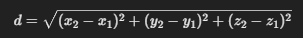
 
​ 
Возведение в квадрат каждой разницы 
x, y, и z — это часть этой формулы.

4. np.sum(..., axis=-1)   
np.sum(..., axis=-1) — вычисляет сумму квадратов разностей по последнему измерению (вдоль оси, отвечающей за координаты 
x, 
y, 
z). Это сворачивает трехмерные векторы в одно число, представляющее сумму квадратов расстояний между атомами.

После этого шага мы получаем массив размером (n_atoms, n_atoms), где каждый элемент — это сумма квадратов разностей координат для соответствующей пары атомов.

5. np.sqrt(...)   
np.sqrt(...) — вычисляет квадратный корень из суммы квадратов разностей. Это даёт евклидово расстояние между каждой парой атомов. Теперь массив (n_atoms, n_atoms) содержит все межатомные расстояния.

6. np.triu_indices_from(distances, k=1)  
np.triu_indices_from(distances, k=1) — извлекает индексы элементов верхнего треугольника матрицы distances (без диагонали). Это нужно, потому что матрица расстояний симметрична, и расстояние между атомом A и атомом B такое же, как между атомом B и атомом A, а на диагонали — нули, так как расстояние между атомом и самим собой равно нулю.  
Этот шаг убирает дублирующиеся значения и оставляет только уникальные пары атомов.

7. np.mean(distances[np.triu_indices_from(distances, k=1)])  
np.mean(...) — вычисляет среднее значение всех уникальных межатомных расстояний. Это среднее межатомное расстояние между атомами в структуре.

Итог:
distances = np.sqrt(np.sum((positions[:, np.newaxis] - positions[np.newaxis, :]) ** 2, axis=-1)): Этот шаг вычисляет евклидовы расстояния между всеми парами атомов в структуре.

mean_distance = np.mean(distances[np.triu_indices_from(distances, k=1)]): Этот шаг извлекает уникальные межатомные расстояния (с помощью верхнего треугольника матрицы расстояний) и вычисляет их среднее значение.

Это полезный показатель, так как среднее межатомное расстояние может быть важной характеристикой структуры материала и использоваться как фича для предсказания различных свойств.

Можно вычислить расстояния между атомами и извлечь статистические показатели на основе этих расстояний. Это даст информацию о плотности атомов и их упаковке.

Пример фичей:  
Среднее, минимальное, максимальное расстояние между атомами.  
Стандартное отклонение межатомных расстояний.  

In [63]:
# смотрим пример того, что будем преобразовывать в признаки
#  это уже картезианские абсолютные координаты
example_array =  df_detailed.atomic_positions_cart[80]
example_array

array([[ 6.4553912 ,  4.23319424, 14.32099189],
       [ 3.21638214,  2.10928609,  7.13581594],
       [ 1.44451809,  0.94754098,  3.20519114],
       [ 4.68356467,  3.07141624, 10.39002478],
       [ 4.90980978,  4.22916577,  9.93493603],
       [ 2.5963976 ,  0.69346242,  2.75014442],
       [ 3.57969738,  2.81750627, 10.95166586],
       [ 5.54963856,  2.15959183, 10.25809782],
       [ 0.77208357,  0.03594336,  3.76676839],
       [ 0.95399684,  2.10519771,  3.07304958]])

In [64]:
# в датафрейме присутствуют материалы с одним атомом и соответственно с нулевыми координатами
# для таких случаев далее нужно учесть исключение для избежания ошибки
df_detailed.loc[df_detailed['count_atoms']==1]

,lattice_a,lattice_b,lattice_c,angle_alpha,angle_beta,angle_gamma,cell_volume,composition,pbc,atomic_positions_frac,atomic_positions_cart,pbc_a,pbc_b,pbc_c,count_atoms,atom_coord_cart_mean_x,atom_coord_cart_mean_y,atom_coord_cart_mean_z,atom_coord_cart_std_x,atom_coord_cart_std_y,atom_coord_cart_std_z,atom_coord_cart_min_x,atom_coord_cart_min_y,atom_coord_cart_min_z,atom_coord_cart_max_x,atom_coord_cart_max_y,atom_coord_cart_max_z
83,2.855954,2.855954,2.855955,60.000003,60.000003,60.000002,16.471718,(Al),"(True, True, True)","[[0.0, 0.0, 0.0]]","[[0.0, 0.0, 0.0]]",True,True,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,3.792327,3.792327,3.792326,60.000000,60.000000,59.999985,38.565790,(Ar),"(True, True, True)","[[0.0, -0.0, -0.0]]","[[0.0, 0.0, 0.0]]",True,True,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
228,2.949546,2.949547,2.949546,60.000008,60.000002,60.000001,18.144738,(Au),"(True, True, True)","[[0.0, 0.0, 0.0]]","[[0.0, 0.0, 0.0]]",True,True,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
585,3.943404,3.943403,3.943405,60.000006,60.000012,60.000008,43.360964,(Ca),"(True, True, True)","[[0.0, 0.0, -0.0]]","[[0.0, 0.0, 0.0]]",True,True,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
713,2.529625,2.529626,2.529625,60.000012,60.000004,60.000003,11.445999,(Cu),"(True, True, True)","[[-0.0, -0.0, -0.0]]","[[0.0, 0.0, 0.0]]",True,True,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
869,2.484289,2.484289,2.484288,59.999997,59.999996,59.999990,10.841543,(Co),"(True, True, True)","[[-0.0, 0.0, -0.0]]","[[0.0, 0.0, 0.0]]",True,True,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


В данном расчете среднего межатомного расстояния используются абсолютные координаты атомов, поскольку межатомные расстояния в пространстве могут быть корректно вычислены только в абсолютных единицах (например, в ангстремах).

Почему дробные координаты нельзя использовать напрямую:
Дробные координаты — это координаты атомов в относительных единицах относительно векторов решетки. Они показывают, где находится атом по отношению к граням элементарной ячейки, но не дают информацию об абсолютных расстояниях между атомами.  
Без преобразования в абсолютные координаты, мы не сможем корректно вычислить межатомные расстояния, поскольку дробные координаты зависят от формы и размеров решетки (векторов 
a, 
b, и 
c).

In [65]:
example_array.shape

(10, 3)

In [66]:
# смотрим как работает один из элементов расчёта
example_array[:,np.newaxis]

array([[[ 6.4553912 ,  4.23319424, 14.32099189]],

       [[ 3.21638214,  2.10928609,  7.13581594]],

       [[ 1.44451809,  0.94754098,  3.20519114]],

       [[ 4.68356467,  3.07141624, 10.39002478]],

       [[ 4.90980978,  4.22916577,  9.93493603]],

       [[ 2.5963976 ,  0.69346242,  2.75014442]],

       [[ 3.57969738,  2.81750627, 10.95166586]],

       [[ 5.54963856,  2.15959183, 10.25809782]],

       [[ 0.77208357,  0.03594336,  3.76676839]],

       [[ 0.95399684,  2.10519771,  3.07304958]]])

In [67]:
# оцениваем размер полученного массива
example_array[:,np.newaxis].shape

(10, 1, 3)

In [68]:
# оцениваем размер полученного массива
example_array[np.newaxis, :].shape

(1, 10, 3)

In [69]:
# смотрим как работает один из элементов расчёта
example_array[np.newaxis, :]

array([[[ 6.4553912 ,  4.23319424, 14.32099189],
        [ 3.21638214,  2.10928609,  7.13581594],
        [ 1.44451809,  0.94754098,  3.20519114],
        [ 4.68356467,  3.07141624, 10.39002478],
        [ 4.90980978,  4.22916577,  9.93493603],
        [ 2.5963976 ,  0.69346242,  2.75014442],
        [ 3.57969738,  2.81750627, 10.95166586],
        [ 5.54963856,  2.15959183, 10.25809782],
        [ 0.77208357,  0.03594336,  3.76676839],
        [ 0.95399684,  2.10519771,  3.07304958]]])

In [70]:
# смотрим как работает один из элементов расчёта
(example_array[:,np.newaxis] - example_array[np.newaxis, :])

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.23900906e+00,  2.12390815e+00,  7.18517595e+00],
        [ 5.01087311e+00,  3.28565326e+00,  1.11158008e+01],
        [ 1.77182653e+00,  1.16177800e+00,  3.93096711e+00],
        [ 1.54558143e+00,  4.02846886e-03,  4.38605586e+00],
        [ 3.85899360e+00,  3.53973182e+00,  1.15708475e+01],
        [ 2.87569382e+00,  1.41568797e+00,  3.36932603e+00],
        [ 9.05752644e-01,  2.07360241e+00,  4.06289406e+00],
        [ 5.68330763e+00,  4.19725088e+00,  1.05542235e+01],
        [ 5.50139436e+00,  2.12799652e+00,  1.12479423e+01]],

       [[-3.23900906e+00, -2.12390815e+00, -7.18517595e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.77186405e+00,  1.16174510e+00,  3.93062480e+00],
        [-1.46718253e+00, -9.62130151e-01, -3.25420884e+00],
        [-1.69342764e+00, -2.11987968e+00, -2.79912009e+00],
        [ 6.19984540e-01,  1.41582367e+00,  4.38567152e+00],
        [-3.63315239e-

In [71]:
# оцениваем размер полученного массива
(example_array[:,np.newaxis] - example_array[np.newaxis, :]).shape

(10, 10, 3)

In [72]:
# смотрим как работает один из элементов расчёта
(example_array[:,np.newaxis] - example_array[np.newaxis, :])**2

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.04911797e+01, 4.51098584e+00, 5.16267534e+01],
        [2.51088493e+01, 1.07955173e+01, 1.23561026e+02],
        [3.13936927e+00, 1.34972813e+00, 1.54525024e+01],
        [2.38882195e+00, 1.62285614e-05, 1.92374860e+01],
        [1.48918316e+01, 1.25297013e+01, 1.33884511e+02],
        [8.26961497e+00, 2.00417241e+00, 1.13523579e+01],
        [8.20387852e-01, 4.29982696e+00, 1.65071082e+01],
        [3.22999856e+01, 1.76169149e+01, 1.11391634e+02],
        [3.02653399e+01, 4.52836921e+00, 1.26516206e+02]],

       [[1.04911797e+01, 4.51098584e+00, 5.16267534e+01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.13950221e+00, 1.34965168e+00, 1.54498114e+01],
        [2.15262457e+00, 9.25694427e-01, 1.05898751e+01],
        [2.86769716e+00, 4.49388988e+00, 7.83507327e+00],
        [3.84380830e-01, 2.00455665e+00, 1.92341147e+01],
        [1.31997963e-01, 5.01575835e-01, 1.45607106e+01],
        [5.4

In [73]:
# смотрим как работает один из элементов расчёта
np.sum((example_array[:,np.newaxis] - example_array[np.newaxis, :])**2, axis=-1)

array([[  0.        ,  66.62891894, 159.465393  ,  19.94159982,
         21.62632417, 161.30604403,  21.62614525,  21.62732299,
        161.30853417, 161.30991538],
       [ 66.62891894,   0.        ,  19.93896525,  13.66819415,
         15.1966603 ,  21.62305215,  15.19428442,  15.19526034,
         21.62382694,  21.62447449],
       [159.465393  ,  19.93896525,   0.        ,  66.62410326,
         68.06677402,   1.59844983,  68.06363146,  68.06457404,
          1.59854742,   1.5982416 ],
       [ 19.94159982,  13.66819415,  66.62410326,   0.        ,
          1.5986766 ,  68.37870255,   1.59843397,   1.59891246,
         68.3813051 ,  68.3813805 ],
       [ 21.62632417,  15.1966603 ,  68.06677402,   1.5986766 ,
          0.        ,  69.47430449,   4.79572108,   4.79695072,
         72.75018431,  67.24518197],
       [161.30604403,  21.62305215,   1.59844983,  68.37870255,
         69.47430449,   0.        ,  72.74339467,  67.24053186,
          4.79397727,   4.79474453],
       [ 2

In [74]:
# оцениваем размер полученного массива
np.sum((example_array[:,np.newaxis] - example_array[np.newaxis, :])**2, axis=-1).shape

(10, 10)

In [75]:
# смотрим как работает один из элементов расчёта
distanses = np.sqrt(np.sum((example_array[:,np.newaxis] - example_array[np.newaxis, :])**2, axis=-1))
distanses

array([[ 0.        ,  8.16265391, 12.62796076,  4.46560184,  4.65041118,
        12.70063164,  4.65039195,  4.65051857, 12.70072967, 12.70078405],
       [ 8.16265391,  0.        ,  4.46530685,  3.69705209,  3.89828941,
         4.65005937,  3.89798466,  3.89810984,  4.65014268,  4.65021231],
       [12.62796076,  4.46530685,  0.        ,  8.16235893,  8.25025903,
         1.26429816,  8.25006857,  8.2501257 ,  1.26433675,  1.2642158 ],
       [ 4.46560184,  3.69705209,  8.16235893,  0.        ,  1.26438784,
         8.26914158,  1.26429188,  1.2644811 ,  8.26929895,  8.26930351],
       [ 4.65041118,  3.89828941,  8.25025903,  1.26438784,  0.        ,
         8.33512474,  2.18991349,  2.19019422,  8.52937186,  8.20031597],
       [12.70063164,  4.65005937,  1.26429816,  8.26914158,  8.33512474,
         0.        ,  8.52897383,  8.20003243,  2.1895153 ,  2.18969051],
       [ 4.65039195,  3.89798466,  8.25006857,  1.26429188,  2.18991349,
         8.52897383,  0.        ,  2.18964753

In [76]:
# оцениваем размер полученного массива
distanses.shape

(10, 10)

In [77]:
# смотрим как работает один из элементов расчёта
np.triu_indices_from(distanses)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
        5, 6, 6, 6, 6, 7, 7, 7, 8, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4,
        5, 6, 7, 8, 9, 3, 4, 5, 6, 7, 8, 9, 4, 5, 6, 7, 8, 9, 5, 6, 7, 8,
        9, 6, 7, 8, 9, 7, 8, 9, 8, 9, 9]))

In [78]:
# смотрим как работает один из элементов расчёта
np.triu_indices_from(distanses, k=1)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7,
        8]),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7,
        8, 9, 4, 5, 6, 7, 8, 9, 5, 6, 7, 8, 9, 6, 7, 8, 9, 7, 8, 9, 8, 9,
        9]))

In [79]:
# смотрим как работает один из элементов расчёта
distanses[np.triu_indices_from(distanses, k=1)]

array([ 8.16265391, 12.62796076,  4.46560184,  4.65041118, 12.70063164,
        4.65039195,  4.65051857, 12.70072967, 12.70078405,  4.46530685,
        3.69705209,  3.89828941,  4.65005937,  3.89798466,  3.89810984,
        4.65014268,  4.65021231,  8.16235893,  8.25025903,  1.26429816,
        8.25006857,  8.2501257 ,  1.26433675,  1.2642158 ,  1.26438784,
        8.26914158,  1.26429188,  1.2644811 ,  8.26929895,  8.26930351,
        8.33512474,  2.18991349,  2.19019422,  8.52937186,  8.20031597,
        8.52897383,  8.20003243,  2.1895153 ,  2.18969051,  2.18964753,
        8.20015483,  8.33512336,  8.33500283,  8.52923208,  2.19001183])

In [80]:
# смотрим как работает один из элементов расчёта
np.mean(distanses[np.triu_indices_from(distanses, k=1)])

5.88346029758845

In [81]:
# смотрим как работает один из элементов расчёта
np.min(distanses[np.triu_indices_from(distanses, k=1)])

1.2642158031338382

In [82]:
np.mean(np.sqrt(np.sum((example_array[:,np.newaxis] - example_array[np.newaxis, :])**2, axis=-1)))

5.295114267829605

In [83]:
def average_interatomic_distance(atomic_positions, variant) -> float:
    '''Функция вычисляет межатомные расстояния и статистические данные для указанного массива абсолютных координат атомов структуры материала'''

    # рассчитаем все межатомные расстояния
    distanses = np.sqrt(np.sum((atomic_positions[:,np.newaxis] - atomic_positions[np.newaxis, :])**2, axis=-1))

    if variant == 1:
        # вычислим среднее межатомное расстояние
        mean_distance = np.mean(distanses[np.triu_indices_from(distanses, k=1)])
        if abs(mean_distance) >= 0:
            return mean_distance
        else:
            return 0

    elif variant == 2:
        # вычислим стандартное отклонение межатомного расстояния
        std_distance = np.std(distanses[np.triu_indices_from(distanses, k=1)])
        if abs(std_distance) >= 0:
            return std_distance
        else:
            return 0
    elif variant == 3:
        # вычислим минимальное межатомное расстояние
        try:
            min_distance = np.min(distanses[np.triu_indices_from(distanses, k=1)])
        except:
            min_distance = 0
        return min_distance
    elif variant == 4:
        # вычислим максимальное межатомное расстояние
        try:
            max_distance = np.max(distanses[np.triu_indices_from(distanses, k=1)])
        except:
            max_distance = 0
        return max_distance

In [84]:
%%time
# формируем поле со средним межатомным расстоянием структур материалов
df_detailed['interatomic_distance_avg'] = [average_interatomic_distance(i, variant=1) for i in df_detailed.atomic_positions_cart]

CPU times: total: 15.6 ms
Wall time: 96.8 ms


c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [85]:
%%time
# формируем поле со стандартным отклонением межатомного расстояния структур материалов
df_detailed['interatomic_distance_std'] = [average_interatomic_distance(i, variant=2) for i in df_detailed.atomic_positions_cart]

CPU times: total: 31.2 ms
Wall time: 92.1 ms


c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [86]:
%%time
# формируем поле с минимальным межатомным расстоянием структур материалов
df_detailed['interatomic_distance_min'] = [average_interatomic_distance(i, variant=3) for i in df_detailed.atomic_positions_cart]

CPU times: total: 46.9 ms
Wall time: 55.4 ms


In [87]:
%%time
# формируем поле с максимальным межатомным расстоянием структур материалов
df_detailed['interatomic_distance_max'] = [average_interatomic_distance(i, variant=4) for i in df_detailed.atomic_positions_cart]

CPU times: total: 31.2 ms
Wall time: 59.2 ms


distances = np.sqrt(np.sum((positions[:, np.newaxis] - positions[np.newaxis, :]) ** 2, axis=-1)): Этот шаг вычисляет евклидовы расстояния между всеми парами атомов в структуре.

mean_distance = np.mean(distances[np.triu_indices_from(distances, k=1)]): Этот шаг извлекает уникальные межатомные расстояния (с помощью верхнего треугольника матрицы расстояний) и вычисляет их среднее значение.

Это полезный показатель, так как среднее межатомное расстояние может быть важной характеристикой структуры материала и использоваться как фича для предсказания различных свойств.

##### Введение центра масс 

Можно использовать центр масс структуры как референсную точку и извлечь фичи, связанные с относительными позициями атомов относительно этого центра.

1. Вычисляем центр масс структуры.

2. Вычисляем относительные координаты атомов (разница между координатами атомов и координатами центра масс).

3. Вычисляем такие показатели, как средние, минимальные, максимальные и стандартные отклонения относительных координат.

Пример фичей:
Средние относительные координаты по каждой оси.
Стандартные отклонения и максимальные/минимальные значения относительных координат.

In [88]:
# пример абсолютных координат атомов для структуры материала
example_positions = example_array
example_positions

array([[ 6.4553912 ,  4.23319424, 14.32099189],
       [ 3.21638214,  2.10928609,  7.13581594],
       [ 1.44451809,  0.94754098,  3.20519114],
       [ 4.68356467,  3.07141624, 10.39002478],
       [ 4.90980978,  4.22916577,  9.93493603],
       [ 2.5963976 ,  0.69346242,  2.75014442],
       [ 3.57969738,  2.81750627, 10.95166586],
       [ 5.54963856,  2.15959183, 10.25809782],
       [ 0.77208357,  0.03594336,  3.76676839],
       [ 0.95399684,  2.10519771,  3.07304958]])

In [89]:
# Вычисляем центр масс (средние координаты по всем атомам)
center_of_mass = np.mean(example_positions, axis=0)
center_of_mass

array([3.41614798, 2.24023049, 7.57866859])

In [90]:
# Вычисляем относительные координаты атомов относительно центра масс
relative_positions = example_positions - center_of_mass
relative_positions

array([[ 3.03924322,  1.99296375,  6.7423233 ],
       [-0.19976584, -0.13094441, -0.44285264],
       [-1.97162989, -1.29268951, -4.37347745],
       [ 1.26741668,  0.83118575,  2.81135619],
       [ 1.49366179,  1.98893528,  2.35626744],
       [-0.81975038, -1.54676807, -4.82852416],
       [ 0.1635494 ,  0.57727578,  3.37299728],
       [ 2.13349058, -0.08063866,  2.67942924],
       [-2.64406441, -2.20428713, -3.81190019],
       [-2.46215114, -0.13503278, -4.50561901]])

In [91]:
# Вычисляем статистические показатели для относительных координат
np.mean(relative_positions[:,0])

-2.6645352591003756e-16

In [92]:
def relative_mean_x(row):
    '''Рассчёт относительных межатомных расстояний относительно центра масс'''

    # Вычисляем центр масс (средние координаты по всем атомам)
    center_of_mass = np.mean(row['atomic_positions_cart'], axis=0)
    # Вычисляем относительные координаты атомов относительно центра масс
    relative_positions = row['atomic_positions_cart'] - center_of_mass
    # Вычисляем статистические показатели для относительных координат
    mean_x= np.mean(relative_positions[:,0])
    return mean_x

In [93]:
def relative_mean_y(row):
    '''Рассчёт относительных межатомных расстояний относительно центра масс'''

    # Вычисляем центр масс (средние координаты по всем атомам)
    center_of_mass = np.mean(row['atomic_positions_cart'], axis=0)
    # Вычисляем относительные координаты атомов относительно центра масс
    relative_positions = row['atomic_positions_cart'] - center_of_mass
    # Вычисляем статистические показатели для относительных координат
    mean_y= np.mean(relative_positions[:,1])
    return mean_y

In [94]:
def relative_mean_z(row):
    '''Рассчёт относительных межатомных расстояний относительно центра масс'''

    # Вычисляем центр масс (средние координаты по всем атомам)
    center_of_mass = np.mean(row['atomic_positions_cart'], axis=0)
    # Вычисляем относительные координаты атомов относительно центра масс
    relative_positions = row['atomic_positions_cart'] - center_of_mass
    # Вычисляем статистические показатели для относительных координат
    mean_z= np.mean(relative_positions[:,2])
    return mean_z

In [95]:
# создаём новые признаки
df_detailed['atom_coord_relative_mean_x'] = df_detailed.apply(relative_mean_x, axis=1)
df_detailed['atom_coord_relative_mean_y'] = df_detailed.apply(relative_mean_y, axis=1)
df_detailed['atom_coord_relative_mean_z'] = df_detailed.apply(relative_mean_z, axis=1)

In [96]:
def relative_std_x(row):
    '''Рассчёт относительных межатомных расстояний относительно центра масс'''

    # Вычисляем центр масс (средние координаты по всем атомам)
    center_of_mass = np.mean(row['atomic_positions_cart'], axis=0)
    # Вычисляем относительные координаты атомов относительно центра масс
    relative_positions = row['atomic_positions_cart'] - center_of_mass
    # Вычисляем статистические показатели для относительных координат
    std_x= np.std(relative_positions[:,0])
    return std_x

def relative_std_y(row):
    '''Рассчёт относительных межатомных расстояний относительно центра масс'''

    # Вычисляем центр масс (средние координаты по всем атомам)
    center_of_mass = np.mean(row['atomic_positions_cart'], axis=0)
    # Вычисляем относительные координаты атомов относительно центра масс
    relative_positions = row['atomic_positions_cart'] - center_of_mass
    # Вычисляем статистические показатели для относительных координат
    std_y= np.std(relative_positions[:,1])
    return std_y

def relative_std_z(row):
    '''Рассчёт относительных межатомных расстояний относительно центра масс'''

    # Вычисляем центр масс (средние координаты по всем атомам)
    center_of_mass = np.mean(row['atomic_positions_cart'], axis=0)
    # Вычисляем относительные координаты атомов относительно центра масс
    relative_positions = row['atomic_positions_cart'] - center_of_mass
    # Вычисляем статистические показатели для относительных координат
    std_z= np.std(relative_positions[:,2])
    return std_z

In [97]:
# создаём новые признаки
df_detailed['atom_coord_relative_std_x'] = df_detailed.apply(relative_std_x, axis=1)
df_detailed['atom_coord_relative_std_y'] = df_detailed.apply(relative_std_y, axis=1)
df_detailed['atom_coord_relative_std_z'] = df_detailed.apply(relative_std_z, axis=1)

In [98]:
def relative_min_x(row):
    '''Рассчёт относительных межатомных расстояний относительно центра масс'''

    # Вычисляем центр масс (средние координаты по всем атомам)
    center_of_mass = np.mean(row['atomic_positions_cart'], axis=0)
    # Вычисляем относительные координаты атомов относительно центра масс
    relative_positions = row['atomic_positions_cart'] - center_of_mass
    # Вычисляем статистические показатели для относительных координат
    min_x= np.min(relative_positions[:,0])
    return min_x

def relative_min_y(row):
    '''Рассчёт относительных межатомных расстояний относительно центра масс'''

    # Вычисляем центр масс (средние координаты по всем атомам)
    center_of_mass = np.mean(row['atomic_positions_cart'], axis=0)
    # Вычисляем относительные координаты атомов относительно центра масс
    relative_positions = row['atomic_positions_cart'] - center_of_mass
    # Вычисляем статистические показатели для относительных координат
    min_y= np.min(relative_positions[:,1])
    return min_y

def relative_min_z(row):
    '''Рассчёт относительных межатомных расстояний относительно центра масс'''

    # Вычисляем центр масс (средние координаты по всем атомам)
    center_of_mass = np.mean(row['atomic_positions_cart'], axis=0)
    # Вычисляем относительные координаты атомов относительно центра масс
    relative_positions = row['atomic_positions_cart'] - center_of_mass
    # Вычисляем статистические показатели для относительных координат
    min_z= np.min(relative_positions[:,2])
    return min_z

In [99]:
# создаём новые признаки
df_detailed['atom_coord_relative_min_x'] = df_detailed.apply(relative_min_x, axis=1)
df_detailed['atom_coord_relative_min_y'] = df_detailed.apply(relative_min_y, axis=1)
df_detailed['atom_coord_relative_min_z'] = df_detailed.apply(relative_min_z, axis=1)

In [100]:
def relative_max_x(row):
    '''Рассчёт относительных межатомных расстояний относительно центра масс'''

    # Вычисляем центр масс (средние координаты по всем атомам)
    center_of_mass = np.mean(row['atomic_positions_cart'], axis=0)
    # Вычисляем относительные координаты атомов относительно центра масс
    relative_positions = row['atomic_positions_cart'] - center_of_mass
    # Вычисляем статистические показатели для относительных координат
    max_x= np.max(relative_positions[:,0])
    return max_x

def relative_max_y(row):
    '''Рассчёт относительных межатомных расстояний относительно центра масс'''

    # Вычисляем центр масс (средние координаты по всем атомам)
    center_of_mass = np.mean(row['atomic_positions_cart'], axis=0)
    # Вычисляем относительные координаты атомов относительно центра масс
    relative_positions = row['atomic_positions_cart'] - center_of_mass
    # Вычисляем статистические показатели для относительных координат
    max_y= np.max(relative_positions[:,1])
    return max_y

def relative_max_z(row):
    '''Рассчёт относительных межатомных расстояний относительно центра масс'''

    # Вычисляем центр масс (средние координаты по всем атомам)
    center_of_mass = np.mean(row['atomic_positions_cart'], axis=0)
    # Вычисляем относительные координаты атомов относительно центра масс
    relative_positions = row['atomic_positions_cart'] - center_of_mass
    # Вычисляем статистические показатели для относительных координат
    max_z= np.max(relative_positions[:,2])
    return max_z

In [101]:
# создаём новые признаки
df_detailed['atom_coord_relative_max_x'] = df_detailed.apply(relative_max_x, axis=1)
df_detailed['atom_coord_relative_max_y'] = df_detailed.apply(relative_max_y, axis=1)
df_detailed['atom_coord_relative_max_z'] = df_detailed.apply(relative_max_z, axis=1)

In [102]:
# смотрим, что получилось

df_detailed.tail(3)

,lattice_a,lattice_b,lattice_c,angle_alpha,angle_beta,angle_gamma,cell_volume,composition,pbc,atomic_positions_frac,atomic_positions_cart,pbc_a,pbc_b,pbc_c,count_atoms,atom_coord_cart_mean_x,atom_coord_cart_mean_y,atom_coord_cart_mean_z,atom_coord_cart_std_x,atom_coord_cart_std_y,atom_coord_cart_std_z,atom_coord_cart_min_x,atom_coord_cart_min_y,atom_coord_cart_min_z,atom_coord_cart_max_x,atom_coord_cart_max_y,atom_coord_cart_max_z,interatomic_distance_avg,interatomic_distance_std,interatomic_distance_min,interatomic_distance_max,atom_coord_relative_mean_x,atom_coord_relative_mean_y,atom_coord_relative_mean_z,atom_coord_relative_std_x,atom_coord_relative_std_y,atom_coord_relative_std_z,atom_coord_relative_min_x,atom_coord_relative_min_y,atom_coord_relative_min_z,atom_coord_relative_max_x,atom_coord_relative_max_y,atom_coord_relative_max_z
997,4.108458,4.571991,9.754448,103.564379,102.157162,89.999999,173.885396,"(Ca, Al, Ge)","(True, True, True)","[[0.5, -0.0, -0.0], [0.18588976, 0.18453233, 0...","[[2.00889461, 0.0, -0.429184905], [0.698377988...",True,True,True,7,1.903513,1.902555,3.291375,1.167131,1.141779,2.641211,0.141584,0.0,-0.429185,3.630314,3.619924,7.160232,4.457966,1.619933,2.502904,7.994682,-1.268826e-16,3.172066e-17,2.537653e-16,1.167131,1.141779,2.641211,-1.761929,-1.902555,-3.720560,1.726801,1.717369,3.868856
998,6.345628,6.345629,6.345629,109.471218,109.471220,109.471224,196.698948,"(Ca, Ga, Ni)","(True, True, True)","[[-0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5,...","[[-1.49567914, 2.590591995, 2.1152097899999998...",True,True,True,11,0.815825,1.413050,0.576876,1.702760,1.428487,1.764681,-1.824582,0.0,-2.115209,3.649164,3.912350,3.870524,4.020775,1.245919,2.316525,6.691578,-1.614870e-16,0.000000e+00,-1.211152e-16,1.702760,1.428487,1.764681,-2.640407,-1.413050,-2.692085,2.833340,2.499300,3.293648
999,6.436035,6.436034,6.436034,109.471218,109.471215,109.471220,205.226380,"(Ca, Si, Ir)","(True, True, True)","[[0.5, 0.5, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[1.5169884900000001, 2.62750003, -2.14534432]...",True,True,True,11,0.827448,1.433182,0.585094,1.926581,1.431026,2.031670,-2.189294,0.0,-2.145344,4.378590,3.791970,4.644196,4.406756,1.527225,2.286028,7.583940,-8.074349e-17,1.614870e-16,-1.614870e-16,1.926581,1.431026,2.031670,-3.016743,-1.433182,-2.730438,3.551142,2.358788,4.059101


##### Вывод по разделу формирования признаков на основе аболютных координат атомов в структуре

Использованы несколько подходов:

1. Агрегация атомных позиций — извлечение статистических показателей (среднее, стандартное отклонение и т. д.) по атомным координатам.
2. Межатомные расстояния — вычисление и использование статистик межатомных расстояний как признаков.
3. Центр масс — вычисление относительных координат атомов относительно центра масс.

На будущее можно дополнительно проработать возможность использования PCA (метод главных компонент)
чтобы сжать данные о координатах атомов в несколько основных компонент. Это позволит учесть информацию о вариациях в позициях атомов и сократить количество фичей. Пока неясно насколько это рабочий метод в данном случае, но нужно изучить вопрос. 

#### Разделение дробных атомных координат на отдельные признаки (фичи)

##### Агрегация дробных координат:

Используем агрегационные статистики для дробных координат, чтобы описать относительное распределение атомов в элементарной ячейке.
Этот метод применим для анализа регулярности и симметрии атомов внутри элементарной ячейки. Он может дать представление о том, как атомы распределены относительно кристаллической решетки.

Для абсолютных расчетов (таких как межатомные расстояния) — дробные координаты не подходят.

Для относительных расчетов (таких как симметрия или распределение атомов внутри элементарной ячейки) — дробные координаты подходят.

In [103]:
# формирууем поле среднее значение дробных координат по оси х для всех атомов структуры  
df_detailed['atom_coord_frac_mean_x'] = [np.mean(list(i[:,0])) for i in df_detailed.atomic_positions_frac]
# формирууем поле среднее значение дробных координат по оси y для всех атомов структуры  
df_detailed['atom_coord_frac_mean_y'] = [np.mean(list(i[:,1])) for i in df_detailed.atomic_positions_frac]
# формирууем поле среднее значение дробных координат по оси z для всех атомов структуры  
df_detailed['atom_coord_frac_mean_z'] = [np.mean(list(i[:,2])) for i in df_detailed.atomic_positions_frac]

# формирууем поле стандартное отклонение значений дробных координат по оси х для всех атомов структуры  
df_detailed['atom_coord_frac_std_x'] = [np.std(list(i[:,0])) for i in df_detailed.atomic_positions_frac]
# формирууем поле стандартное отклонение значений дробных координат по оси y для всех атомов структуры  
df_detailed['atom_coord_frac_std_y'] = [np.std(list(i[:,1])) for i in df_detailed.atomic_positions_frac]
# формирууем поле стандартное отклонение значений дробных координат по оси z для всех атомов структуры  
df_detailed['atom_coord_frac_std_z'] = [np.std(list(i[:,2])) for i in df_detailed.atomic_positions_frac]

# формирууем поле с минимальным значением дробных координат по оси х для всех атомов структуры  
df_detailed['atom_coord_frac_min_x'] = [np.min(list(i[:,0])) for i in df_detailed.atomic_positions_frac]
# формирууем поле с минимальным значением дробных координат по оси y для всех атомов структуры  
df_detailed['atom_coord_frac_min_y'] = [np.min(list(i[:,1])) for i in df_detailed.atomic_positions_frac]
# формирууем поле с минимальным значением дробных координат по оси z для всех атомов структуры  
df_detailed['atom_coord_frac_min_z'] = [np.min(list(i[:,2])) for i in df_detailed.atomic_positions_frac]

# формирууем поле с максимальным значением дробных координат по оси х для всех атомов структуры
df_detailed['atom_coord_frac_max_x'] = [np.max(list(i[:,0])) for i in df_detailed.atomic_positions_frac]
# формирууем поле с максимальным значением дробных координат по оси y для всех атомов структуры
df_detailed['atom_coord_frac_max_y'] = [np.max(list(i[:,1])) for i in df_detailed.atomic_positions_frac]
# формирууем поле с максимальным значением дробных координат по оси z для всех атомов структуры
df_detailed['atom_coord_frac_max_z'] = [np.max(list(i[:,2])) for i in df_detailed.atomic_positions_frac]

##### Координационные числа

Некоторые исследования показали, что такие характеристики кристаллической структуры, как координационные числа и межатомные расстояния, могут быть сильными предикторами механических свойств, включая модуль Юнга, особенно для материалов с сильно различающимися кристаллическими структурами и типами химических связей.

Координационные числа предоставляют важную информацию о локальной атомной среде каждого атома в кристаллической структуре, что напрямую влияет на механические свойства материала.

Координационное число отражает количество ближайших соседей у каждого атома. Это дает представление о том, насколько плотно упакованы атомы в структуре.

Более высокие координационные числа обычно указывают на более плотную упаковку и сильные межатомные взаимодействия, что может приводить к более высоким модулям упругости.

Для вычисления комплексных чисел рекомендуется использовать проверенные методы (например, Voronoi анализ). 

В сложных кристаллических структурах с многими типами атомов координационные числа могут варьироваться для разных атомов, что усложняет прямую интерпретацию их влияния на модуль упругости. В таких случаях важно агрегировать координационные числа (например, средние значения или стандартные отклонения).

Хотя координационное число важно, оно не единственный фактор, определяющий модуль упругости. Например, материалы с одинаковыми координационными числами могут иметь разные типы химических связей (ковалентные, ионные, металлические), что сильно влияет на механические свойства.

In [104]:
# voronoi = VoronoiNN()
voronoi = VoronoiNN(allow_pathological=True)

In [105]:
coordination_numbers = []
element_coordination = {}

In [106]:
structure = df_limit.structure[0]
structure

Structure Summary
Lattice
    abc : 4.04604073 4.046040804636149 13.01703648
 angles : 90.0 90.0 120.0000082576264
 volume : 184.54540076862065
      A : 4.04604073 -2e-08 0.0
      B : -2.02302089 3.50397384 0.0
      C : 0.0 0.0 13.01703648
    pbc : True True True
PeriodicSite: Ac (0.0, 0.0, 0.0) [-0.0, -0.0, 0.0]
PeriodicSite: Ac (-3.5e-07, 2.336, 3.254) [0.3333, 0.6667, 0.25]
PeriodicSite: Ac (0.0, 0.0, 6.509) [-0.0, -0.0, 0.5]
PeriodicSite: Ac (2.023, 1.168, 9.763) [0.6667, 0.3333, 0.75]

In [107]:
df_limit.columns

Index(['bulk_modulus', 'composition', 'formula', 'e_above_hull', 'structure',
       'density', 'volume'],
      dtype='object')

In [108]:
df_limit.structure[0]

Structure Summary
Lattice
    abc : 4.04604073 4.046040804636149 13.01703648
 angles : 90.0 90.0 120.0000082576264
 volume : 184.54540076862065
      A : 4.04604073 -2e-08 0.0
      B : -2.02302089 3.50397384 0.0
      C : 0.0 0.0 13.01703648
    pbc : True True True
PeriodicSite: Ac (0.0, 0.0, 0.0) [-0.0, -0.0, 0.0]
PeriodicSite: Ac (-3.5e-07, 2.336, 3.254) [0.3333, 0.6667, 0.25]
PeriodicSite: Ac (0.0, 0.0, 6.509) [-0.0, -0.0, 0.5]
PeriodicSite: Ac (2.023, 1.168, 9.763) [0.6667, 0.3333, 0.75]

In [109]:
type(structure)

pymatgen.core.structure.Structure

In [110]:
structure[0]

PeriodicSite: Ac (0.0, 0.0, 0.0) [-0.0, -0.0, 0.0]

In [111]:
structure = df_limit.structure[80]
structure

Structure Summary
Lattice
    abc : 6.201768483235515 6.201684964596964 6.201686927787416
 angles : 49.089530444954136 49.08691654268514 49.088562551141926
 volume : 125.10450403344892
      A : 4.66677261 -0.02019971 4.08445317
      B : 1.84114753 4.28822816 4.0843814
      C : -0.03033507 -0.02017805 6.20157991
    pbc : True True True
PeriodicSite: Ag (6.455, 4.233, 14.32) [0.9966, 0.9965, 0.9966]
PeriodicSite: Ag (3.216, 2.109, 7.136) [0.4965, 0.4966, 0.4966]
PeriodicSite: N (1.445, 0.9475, 3.205) [0.223, 0.2231, 0.2231]
PeriodicSite: N (4.684, 3.071, 10.39) [0.723, 0.7231, 0.723]
PeriodicSite: O (4.91, 4.229, 9.935) [0.6641, 0.9918, 0.5114]
PeriodicSite: O (2.596, 0.6935, 2.75) [0.4917, 0.1641, 0.01155]
PeriodicSite: O (3.58, 2.818, 10.95) [0.5115, 0.6641, 0.9917]
PeriodicSite: O (5.55, 2.16, 10.26) [0.9917, 0.5114, 0.6641]
PeriodicSite: O (0.7721, 0.03594, 3.767) [0.1641, 0.01147, 0.4917]
PeriodicSite: O (0.954, 2.105, 3.073) [0.01148, 0.4918, 0.1641]

In [112]:
voronoi.get_cn(structure,2)

10

In [113]:
# Инициализируем объект CrystalNN
crystal_nn = CrystalNN()

In [114]:
structure

Structure Summary
Lattice
    abc : 6.201768483235515 6.201684964596964 6.201686927787416
 angles : 49.089530444954136 49.08691654268514 49.088562551141926
 volume : 125.10450403344892
      A : 4.66677261 -0.02019971 4.08445317
      B : 1.84114753 4.28822816 4.0843814
      C : -0.03033507 -0.02017805 6.20157991
    pbc : True True True
PeriodicSite: Ag (6.455, 4.233, 14.32) [0.9966, 0.9965, 0.9966]
PeriodicSite: Ag (3.216, 2.109, 7.136) [0.4965, 0.4966, 0.4966]
PeriodicSite: N (1.445, 0.9475, 3.205) [0.223, 0.2231, 0.2231]
PeriodicSite: N (4.684, 3.071, 10.39) [0.723, 0.7231, 0.723]
PeriodicSite: O (4.91, 4.229, 9.935) [0.6641, 0.9918, 0.5114]
PeriodicSite: O (2.596, 0.6935, 2.75) [0.4917, 0.1641, 0.01155]
PeriodicSite: O (3.58, 2.818, 10.95) [0.5115, 0.6641, 0.9917]
PeriodicSite: O (5.55, 2.16, 10.26) [0.9917, 0.5114, 0.6641]
PeriodicSite: O (0.7721, 0.03594, 3.767) [0.1641, 0.01147, 0.4917]
PeriodicSite: O (0.954, 2.105, 3.073) [0.01148, 0.4918, 0.1641]

In [115]:
# Рассчитываем координационное число для атома с индексом 0
coordination_number = crystal_nn.get_cn(structure, 0)
coordination_number

c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\pymatgen\analysis\local_env.py:4158: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\pymatgen\analysis\local_env.py:3951: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(


6

Различные методы, такие как **`VoronoiNN`** и **`CrystalNN`**, могут давать разные результаты для координационных чисел, и это связано с их внутренними алгоритмами, которые используют разные подходы для определения ближайших соседей атомов в структуре. Разберемся, в чем причина таких расхождений и как с этим можно работать.

 Основные различия между методами

 1. **VoronoiNN**:
   - **Алгоритм**: Метод основан на **разбиении Вороного**, который создает многогранники вокруг каждого атома на основе их положения в пространстве. Атомы считаются ближайшими соседями, если они принадлежат одной грани многоугольника Вороного.
   - **Особенности**: Метод полностью основан на **геометрии**. Он определяет соседей исходя из того, как атомы делят пространство между собой. Метод не учитывает типы атомов, химические связи или другие физические свойства.
   - **Чувствительность**: **VoronoiNN** может быть чувствителен к небольшим флуктуациям в атомных позициях, что может приводить к "патологическим" результатам в структурах с высокой асимметрией или необычной упаковкой.

 2. **CrystalNN**:
   - **Алгоритм**: **CrystalNN** — это метод, который использует комбинацию геометрических и химических факторов для определения соседей. Он учитывает **межатомные расстояния**, **тип связи**, а также другие аспекты, такие как атомная масса и заряд.
   - **Особенности**: Этот метод лучше учитывает **химическое окружение** атомов, поэтому он может быть более точным для сложных структур, где геометрия не является единственным фактором, влияющим на координационные числа.
   - **Чувствительность**: Этот метод более устойчив к геометрическим флуктуациям, так как учитывает химию связей.

 Причины расхождений

1. **Геометрия против химии**:
   - **VoronoiNN** рассматривает только геометрию структуры, тогда как **CrystalNN** учитывает не только геометрию, но и **химические свойства** атомов и их связи. Если в вашей структуре важную роль играют химические связи (например, ковалентные или ионные), результаты **CrystalNN** будут более точными и физически обоснованными.

2. **Неоднородная упаковка**:
   - Если атомы в вашей структуре распределены неоднородно или имеются значительные различия в межатомных расстояниях, **VoronoiNN** может считать некоторые атомы ближайшими соседями на основе разбиения пространства, в то время как **CrystalNN** может исключить такие атомы из числа соседей на основе химии и межатомных расстояний.

3. **Патологические результаты Вороного**:
   - В некоторых структурах (особенно при наличии нестандартных кристаллических систем или высоких степеней асимметрии) **VoronoiNN** может давать "патологические" результаты, когда атомы оказываются в неожиданных соседях. Это связано с тем, что грани многоугольников Вороного могут быть слишком малы или слишком вытянуты. В таких случаях **CrystalNN** будет давать более устойчивый результат.

 Какой метод использовать?

1. **Если структура симметрична и геометрически регулярна** (например, металлы или кубические кристаллы), оба метода могут давать схожие результаты. **VoronoiNN** может быть быстрее и достаточно точен.
   
2. **Если структура сложная** (например, ионные кристаллы, оксиды, неорганические соединения) и важна химическая природа связей, лучше использовать **CrystalNN**, так как этот метод учитывает химию и физические свойства атомов.

Что делать, если результаты сильно различаются?

1. **Проанализируйте тип структуры**:
   - Если у вас структура с сильно различными атомами (например, различные химические элементы с разными типами связей), используйте **CrystalNN**, так как этот метод более подходит для таких задач.

2. **Используйте дополнительные параметры в VoronoiNN**:
   - Если вы хотите использовать **VoronoiNN**, но получить более стабильные результаты, попробуйте добавить параметр **`allow_pathological=True`**, чтобы обработать возможные патологии разбиения Вороного.

3. **Проверьте межатомные расстояния**:
   - Рассчитайте межатомные расстояния и проанализируйте, какие атомы **VoronoiNN** и **CrystalNN** считают соседями. Это поможет понять, на чем основываются различия в результатах. Используйте `structure.get_neighbors()` для этого.

4. **Анализируйте оба результата**:
   - В некоторых случаях может быть полезно рассмотреть оба метода, особенно если структура нетипичная. Можно использовать как геометрическое определение соседей (**VoronoiNN**), так и химическое окружение (**CrystalNN**), чтобы получить более полную картину.

 Итог:

- **VoronoiNN** использует только геометрию для определения соседей, что может быть полезно для простых структур, но в сложных кристаллах или системах с неравномерной упаковкой этот метод может давать результаты, которые не отражают химические связи.
- **CrystalNN** является более надежным методом для сложных структур, так как учитывает химию атомов и межатомные расстояния.
- Если методы дают разные результаты, проанализируйте структуру и выберите метод, который лучше соответствует химическим и геометрическим особенностям вашей системы.

Необходимо отметить что структура, представленная в Structure объектах (таких как те, которые используются в pymatgen), содержит геометрическую информацию о расположении атомов (координаты атомов, параметры решетки), но не включает явную информацию о типах химических связей между атомами.

Описание работы CrystalNN:  
CrystalNN использует алгоритм, который оценивает координационное число, комбинируя геометрическую информацию (такие как межатомные расстояния) и химическую информацию, такую как типы атомов. Важно понимать, что CrystalNN не имеет прямого доступа к информации о конкретных химических связях в виде явных данных о типах связей, таких как ковалентные или ионные. Однако он учитывает химические свойства атомов через их атомные номера, типы и относительные расстояния.

CrystalNN использует различные эвристические правила, чтобы делать выводы о вероятности существования химических связей между атомами на основе их пространственного расположения и природы (химического типа) атомов. В основе лежат общие модели химического взаимодействия атомов. Например:

Если атомы расположены близко друг к другу, и это элементы, которые обычно формируют связи в реальных материалах, CrystalNN может включить такие атомы в координационную среду.
Атомы, которые имеют слишком большие межатомные расстояния или относятся к типам элементов, которые обычно не взаимодействуют, могут не считаться соседями.

Как CrystalNN учитывает химию:  
Хотя CrystalNN не получает явной информации о типах химических связей, оно использует информацию о химических элементах, их атомных номерах, радиусах и других свойствах, чтобы лучше предсказать их взаимодействия в структуре. Это достигается через:

Эмпирические данные: Основываясь на известных химических свойствах элементов и их типичных межатомных расстояниях, CrystalNN может корректнее предсказывать ближайших соседей для разных типов атомов.
Типичные координации: CrystalNN обучено распознавать типичные координации для различных химических элементов, основываясь на эмпирических данных о реальных структурах.  
Почему могут быть различия между CrystalNN и VoronoiNN:  
VoronoiNN основывается исключительно на геометрии (разбиение Вороного), где соседями считаются атомы, находящиеся в тех же полиэдрах Вороного.

CrystalNN, в отличие от Voronoi, пытается учесть химическую природу атомов (по их атомным номерам) и, в дополнение к геометрии, использует различные эмпирические знания о типичных координациях элементов, чтобы предсказать их ближайших соседей.

Пример:
В приведенной структуре (с атомами серебра, азота и кислорода) VoronoiNN будет определять ближайших соседей только на основе пространственного распределения атомов (разбиение Вороного), не учитывая химическую природу атомов. CrystalNN, с другой стороны, будет учитывать, что, например, Ag (серебро) имеет свои типичные координационные числа и связи, которые отличаются от координаций для O (кислород) и N (азот). Оно может исключить некоторые из соседей, если они химически не имеют смысла, даже если они ближе в пространственном расположении.



Принято решение в дальнейшей обработке датафрейма использовать метод CrystalNN

In [116]:
def coordination_number(structure, command)-> int:
    '''Функция рассчитывает среднее КЧ для одной структуры'''
    # Инициализируем объект CrystalNN
    crystal_nn = CrystalNN()

    # рассчитываем список координационных чисел (КЧ для каждого атома в структуре) 
    coordination_numbers_list = [crystal_nn.get_cn(structure, i) for i in range(len(structure))]

    if command == 1:
        # возвращаем среднее
        return np.mean(coordination_numbers_list)
    if command == 2:
        # возвращаем стандартное отклонение
        return np.std(coordination_numbers_list)
    if command == 3:
        # возвращаем минимальное значение
        return np.min(coordination_numbers_list)
    if command == 4:
        # возвращаем максимальное значение
        return np.max(coordination_numbers_list)

In [117]:
%%time
# создадим поле со средним значение координационных чисел в структуре
df_detailed['coord_numb_mean'] = [coordination_number(i, 1) for i in df_limit.structure]

c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\pymatgen\core\periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


CPU times: total: 37.8 s
Wall time: 1min 7s


In [118]:
%%time
# создадим поле со стандартным отклонением координационных чисел в структуре
df_detailed['coord_numb_std'] = [coordination_number(i, 2) for i in df_limit.structure]

c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\pymatgen\analysis\local_env.py:4158: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\pymatgen\analysis\local_env.py:3951: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\pymatgen\core\periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


CPU times: total: 38.2 s
Wall time: 1min 9s


In [119]:
%%time
# создадим поле с минимальным значение координационных чисел в структуре
df_detailed['coord_numb_min'] = [coordination_number(i, 3) for i in df_limit.structure]

c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\pymatgen\analysis\local_env.py:4158: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\pymatgen\analysis\local_env.py:3951: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\pymatgen\core\periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


CPU times: total: 39.7 s
Wall time: 1min 9s


In [120]:
%%time
# создадим поле с максимальным значение координационных чисел в структуре
df_detailed['coord_numb_max'] = [coordination_number(i, 4) for i in df_limit.structure]

c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\pymatgen\analysis\local_env.py:4158: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\pymatgen\analysis\local_env.py:3951: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\pymatgen\core\periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


CPU times: total: 39.7 s
Wall time: 1min 10s



Координационные числа являются ценным признаком для моделей машинного обучения при прогнозировании модуля упругости, так как они отражают локальную атомную структуру и характер межатомных взаимодействий. Они помогают модели захватить сложные структурно-свойственные отношения, которые не всегда очевидны из химического состава или других простых признаков.

Включение координационных чисел в набор признаков может улучшить точность модели, особенно если мы работаем с материалами, где локальная структура играет ключевую роль в определении механических свойств. Однако важно помнить, что наилучшие результаты достигаются при использовании координационных чисел в сочетании с другими релевантными признаками (такими как тип связей, плотность, и межатомные расстояния) и при надлежащей обработке и анализе данных.

#### Вывод по формированию признаков структуры

 В итоге только из данных по структуре удалось создать 59 новых признаков, 

Элементы, которые можно включить в DataFrame:
a, b, c — длины векторов решетки.
alpha, beta, gamma — углы между векторами решетки.
volume — объем элементарной ячейки.
pbc — периодические граничные условия.
composition — химический состав (формула материала).
atomic positions — атомные позиции (дробные координаты атомов в решетке)

Отдельные признаки структуры

 'lattice_a', 'lattice_b', 'lattice_c' — длины векторов решетки.  
 'angle_alpha', 'angle_beta', 'angle_gamma'  — углы между векторами решетки.  
 'cell_volume' — объем элементарной ячейки.  
 'pbc_a', 'pbc_b', 'pbc_c' — периодические граничные условия.  
 'count_atoms' — количество атомов в структуре.  

При использовании абсолютных координат образовано несколько групп признаков.

Признаки агрегации атомных позиций:
'atom_coord_cart_mean_x',
'atom_coord_cart_mean_y', 'atom_coord_cart_mean_z',
'atom_coord_cart_std_x', 'atom_coord_cart_std_y',
'atom_coord_cart_std_z', 'atom_coord_cart_min_x',
'atom_coord_cart_min_y', 'atom_coord_cart_min_z',
'atom_coord_cart_max_x', 'atom_coord_cart_max_y',
'atom_coord_cart_max_z', 

Признаки межатомных расстояний:
'interatomic_distance_avg',
'interatomic_distance_std', 'interatomic_distance_min',
'interatomic_distance_max', 'atom_coord_relative_mean_x',

Признаки относительно центра масс:
'atom_coord_relative_mean_y', 'atom_coord_relative_mean_z',
'atom_coord_relative_std_x', 'atom_coord_relative_std_y',
'atom_coord_relative_std_z', 'atom_coord_relative_min_x',
'atom_coord_relative_min_y', 'atom_coord_relative_min_z',
'atom_coord_relative_max_x', 'atom_coord_relative_max_y',
'atom_coord_relative_max_z', 'atom_coord_frac_mean_x',

Признаки агрегации дробных координат:
'atom_coord_frac_mean_y', 'atom_coord_frac_mean_z',
'atom_coord_frac_std_x', 'atom_coord_frac_std_y',
'atom_coord_frac_std_z', 'atom_coord_frac_min_x',
'atom_coord_frac_min_y', 'atom_coord_frac_min_z',
'atom_coord_frac_max_x', 'atom_coord_frac_max_y',
'atom_coord_frac_max_z', 

Признаки на основе координационных чисел:  
'coord_numb_mean', 'coord_numb_std',
'coord_numb_min', 'coord_numb_max'

Поскольку данный проект носит исследовательский характер, первоначальная задача заключалась в получении максимального числа признаков, в качестве ознакомления.

На текущем этапе пока не ясно, какие из признаков оставим, а какие придётся отсеять. Это будем определять позже, при анализе влияния фич на целевой параметр.

In [121]:
len(df_detailed.columns)

59

#### Сохраняем и загружаем df_detailed результаты важного этапа обработки структуры

Данный раздел закомментирован, т.к. ссылки индивидуальны для каждого пользователя

In [122]:
# PATH = r'C:\Users\lazarevnv\Desktop\materials_science\code_materials\first_ml_task_ung_modul\df_detailed_csv.csv'
# df_detailed.to_csv(PATH,  index=False, encoding='utf-8', sep=';', )

In [123]:
# PATH = r'C:\Users\lazarevnv\Desktop\materials_science\code_materials\first_ml_task_ung_modul\df_detailed_csv.csv'
# df_detailed = pd.read_csv(PATH, encoding='utf-8', sep=';')

In [124]:
df_detailed.tail(2)

,lattice_a,lattice_b,lattice_c,angle_alpha,angle_beta,angle_gamma,cell_volume,composition,pbc,atomic_positions_frac,atomic_positions_cart,pbc_a,pbc_b,pbc_c,count_atoms,atom_coord_cart_mean_x,atom_coord_cart_mean_y,atom_coord_cart_mean_z,atom_coord_cart_std_x,atom_coord_cart_std_y,atom_coord_cart_std_z,atom_coord_cart_min_x,atom_coord_cart_min_y,atom_coord_cart_min_z,atom_coord_cart_max_x,atom_coord_cart_max_y,atom_coord_cart_max_z,interatomic_distance_avg,interatomic_distance_std,interatomic_distance_min,interatomic_distance_max,atom_coord_relative_mean_x,atom_coord_relative_mean_y,atom_coord_relative_mean_z,atom_coord_relative_std_x,atom_coord_relative_std_y,atom_coord_relative_std_z,atom_coord_relative_min_x,atom_coord_relative_min_y,atom_coord_relative_min_z,atom_coord_relative_max_x,atom_coord_relative_max_y,atom_coord_relative_max_z,atom_coord_frac_mean_x,atom_coord_frac_mean_y,atom_coord_frac_mean_z,atom_coord_frac_std_x,atom_coord_frac_std_y,atom_coord_frac_std_z,atom_coord_frac_min_x,atom_coord_frac_min_y,atom_coord_frac_min_z,atom_coord_frac_max_x,atom_coord_frac_max_y,atom_coord_frac_max_z,coord_numb_mean,coord_numb_std,coord_numb_min,coord_numb_max
998,6.345628,6.345629,6.345629,109.471218,109.471220,109.471224,196.698948,"(Ca, Ga, Ni)","(True, True, True)","[[-0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5,...","[[-1.49567914, 2.590591995, 2.1152097899999998...",True,True,True,11,0.815825,1.413050,0.576876,1.702760,1.428487,1.764681,-1.824582,0.0,-2.115209,3.649164,3.91235,3.870524,4.020775,1.245919,2.316525,6.691578,-1.614870e-16,0.000000e+00,-1.211152e-16,1.702760,1.428487,1.764681,-2.640407,-1.413050,-2.692085,2.833340,2.499300,3.293648,0.272727,0.272727,0.272727,0.275707,0.275707,0.275707,0.0,0.0,-0.0,0.755107,0.755107,0.755107,10.545455,0.890724,10,12
999,6.436035,6.436034,6.436034,109.471218,109.471215,109.471220,205.226380,"(Ca, Si, Ir)","(True, True, True)","[[0.5, 0.5, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[1.5169884900000001, 2.62750003, -2.14534432]...",True,True,True,11,0.827448,1.433182,0.585094,1.926581,1.431026,2.031670,-2.189294,0.0,-2.145344,4.378590,3.79197,4.644196,4.406756,1.527225,2.286028,7.583940,-8.074349e-17,1.614870e-16,-1.614870e-16,1.926581,1.431026,2.031670,-3.016743,-1.433182,-2.730438,3.551142,2.358788,4.059101,0.272727,0.272727,0.272727,0.272317,0.272317,0.272317,0.0,-0.0,-0.0,0.721593,0.721593,0.721593,7.272727,0.445362,7,8


## Обработка признака composition (Химический состав материала) и formula

In [125]:
# смотрим поле formula
n=8
df_limit.formula[n*10:n*10+10]

80        AgNO3
81          AgO
82        AgPF6
83           Al
84    Al(CoSi)2
85     Al(CrB)2
86     Al(FeB)2
87       Al12Re
88       Al12Tc
89      Al13Os4
Name: formula, dtype: object

Признак formula использовать не будем. В данном случае воспользуемся только признаком composition.

In [126]:
# смотрим поле composition
n=8
df_limit.composition[n*10:n*10+30]

80       (Ag, N, O)
81          (Ag, O)
82       (Ag, P, F)
83             (Al)
84     (Al, Co, Si)
85      (Al, Cr, B)
86      (Al, Fe, B)
87         (Al, Re)
88         (Al, Tc)
89         (Al, Os)
90         (Al, Pd)
91         (Al, Pt)
92          (Al, B)
93         (Al, Au)
94      (Al, Cd, S)
95     (Al, Cd, Se)
96     (Al, Cd, Te)
97     (Al, Co, Ir)
98     (Al, Co, Os)
99     (Al, Co, Ru)
100        (Al, Cu)
101    (Al, Fe, Co)
102    (Al, Fe, Ir)
103     (Al, Hg, S)
104    (Al, Hg, Se)
105    (Al, Hg, Te)
106    (Al, Ir, Os)
107    (Al, Ir, Rh)
108    (Al, Ir, Ru)
109    (Al, Ni, Ru)
Name: composition, dtype: object

Можно преобразовать химическую формулу в числовые признаки на основе физических и химических свойств элементов. Например:

Атомная масса (atomic mass)

Электроотрицательность (electronegativity)

Радиус атома (atomic radius)

Ионный радиус (ionic radius)

Для этого можно взять сумму или среднее этих свойств по каждому элементу в составе.

Пример:
Для формулы Ac₂ Ag₁ Ir₁ можно рассчитать:

Суммарная атомная масса: 
2
×
атомная масса Ac
+
1
×
атомная масса Ag
+
1
×
атомная масса Ir


Средняя электроотрицательность: 
(
2
×
электроотрицательность Ac
+
1
×
электроотрицательность Ag
+
1
×
электроотрицательность Ir
)
/
4


В данном случае выберем один из вариантов - суммарная масса всех элементов в химической формуле

In [127]:
def element_quantity(el_str: str):
    '''Функция отделяет название элемента от количества атомов'''

    # получаем название элемента
    el = ''.join(i for i in el_str if i.isalpha()) or None
    
    # получаем количество атомов элемента
    try:
        number = int(''.join(i for i in el_str if i.isdigit()))
    except:
        number = 1

    return el, number

#### Загружаем данные с атомными массами каждого элемента

In [128]:
[(el.symbol,el.atomic_mass)  for el in Element]

[('H', 1.00794),
 ('H', 2.013553212712),
 ('H', 3.0155007134),
 ('He', 4.002602),
 ('Li', 6.941),
 ('Be', 9.012182),
 ('B', 10.811),
 ('C', 12.0107),
 ('N', 14.0067),
 ('O', 15.9994),
 ('F', 18.9984032),
 ('Ne', 20.1797),
 ('Na', 22.98976928),
 ('Mg', 24.305),
 ('Al', 26.9815386),
 ('Si', 28.0855),
 ('P', 30.973762),
 ('S', 32.065),
 ('Cl', 35.453),
 ('Ar', 39.948),
 ('K', 39.0983),
 ('Ca', 40.078),
 ('Sc', 44.955912),
 ('Ti', 47.867),
 ('V', 50.9415),
 ('Cr', 51.9961),
 ('Mn', 54.938045),
 ('Fe', 55.845),
 ('Co', 58.933195),
 ('Ni', 58.6934),
 ('Cu', 63.546),
 ('Zn', 65.409),
 ('Ga', 69.723),
 ('Ge', 72.64),
 ('As', 74.9216),
 ('Se', 78.96),
 ('Br', 79.904),
 ('Kr', 83.798),
 ('Rb', 85.4678),
 ('Sr', 87.62),
 ('Y', 88.90585),
 ('Zr', 91.224),
 ('Nb', 92.90638),
 ('Mo', 95.94),
 ('Tc', 98.0),
 ('Ru', 101.07),
 ('Rh', 102.9055),
 ('Pd', 106.42),
 ('Ag', 107.8682),
 ('Cd', 112.411),
 ('In', 114.818),
 ('Sn', 118.71),
 ('Sb', 121.76),
 ('Te', 127.6),
 ('I', 126.90447),
 ('Xe', 131.293),
 

In [129]:
# извлекаем список символов всех элементов
elements_list = [el.symbol for el in Element]
print(elements_list)

['H', 'H', 'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']


In [130]:
# извлекаем список атомных масс всех элементов
atomic_mass_list = [el.atomic_mass for el in Element]
print(atomic_mass_list)

[1.00794, 2.013553212712, 3.0155007134, 4.002602, 6.941, 9.012182, 10.811, 12.0107, 14.0067, 15.9994, 18.9984032, 20.1797, 22.98976928, 24.305, 26.9815386, 28.0855, 30.973762, 32.065, 35.453, 39.948, 39.0983, 40.078, 44.955912, 47.867, 50.9415, 51.9961, 54.938045, 55.845, 58.933195, 58.6934, 63.546, 65.409, 69.723, 72.64, 74.9216, 78.96, 79.904, 83.798, 85.4678, 87.62, 88.90585, 91.224, 92.90638, 95.94, 98.0, 101.07, 102.9055, 106.42, 107.8682, 112.411, 114.818, 118.71, 121.76, 127.6, 126.90447, 131.293, 132.9054519, 137.327, 138.90547, 140.116, 140.90765, 144.242, 145.0, 150.36, 151.964, 157.25, 158.92535, 162.5, 164.93032, 167.259, 168.93421, 173.04, 174.967, 178.49, 180.94788, 183.84, 186.207, 190.23, 192.217, 195.084, 196.966569, 200.59, 204.3833, 207.2, 208.9804, 210.0, 210.0, 220.0, 223.0, 226.0, 227.0, 232.03806, 231.03588, 238.02891, 237.0, 244.0, 243.0, 247.0, 247.0, 251.0, 252.0, 257.0, 258.0, 259.0, 262.0, 267.0, 268.0, 269.0, 270.0, 270.0, 278.0, 281.0, 282.0, 285.0, 286.0,

In [131]:
# создаём словарь с атомными массами для каждого элемента
element_dict = {'Element': elements_list, 'Atomic_mass': atomic_mass_list}

In [132]:
# создаём датафрейм
df_atomic_mass = pd.DataFrame(element_dict)

In [133]:
df_atomic_mass.head()

,Element,Atomic_mass
0,H,1.007940
1,H,2.013553
2,H,3.015501
3,He,4.002602
4,Li,6.941000


Нужно отметить, что у водорода могут быть разные атомные массы. Это связано с тем, что водород имеет три стабильных изотопа. Эти атомные массы представляют собой массы изотопов водорода:

Протий (H-1) — атомная масса: 1.00794
Это самый распространённый изотоп водорода, который содержит один протон и не имеет нейтронов.

Дейтерий (H-2) — атомная масса: 2.013553212712
Это тяжелый изотоп водорода, который содержит один протон и один нейтрон. Дейтерий используется, например, в ядерных реакторах и для исследований в химии.

Тритий (H-3) — атомная масса: 3.0155007134
Это радиоактивный изотоп водорода, содержащий один протон и два нейтрона. Тритий используется в ядерной физике, а также в производстве самосветящихся материалов.

Используем средневзвешенную атомную массу: Для большинства задач можно использовать средневзвешенное значение атомной массы (в данном случае это 1.00794 для водорода), которое учитывает естественное распределение изотопов в природе.

В итоге убираем из датафрейма строки 1 и 2.

In [134]:
# убираем из датафрейма изотопы водорода H-2 и H-3 
df_atomic_mass = df_atomic_mass.drop(df_atomic_mass.index[[1,2]])

In [135]:
# смотрим
df_atomic_mass.head()

,Element,Atomic_mass
0,H,1.007940
3,He,4.002602
4,Li,6.941000
5,Be,9.012182
6,B,10.811000


In [136]:
# проверяем как получить значение по названию элемента
df_atomic_mass.loc[df_atomic_mass['Element']=='Li', 'Atomic_mass'].values[0]

6.941

#### Создадим поле суммарной атомной массы 

In [137]:
def atomic_mass_one_element(element_name: str, atoms_quantity: int)-> int:
    '''Функция рассчитывает атомную массу заданного количества атомов необходимого элемента'''

    # получим фтомную массу одного атома указанного элемента
    try:
        at_mass = df_atomic_mass.loc[df_atomic_mass['Element'] == element_name, 'Atomic_mass'].values[0]
    except:
        # если элемент не найден
        at_mass = 0

    # возвращаем атомную массу заданного количества атомов найденного элемента
    return at_mass*atoms_quantity
    

In [138]:
def atomic_mass_composition(material_composition: str) -> float:
    '''Функция по химсоставу указанного материала определяет суммарную атомную массу всех атомов'''

    # разобъём химсостав на составные элементы
    elements_list = material_composition.split()

    # вводим переменную суммарной массы
    atomic_mass_composition = 0

    for el_str in elements_list:
    
        # Получим название элемента и количество атомов
        el_name, atoms_quantity = element_quantity(el_str)

        # Получим атомную массу заданного количества атомов необходимого элемента
        el_atomic_mass = atomic_mass_one_element(el_name, atoms_quantity)

        # прибавим ат. массу элемента к ат. массе всей структуры
        atomic_mass_composition += el_atomic_mass
    
    return atomic_mass_composition

In [139]:
def norm_atomic_mass_composition(material_composition: str, atoms_quantity: int) -> float:
    '''Функция по химсоставу указанного материала определяет нормированную атомную массу всех атомов'''

    # разобъём химсостав на составные элементы
    elements_list = material_composition.split()

    # вводим переменную суммарной массы
    norm_atomic_mass_composition = 0

    for el_str in elements_list:
    
        # Получим название элемента и количество атомов
        el_name, el_atoms_quantity = element_quantity(el_str)

        # Получим атомную массу заданного количества атомов необходимого элемента
        el_atomic_mass_norm = atomic_mass_one_element(el_name, el_atoms_quantity)/atoms_quantity

        # прибавим ат. массу элемента к ат. массе всей структуры
        norm_atomic_mass_composition += el_atomic_mass_norm
    
    return norm_atomic_mass_composition

In [140]:
norm_atomic_mass_composition('Ac4', 4)

227.0

In [141]:
df_limit.composition[:5]

0            (Ac)
1    (Ac, Ag, Ir)
2    (Ac, Cd, Sn)
3    (Ac, Cu, Ge)
4    (Ac, Cu, Ir)
Name: composition, dtype: object

In [142]:
for i in df_limit.composition[:5]:
    print(str(i))

Ac4
Ac2 Ag1 Ir1
Ac2 Cd1 Sn1
Ac2 Cu1 Ge1
Ac2 Cu1 Ir1


In [143]:
[(str(i),j) for i,j in zip(df_limit.composition[:5], df_detailed.count_atoms[:5])]

[('Ac4', 4),
 ('Ac2 Ag1 Ir1', 4),
 ('Ac2 Cd1 Sn1', 4),
 ('Ac2 Cu1 Ge1', 4),
 ('Ac2 Cu1 Ir1', 4)]

In [144]:
[norm_atomic_mass_composition(str(i),j) for i,j in zip(df_limit.composition[:5], df_detailed.count_atoms[:5])]

[227.0, 188.5213, 171.28025000000002, 147.5465, 177.44075]

In [145]:
%%time
# создадим поле суммарной атомной массы 
df_detailed['sum_atomic_mass'] = [atomic_mass_composition(str(i)) for i in df_limit.composition]

CPU times: total: 219 ms
Wall time: 578 ms


In [146]:
%%time
# создадим поле нормированной атомной массы 
df_detailed['norm_atomic_mass'] = [norm_atomic_mass_composition(str(i),j) for i,j in zip(df_limit.composition, df_detailed.count_atoms)]

CPU times: total: 422 ms
Wall time: 707 ms


In [147]:
df_detailed.tail(3)

,lattice_a,lattice_b,lattice_c,angle_alpha,angle_beta,angle_gamma,cell_volume,composition,pbc,atomic_positions_frac,atomic_positions_cart,pbc_a,pbc_b,pbc_c,count_atoms,atom_coord_cart_mean_x,atom_coord_cart_mean_y,atom_coord_cart_mean_z,atom_coord_cart_std_x,atom_coord_cart_std_y,atom_coord_cart_std_z,atom_coord_cart_min_x,atom_coord_cart_min_y,atom_coord_cart_min_z,atom_coord_cart_max_x,atom_coord_cart_max_y,atom_coord_cart_max_z,interatomic_distance_avg,interatomic_distance_std,interatomic_distance_min,interatomic_distance_max,atom_coord_relative_mean_x,atom_coord_relative_mean_y,atom_coord_relative_mean_z,atom_coord_relative_std_x,atom_coord_relative_std_y,atom_coord_relative_std_z,atom_coord_relative_min_x,atom_coord_relative_min_y,atom_coord_relative_min_z,atom_coord_relative_max_x,atom_coord_relative_max_y,atom_coord_relative_max_z,atom_coord_frac_mean_x,atom_coord_frac_mean_y,atom_coord_frac_mean_z,atom_coord_frac_std_x,atom_coord_frac_std_y,atom_coord_frac_std_z,atom_coord_frac_min_x,atom_coord_frac_min_y,atom_coord_frac_min_z,atom_coord_frac_max_x,atom_coord_frac_max_y,atom_coord_frac_max_z,coord_numb_mean,coord_numb_std,coord_numb_min,coord_numb_max,sum_atomic_mass,norm_atomic_mass
997,4.108458,4.571991,9.754448,103.564379,102.157162,89.999999,173.885396,"(Ca, Al, Ge)","(True, True, True)","[[0.5, -0.0, -0.0], [0.18588976, 0.18453233, 0...","[[2.00889461, 0.0, -0.429184905], [0.698377988...",True,True,True,7,1.903513,1.902555,3.291375,1.167131,1.141779,2.641211,0.141584,0.0,-0.429185,3.630314,3.619924,7.160232,4.457966,1.619933,2.502904,7.994682,-1.268826e-16,3.172066e-17,2.537653e-16,1.167131,1.141779,2.641211,-1.761929,-1.902555,-3.720560,1.726801,1.717369,3.868856,0.500000,0.428571,0.428571,0.295815,0.257231,0.292550,0.068191,-0.0,-0.0,0.931809,0.815468,0.863619,8.285714,1.749636,7,12,319.477077,45.639582
998,6.345628,6.345629,6.345629,109.471218,109.471220,109.471224,196.698948,"(Ca, Ga, Ni)","(True, True, True)","[[-0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5,...","[[-1.49567914, 2.590591995, 2.1152097899999998...",True,True,True,11,0.815825,1.413050,0.576876,1.702760,1.428487,1.764681,-1.824582,0.0,-2.115209,3.649164,3.912350,3.870524,4.020775,1.245919,2.316525,6.691578,-1.614870e-16,0.000000e+00,-1.211152e-16,1.702760,1.428487,1.764681,-2.640407,-1.413050,-2.692085,2.833340,2.499300,3.293648,0.272727,0.272727,0.272727,0.275707,0.275707,0.275707,0.000000,0.0,-0.0,0.755107,0.755107,0.755107,10.545455,0.890724,10,12,633.899600,57.627236
999,6.436035,6.436034,6.436034,109.471218,109.471215,109.471220,205.226380,"(Ca, Si, Ir)","(True, True, True)","[[0.5, 0.5, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[1.5169884900000001, 2.62750003, -2.14534432]...",True,True,True,11,0.827448,1.433182,0.585094,1.926581,1.431026,2.031670,-2.189294,0.0,-2.145344,4.378590,3.791970,4.644196,4.406756,1.527225,2.286028,7.583940,-8.074349e-17,1.614870e-16,-1.614870e-16,1.926581,1.431026,2.031670,-3.016743,-1.433182,-2.730438,3.551142,2.358788,4.059101,0.272727,0.272727,0.272727,0.272317,0.272317,0.272317,0.000000,-0.0,-0.0,0.721593,0.721593,0.721593,7.272727,0.445362,7,8,1001.444000,91.040364


Кратко опишем другие подходы преобразования химической формулы в числовой признак.

Перечисленные ниже подходы в данном проекте не использованы, и качество их работы пока не проверено. Но информация приведена, т.к. данные методики могут быть применены в следующих проектах.

1. Элементарные векторы (Elemental Count Features)
Каждый химический элемент в формуле можно представить в виде отдельного признака, который будет содержать количество атомов этого элемента в структуре. Это самый простой и распространенный способ.

    Шаги:
    Извлечь каждый уникальный элемент из всей выборки данных (например, Ac, Ag, Ir).
    Для каждой формулы создать отдельный признак для каждого элемента и поместить количество атомов этого элемента в соответствующее поле.

2. Массовые доли элементов (Elemental Fractions)
Можно преобразовать химическую формулу в массовые доли элементов. Это может быть полезно, если вам нужно нормализовать вклад каждого элемента в состав.

    Пример:
    Для формулы Ac₂ Ag₁ Ir₁ можно вычислить массовую долю каждого элемента:

    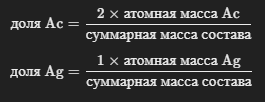

3. Использование метода встраивания (embedding)
Если имеется большое количество химических элементов, можно использовать встраивание (embedding) для преобразования состава в более компактное числовое представление. Это особенно полезно в задачах с большим числом признаков и сложных многокомпонентных структурах.

    Подход:
    Построить модель встраивания для элементов, основываясь на их химических и физических свойствах.
    Использовать вектора встраивания для каждого элемента, чтобы построить более компактное представление химической формулы.






#### OneHot кодирование 119 новых признаков по наличию всех элементов

Принято решение перевести химсостав в дамми переменные и сформировать отдельное поле для каждого хим элемента

In [148]:
def onehot_formula(formula):
    '''Функция готовит one-hot вектор представляет собой набор признаков по каждому элементу таблицы Менделеева'''
    # преобразование строки с химической формулой в объект Composition из библиотеки pymatgen
    if pd.isna(formula):
        formula = Composition('NaN') # обрабатываем исключение для вещества (Na N)
    else:
        formula = Composition(formula)
    # Метод get_integer_formula_and_factor() возвращает формулу в нужном виде
    int_form = formula.get_integer_formula_and_factor()[0]
    # Получаем словарь, в качестве ключа элемент, значение - количество атомов
    int_form = Composition(int_form).as_dict()
    # int_form = dict(int_form)  # похоже лишняя строка
    l = []
    for key,value in int_form.items():
        l.extend([Element(key).Z] * int(value))
    l = torch.tensor(l).to(torch.int64)  # Преобразуем в целочисленный тензор
    return F.one_hot(l, num_classes=119).sum(dim=0).reshape(1,-1) # Убираем .to(torch.float32)


In [149]:
df_limit.formula[:5]

0         Ac
1    Ac2AgIr
2    Ac2CdSn
3    Ac2CuGe
4    Ac2CuIr
Name: formula, dtype: object

In [150]:
# x = df_limit.formula[:5].apply(lambda x: onehot_formula(x).numpy())

In [151]:
df_limit.formula.apply(lambda x: onehot_formula(x).numpy()[0])

c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\pymatgen\core\periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                             ...                        
995    [0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, ...
996    [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, ...
997    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, ...
998    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
999    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, ...
Name: formula, Length: 1000, dtype: object

In [152]:
# Формируем поле onehot_vector
# Применение функции onehot_formula для каждой химической формулы
df_limit['onehot_vector'] = df_limit.formula.apply(lambda x: onehot_formula(x).numpy()[0])

In [153]:
# Преобразование one-hot вектора в отдельные признаки
# Колонки будут названы по номерам элементов
element_columns = [f'El_{i}' for i in range(1, 120)]  # От 1 до 119 (периодическая таблица)
element_columns

['El_1',
 'El_2',
 'El_3',
 'El_4',
 'El_5',
 'El_6',
 'El_7',
 'El_8',
 'El_9',
 'El_10',
 'El_11',
 'El_12',
 'El_13',
 'El_14',
 'El_15',
 'El_16',
 'El_17',
 'El_18',
 'El_19',
 'El_20',
 'El_21',
 'El_22',
 'El_23',
 'El_24',
 'El_25',
 'El_26',
 'El_27',
 'El_28',
 'El_29',
 'El_30',
 'El_31',
 'El_32',
 'El_33',
 'El_34',
 'El_35',
 'El_36',
 'El_37',
 'El_38',
 'El_39',
 'El_40',
 'El_41',
 'El_42',
 'El_43',
 'El_44',
 'El_45',
 'El_46',
 'El_47',
 'El_48',
 'El_49',
 'El_50',
 'El_51',
 'El_52',
 'El_53',
 'El_54',
 'El_55',
 'El_56',
 'El_57',
 'El_58',
 'El_59',
 'El_60',
 'El_61',
 'El_62',
 'El_63',
 'El_64',
 'El_65',
 'El_66',
 'El_67',
 'El_68',
 'El_69',
 'El_70',
 'El_71',
 'El_72',
 'El_73',
 'El_74',
 'El_75',
 'El_76',
 'El_77',
 'El_78',
 'El_79',
 'El_80',
 'El_81',
 'El_82',
 'El_83',
 'El_84',
 'El_85',
 'El_86',
 'El_87',
 'El_88',
 'El_89',
 'El_90',
 'El_91',
 'El_92',
 'El_93',
 'El_94',
 'El_95',
 'El_96',
 'El_97',
 'El_98',
 'El_99',
 'El_100',
 'El_101

In [154]:
# Разбиваем вектор на отдельные колонки и добавляем их в DataFrame
df_onehot = pd.DataFrame(df_limit['onehot_vector'].to_list(), columns = element_columns)

In [155]:
# смотрим
df_onehot.head(3)

,El_1,El_2,El_3,El_4,El_5,El_6,El_7,El_8,El_9,El_10,El_11,El_12,El_13,El_14,El_15,El_16,El_17,El_18,El_19,El_20,El_21,El_22,El_23,El_24,El_25,El_26,El_27,El_28,El_29,El_30,El_31,El_32,El_33,El_34,El_35,El_36,El_37,El_38,El_39,El_40,El_41,El_42,El_43,El_44,El_45,El_46,El_47,El_48,El_49,El_50,El_51,El_52,El_53,El_54,El_55,El_56,El_57,El_58,El_59,El_60,El_61,El_62,El_63,El_64,El_65,El_66,El_67,El_68,El_69,El_70,El_71,El_72,El_73,El_74,El_75,El_76,El_77,El_78,El_79,El_80,El_81,El_82,El_83,El_84,El_85,El_86,El_87,El_88,El_89,El_90,El_91,El_92,El_93,El_94,El_95,El_96,El_97,El_98,El_99,El_100,El_101,El_102,El_103,El_104,El_105,El_106,El_107,El_108,El_109,El_110,El_111,El_112,El_113,El_114,El_115,El_116,El_117,El_118,El_119
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


На будущее можно проработать возможности библиотеки Matmaner для OneHot кодирования.

**Matminer** — это библиотека Python, специально разработанная для автоматизации процесса извлечения и создания новых признаков для материалов. Она интегрируется с такими библиотеками, как **pymatgen**, и предоставляет удобный интерфейс для генерации большого количества полезных признаков (features) на основе различных данных о материалах, включая информацию о структуре, химическом составе и других свойствах.

 Возможности **Matminer**:

1. **Извлечение признаков (Feature extraction)**:
   - **Matminer** содержит множество готовых методов для извлечения признаков из материалов, таких как **структурные**, **химические**, **энергетические** и другие.
   - Библиотека поддерживает такие источники данных, как **химическая формула**, **кристаллическая структура**, **поверхности материалов** и **энергетические свойства**.

2. **Автоматизация создания признаков**:
   - Библиотека автоматизирует процесс генерации признаков, что позволяет легко и быстро создать сотни признаков, не требуя от пользователя глубоких знаний в физике или химии.
   - Признаки можно извлекать как для одиночных элементов, так и для сложных кристаллических структур.

3. **Интеграция с pymatgen**:
   - **Matminer** хорошо интегрируется с **pymatgen**, поэтому вы можете использовать существующие объекты **Structure** или **Composition** для создания признаков.

4. **Готовые наборы признаков**:
   - В **matminer** есть несколько наборов признаков (feature sets), которые можно применять к различным типам данных (структуры, составы, энергоемкие данные и т.д.). Эти признаки базируются на известных моделях и эмпирических правилах.



Пример использования **Matminer** для создания новых признаков:

1. **Извлечение признаков из химического состава**:

Для работы с химическим составом можно использовать модуль **`Composition`** и извлечь различные химические и физические свойства.

В этом примере мы использовали несколько готовых featurizers:
- **ElementProperty** — извлекает свойства элементов на основе заранее обученных данных.
- **Stoichiometry** — вычисляет стехиометрические характеристики.
- **ValenceOrbital** — анализирует валентные орбитали элементов.
- **IonProperty** — извлекает свойства, связанные с ионными состояниями.

 2. **Извлечение признаков из кристаллической структуры**:

**Matminer** может извлекать множество признаков, связанных с геометрией кристаллической структуры. Например, для анализа симметрии, координационных чисел, плотности и других свойств.


Здесь мы использовали несколько featurizers:
- **DensityFeatures** — извлекает признаки, связанные с плотностью структуры (массовая плотность, атомная плотность и т.д.).
- **GlobalSymmetryFeatures** — извлекает признаки, связанные с глобальной симметрией структуры (например, группа симметрии).
- **RadialDistributionFunction** — извлекает признаки, связанные с радиальным распределением атомов.

 3. **Извлечение признаков из данных энергетики**:

Вы также можете использовать **matminer** для извлечения признаков на основе энергетических характеристик материала, таких как энергия Гиббса, энергия связи и другие.

 4. **Извлечение сложных признаков (compound-based)**:

Matminer также позволяет генерировать более сложные признаки, комбинируя данные о химическом составе и структуре. Это полезно для прогнозирования таких свойств, как термодинамическая стабильность, механические свойства и т.д.

Основные featurizers в **Matminer**:

- **`Composition`**: для химических составов (примеры: атомные массы, электроотрицательности, радиусы).
- **`Structure`**: для кристаллических структур (примеры: симметрия, координационные числа, плотность).
- **`Bandstructure`** и **`DOS`**: для энергетических характеристик (примеры: электронные свойства, плотность состояний).

Преимущества **Matminer**:
- **Автоматизация**: Она существенно упрощает процесс создания признаков для задач материаловедения.
- **Гибкость**: Matminer поддерживает работу с данными разных типов, будь то химические формулы или кристаллические структуры.
- **Интеграция**: Библиотека легко интегрируется с **pymatgen** и другими популярными инструментами для анализа материалов.

 Итог:
**Matminer** — это мощная библиотека для автоматического создания признаков на основе данных о материалах. Она предлагает различные инструменты для извлечения признаков из химических составов, кристаллических структур и других типов данных. Это значительно упрощает работу по созданию моделей машинного обучения для предсказания свойств материалов.

### Вывод по разделу формирования признака composition

Подготовлен вспомогательный датафрейм df_atomic_mass с указанием атомной массы для каждого элемента таблицы Менделеева.  
Созданы вспомогательные признаки:  
    sum_atomic_mass- суммарная атомная массы для каждой структуры   
    norm_atomic_mass - нормированная суммарная атомная массы для каждой структуры  
Каждый из них позволяет отражать химсостав одним числом.  

Кроме того применено  OneHot кодирование для создания 119 новых признаков по наличию всех элементов

## Собираем итоговый датасет

Осталось обработать целевые признаки

In [156]:
def extract_bulk_modulus(value_str: str, bulk_variance_str: str)-> float:
    '''Получаем значение указанного варианта модуля voigt, reuss или vrh'''
    try:
        # Преобразуем строку в словарь
        value_dict = ast.literal_eval(value_str)
        # извлекаем заданное значение
        return value_dict.get(bulk_variance_str, None)
    except(ValueError, SyntaxError):
        return None # В лучае ошибки возворащаем None

In [157]:
# формируем отдельные признаки по каждому типу bulk_modulus
df_detailed['bulk_modulus_voigt'] = [extract_bulk_modulus(str(i), 'voigt') for i in df_limit.bulk_modulus]
df_detailed['bulk_modulus_reuss'] = [extract_bulk_modulus(str(i), 'reuss') for i in df_limit.bulk_modulus]
df_detailed['bulk_modulus_vrh'] = [extract_bulk_modulus(str(i), 'vrh') for i in df_limit.bulk_modulus]

In [158]:
# перенесем в df_detailed недостающие признаки
df_detailed['e_above_hull'] = df_limit['e_above_hull']
df_detailed['density'] = df_limit['density']

In [159]:
# удалим лишние столбцы
df_detailed = df_detailed.drop(columns=['composition', 'pbc', 'atomic_positions_frac', 'atomic_positions_cart'])

In [160]:
df_detailed.tail(2)

,lattice_a,lattice_b,lattice_c,angle_alpha,angle_beta,angle_gamma,cell_volume,pbc_a,pbc_b,pbc_c,count_atoms,atom_coord_cart_mean_x,atom_coord_cart_mean_y,atom_coord_cart_mean_z,atom_coord_cart_std_x,atom_coord_cart_std_y,atom_coord_cart_std_z,atom_coord_cart_min_x,atom_coord_cart_min_y,atom_coord_cart_min_z,atom_coord_cart_max_x,atom_coord_cart_max_y,atom_coord_cart_max_z,interatomic_distance_avg,interatomic_distance_std,interatomic_distance_min,interatomic_distance_max,atom_coord_relative_mean_x,atom_coord_relative_mean_y,atom_coord_relative_mean_z,atom_coord_relative_std_x,atom_coord_relative_std_y,atom_coord_relative_std_z,atom_coord_relative_min_x,atom_coord_relative_min_y,atom_coord_relative_min_z,atom_coord_relative_max_x,atom_coord_relative_max_y,atom_coord_relative_max_z,atom_coord_frac_mean_x,atom_coord_frac_mean_y,atom_coord_frac_mean_z,atom_coord_frac_std_x,atom_coord_frac_std_y,atom_coord_frac_std_z,atom_coord_frac_min_x,atom_coord_frac_min_y,atom_coord_frac_min_z,atom_coord_frac_max_x,atom_coord_frac_max_y,atom_coord_frac_max_z,coord_numb_mean,coord_numb_std,coord_numb_min,coord_numb_max,sum_atomic_mass,norm_atomic_mass,bulk_modulus_voigt,bulk_modulus_reuss,bulk_modulus_vrh,e_above_hull,density
998,6.345628,6.345629,6.345629,109.471218,109.471220,109.471224,196.698948,True,True,True,11,0.815825,1.413050,0.576876,1.702760,1.428487,1.764681,-1.824582,0.0,-2.115209,3.649164,3.91235,3.870524,4.020775,1.245919,2.316525,6.691578,-1.614870e-16,0.000000e+00,-1.211152e-16,1.702760,1.428487,1.764681,-2.640407,-1.413050,-2.692085,2.833340,2.499300,3.293648,0.272727,0.272727,0.272727,0.275707,0.275707,0.275707,0.0,0.0,-0.0,0.755107,0.755107,0.755107,10.545455,0.890724,10,12,633.8996,57.627236,70.012,49.084,59.548,0.0,5.351402
999,6.436035,6.436034,6.436034,109.471218,109.471215,109.471220,205.226380,True,True,True,11,0.827448,1.433182,0.585094,1.926581,1.431026,2.031670,-2.189294,0.0,-2.145344,4.378590,3.79197,4.644196,4.406756,1.527225,2.286028,7.583940,-8.074349e-17,1.614870e-16,-1.614870e-16,1.926581,1.431026,2.031670,-3.016743,-1.433182,-2.730438,3.551142,2.358788,4.059101,0.272727,0.272727,0.272727,0.272317,0.272317,0.272317,0.0,-0.0,-0.0,0.721593,0.721593,0.721593,7.272727,0.445362,7,8,1001.4440,91.040364,131.909,131.909,131.909,0.0,8.102939


In [161]:
df_detailed.columns

Index(['lattice_a', 'lattice_b', 'lattice_c', 'angle_alpha', 'angle_beta',
       'angle_gamma', 'cell_volume', 'pbc_a', 'pbc_b', 'pbc_c', 'count_atoms',
       'atom_coord_cart_mean_x', 'atom_coord_cart_mean_y',
       'atom_coord_cart_mean_z', 'atom_coord_cart_std_x',
       'atom_coord_cart_std_y', 'atom_coord_cart_std_z',
       'atom_coord_cart_min_x', 'atom_coord_cart_min_y',
       'atom_coord_cart_min_z', 'atom_coord_cart_max_x',
       'atom_coord_cart_max_y', 'atom_coord_cart_max_z',
       'interatomic_distance_avg', 'interatomic_distance_std',
       'interatomic_distance_min', 'interatomic_distance_max',
       'atom_coord_relative_mean_x', 'atom_coord_relative_mean_y',
       'atom_coord_relative_mean_z', 'atom_coord_relative_std_x',
       'atom_coord_relative_std_y', 'atom_coord_relative_std_z',
       'atom_coord_relative_min_x', 'atom_coord_relative_min_y',
       'atom_coord_relative_min_z', 'atom_coord_relative_max_x',
       'atom_coord_relative_max_y', 'atom_coord

In [162]:
df_detailed.shape

(1000, 62)

In [163]:
df_onehot.shape

(1000, 119)

In [164]:
# объединяем необходимые датафреймы в полный финальный датафрейм
df_full = pd.concat([df_detailed, df_onehot], axis=1)

In [165]:
print(list(df_full.columns))

['lattice_a', 'lattice_b', 'lattice_c', 'angle_alpha', 'angle_beta', 'angle_gamma', 'cell_volume', 'pbc_a', 'pbc_b', 'pbc_c', 'count_atoms', 'atom_coord_cart_mean_x', 'atom_coord_cart_mean_y', 'atom_coord_cart_mean_z', 'atom_coord_cart_std_x', 'atom_coord_cart_std_y', 'atom_coord_cart_std_z', 'atom_coord_cart_min_x', 'atom_coord_cart_min_y', 'atom_coord_cart_min_z', 'atom_coord_cart_max_x', 'atom_coord_cart_max_y', 'atom_coord_cart_max_z', 'interatomic_distance_avg', 'interatomic_distance_std', 'interatomic_distance_min', 'interatomic_distance_max', 'atom_coord_relative_mean_x', 'atom_coord_relative_mean_y', 'atom_coord_relative_mean_z', 'atom_coord_relative_std_x', 'atom_coord_relative_std_y', 'atom_coord_relative_std_z', 'atom_coord_relative_min_x', 'atom_coord_relative_min_y', 'atom_coord_relative_min_z', 'atom_coord_relative_max_x', 'atom_coord_relative_max_y', 'atom_coord_relative_max_z', 'atom_coord_frac_mean_x', 'atom_coord_frac_mean_y', 'atom_coord_frac_mean_z', 'atom_coord_fra

In [166]:
# смотрим все признаки
for i in list(df_full.columns):
    print(i)

lattice_a
lattice_b
lattice_c
angle_alpha
angle_beta
angle_gamma
cell_volume
pbc_a
pbc_b
pbc_c
count_atoms
atom_coord_cart_mean_x
atom_coord_cart_mean_y
atom_coord_cart_mean_z
atom_coord_cart_std_x
atom_coord_cart_std_y
atom_coord_cart_std_z
atom_coord_cart_min_x
atom_coord_cart_min_y
atom_coord_cart_min_z
atom_coord_cart_max_x
atom_coord_cart_max_y
atom_coord_cart_max_z
interatomic_distance_avg
interatomic_distance_std
interatomic_distance_min
interatomic_distance_max
atom_coord_relative_mean_x
atom_coord_relative_mean_y
atom_coord_relative_mean_z
atom_coord_relative_std_x
atom_coord_relative_std_y
atom_coord_relative_std_z
atom_coord_relative_min_x
atom_coord_relative_min_y
atom_coord_relative_min_z
atom_coord_relative_max_x
atom_coord_relative_max_y
atom_coord_relative_max_z
atom_coord_frac_mean_x
atom_coord_frac_mean_y
atom_coord_frac_mean_z
atom_coord_frac_std_x
atom_coord_frac_std_y
atom_coord_frac_std_z
atom_coord_frac_min_x
atom_coord_frac_min_y
atom_coord_frac_min_z
atom_coord

### Выбор целевого признака

Для выбора целевого признака из предложенных — bulk_modulus_voigt, bulk_modulus_reuss, bulk_modulus_vrh — нужно учитывать, что эти три характеристики связаны с одним и тем же физическим понятием — модулем объемной упругости, но получены разными методами:

bulk_modulus_voigt — модуль объемной упругости, рассчитанный по методу Фойгта, который предполагает, что деформация в кристаллическом материале распределена равномерно. Это оптимистичный (или верхний) предел для модуля.

bulk_modulus_reuss — модуль объемной упругости, рассчитанный по методу Ройса, который предполагает, что напряжение в материале распределено равномерно. Это пессимистичный (или нижний) предел для модуля.

bulk_modulus_vrh — среднее значение между модулями Фойгта и Ройса, известное как метод Воигта-Ройса-Хилла (VRH). Это взвешенное среднее значение, которое часто считается более реалистичным и точным для оценки модулей упругости материалов, поскольку оно сочетает два подхода.

Как выбрать целевой признак:
Физическая корректность и реализм:

bulk_modulus_vrh является наиболее реалистичной и сбалансированной оценкой модуля упругости, так как учитывает как верхний (Фойгт), так и нижний (Ройс) пределы. Он часто используется как более надежный показатель для предсказания реальных свойств материала, что делает его предпочтительным для многих задач машинного обучения или моделирования материалов.
Стабильность предсказаний:

Среднее значение (VRH) обычно более стабильно и менее чувствительно к экстремальным значениям, чем отдельные оценки по методам Фойгта и Ройса. Это может улучшить качество моделей, основанных на данных, если есть вариативность в исходных данных.
Конкретная задача:

Если задача ориентирована на определенные условия, например, моделирование в условиях равномерного напряжения или деформации, то можно выбрать либо Voigt, либо Reuss. Однако, если цель — наиболее общий и реалистичный модуль, выбором будет VRH.
Рекомендация:
bulk_modulus_vrh является лучшим выбором для целевого признака, так как он представляет собой сбалансированное значение и чаще всего используется для обобщенной оценки упругих свойств материалов.

In [167]:
# распределим все признаки на удобные места, из целевых признаков оставим только bulk_modulus_vrh
df_full = df_full[[
   'e_above_hull', 
   'density',
   'cell_volume',
   'count_atoms', 
   'sum_atomic_mass', 
   'norm_atomic_mass', 
      
   'lattice_a', 'lattice_b', 'lattice_c', 
   'angle_alpha', 'angle_beta', 'angle_gamma', 
   
   'pbc_a', 'pbc_b', 'pbc_c', 
   
   'atom_coord_cart_mean_x', 'atom_coord_cart_mean_y', 'atom_coord_cart_mean_z', 'atom_coord_cart_std_x', 'atom_coord_cart_std_y', 'atom_coord_cart_std_z', 'atom_coord_cart_min_x', 'atom_coord_cart_min_y', 'atom_coord_cart_min_z', 'atom_coord_cart_max_x', 'atom_coord_cart_max_y', 'atom_coord_cart_max_z', 
   'interatomic_distance_avg', 'interatomic_distance_std', 'interatomic_distance_min', 'interatomic_distance_max', 
   'atom_coord_relative_mean_x', 'atom_coord_relative_mean_y', 'atom_coord_relative_mean_z', 'atom_coord_relative_std_x', 'atom_coord_relative_std_y', 'atom_coord_relative_std_z', 'atom_coord_relative_min_x', 'atom_coord_relative_min_y', 'atom_coord_relative_min_z', 'atom_coord_relative_max_x', 'atom_coord_relative_max_y', 'atom_coord_relative_max_z', 
   'atom_coord_frac_mean_x', 'atom_coord_frac_mean_y', 'atom_coord_frac_mean_z', 'atom_coord_frac_std_x', 'atom_coord_frac_std_y', 'atom_coord_frac_std_z', 'atom_coord_frac_min_x', 'atom_coord_frac_min_y', 'atom_coord_frac_min_z', 'atom_coord_frac_max_x', 'atom_coord_frac_max_y', 'atom_coord_frac_max_z', 
   'coord_numb_mean', 'coord_numb_std', 'coord_numb_min', 'coord_numb_max', 

   'El_1', 'El_2', 'El_3', 'El_4', 'El_5', 'El_6', 'El_7', 'El_8', 'El_9', 'El_10', 'El_11', 'El_12', 'El_13', 'El_14', 'El_15', 'El_16', 'El_17', 'El_18', 'El_19', 'El_20', 'El_21', 'El_22', 'El_23', 'El_24', 'El_25', 'El_26', 'El_27', 'El_28', 'El_29', 'El_30', 'El_31', 'El_32', 'El_33', 'El_34', 'El_35', 'El_36', 'El_37', 'El_38', 'El_39', 'El_40', 'El_41', 'El_42', 'El_43', 'El_44', 'El_45', 'El_46', 'El_47', 'El_48', 'El_49', 'El_50', 'El_51', 'El_52', 'El_53', 'El_54', 'El_55', 'El_56', 'El_57', 'El_58', 'El_59', 'El_60', 'El_61', 'El_62', 'El_63', 'El_64', 'El_65', 'El_66', 'El_67', 'El_68', 'El_69', 'El_70', 'El_71', 'El_72', 'El_73', 'El_74', 'El_75', 'El_76', 'El_77', 'El_78', 'El_79', 'El_80', 'El_81', 'El_82', 'El_83', 'El_84', 'El_85', 'El_86', 'El_87', 'El_88', 'El_89', 'El_90', 'El_91', 'El_92', 'El_93', 'El_94', 'El_95', 'El_96', 'El_97', 'El_98', 'El_99', 'El_100', 'El_101', 'El_102', 'El_103', 'El_104', 'El_105', 'El_106', 'El_107', 'El_108', 'El_109', 'El_110', 'El_111', 'El_112', 'El_113', 'El_114', 'El_115', 'El_116', 'El_117', 'El_118', 'El_119',
   'bulk_modulus_vrh']]

In [168]:
df_full.tail(3)

,e_above_hull,density,cell_volume,count_atoms,sum_atomic_mass,norm_atomic_mass,lattice_a,lattice_b,lattice_c,angle_alpha,angle_beta,angle_gamma,pbc_a,pbc_b,pbc_c,atom_coord_cart_mean_x,atom_coord_cart_mean_y,atom_coord_cart_mean_z,atom_coord_cart_std_x,atom_coord_cart_std_y,atom_coord_cart_std_z,atom_coord_cart_min_x,atom_coord_cart_min_y,atom_coord_cart_min_z,atom_coord_cart_max_x,atom_coord_cart_max_y,atom_coord_cart_max_z,interatomic_distance_avg,interatomic_distance_std,interatomic_distance_min,interatomic_distance_max,atom_coord_relative_mean_x,atom_coord_relative_mean_y,atom_coord_relative_mean_z,atom_coord_relative_std_x,atom_coord_relative_std_y,atom_coord_relative_std_z,atom_coord_relative_min_x,atom_coord_relative_min_y,atom_coord_relative_min_z,atom_coord_relative_max_x,atom_coord_relative_max_y,atom_coord_relative_max_z,atom_coord_frac_mean_x,atom_coord_frac_mean_y,atom_coord_frac_mean_z,atom_coord_frac_std_x,atom_coord_frac_std_y,atom_coord_frac_std_z,atom_coord_frac_min_x,atom_coord_frac_min_y,atom_coord_frac_min_z,atom_coord_frac_max_x,atom_coord_frac_max_y,atom_coord_frac_max_z,coord_numb_mean,coord_numb_std,coord_numb_min,coord_numb_max,El_1,El_2,El_3,El_4,El_5,El_6,El_7,El_8,El_9,El_10,El_11,El_12,El_13,El_14,El_15,El_16,El_17,El_18,El_19,El_20,El_21,El_22,El_23,El_24,El_25,El_26,El_27,El_28,El_29,El_30,El_31,El_32,El_33,El_34,El_35,El_36,El_37,El_38,El_39,El_40,El_41,El_42,El_43,El_44,El_45,El_46,El_47,El_48,El_49,El_50,El_51,El_52,El_53,El_54,El_55,El_56,El_57,El_58,El_59,El_60,El_61,El_62,El_63,El_64,El_65,El_66,El_67,El_68,El_69,El_70,El_71,El_72,El_73,El_74,El_75,El_76,El_77,El_78,El_79,El_80,El_81,El_82,El_83,El_84,El_85,El_86,El_87,El_88,El_89,El_90,El_91,El_92,El_93,El_94,El_95,El_96,El_97,El_98,El_99,El_100,El_101,El_102,El_103,El_104,El_105,El_106,El_107,El_108,El_109,El_110,El_111,El_112,El_113,El_114,El_115,El_116,El_117,El_118,El_119,bulk_modulus_vrh
997,0.0,3.050884,173.885396,7,319.477077,45.639582,4.108458,4.571991,9.754448,103.564379,102.157162,89.999999,True,True,True,1.903513,1.902555,3.291375,1.167131,1.141779,2.641211,0.141584,0.0,-0.429185,3.630314,3.619924,7.160232,4.457966,1.619933,2.502904,7.994682,-1.268826e-16,3.172066e-17,2.537653e-16,1.167131,1.141779,2.641211,-1.761929,-1.902555,-3.720560,1.726801,1.717369,3.868856,0.500000,0.428571,0.428571,0.295815,0.257231,0.292550,0.068191,-0.0,-0.0,0.931809,0.815468,0.863619,8.285714,1.749636,7,12,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45.848
998,0.0,5.351402,196.698948,11,633.899600,57.627236,6.345628,6.345629,6.345629,109.471218,109.471220,109.471224,True,True,True,0.815825,1.413050,0.576876,1.702760,1.428487,1.764681,-1.824582,0.0,-2.115209,3.649164,3.912350,3.870524,4.020775,1.245919,2.316525,6.691578,-1.614870e-16,0.000000e+00,-1.211152e-16,1.702760,1.428487,1.764681,-2.640407,-1.413050,-2.692085,2.833340,2.499300,3.293648,0.272727,0.272727,0.272727,0.275707,0.275707,0.275707,0.000000,0.0,-0.0,0.755107,0.755107,0.755107,10.545455,0.890724,10,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,4,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59.548
999,0.0,8.102939,205.226380,11,1001.444000,91.040364,6.436035,6.436034,6.436034,109.471218,109.471215,109.471220,True,True,True,0.827448,1.433182,0.585094,1.926581,1.431026,2.031670,-2.189294,0.0,-2.145344,4.378590,3.791970,4.644196,4.406756,1.527225,2.286028,7.583940,-8.074349e-17,1.614870e-16,-1.614870e-16,1.926581,1.431026,2.031670,-3.016743,-1.433182,-2.730438,3.551142,2.358788,4.059101,0.272727,0.272727,0.272727,0.272317,0.272317,0.272317,0.000000,-0.0,-0.0,0.721593,0.721593,0.721593,7.272727,0.445362,7,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,0,0

### Сохраним и загрузим файл df_full

In [169]:
# Данный раздел закомментирован, т.к. ссылки индивидуальны для каждого пользователя
# PATH = r'C:\Users\lazarevnv\Desktop\materials_science\code_materials\first_ml_task_ung_modul\df_full_csv.csv'
# df_full.to_csv(PATH,  index=False, encoding='utf-8', sep=';', )

In [311]:
# PATH = r'C:\Users\lazarevnv\Desktop\materials_science\code_materials\first_ml_task_ung_modul\df_full_csv.csv'
# df_full = pd.read_csv(PATH, encoding='utf-8', sep=';')

Поскольку выгрузка из базы данных может со временем корректироваться, для сохранения параметров модели в данном разделе зафикирована загрузка промежуточного датафрейма для дальнейшей обработки и прогнозирования. Это важно для получения заявленных параметров модели.

In [441]:
# Файл df_full_csv.csv прилагается совместно с файлом моделирования. Обратите внимание на адрес.
PATH = 'df_full_csv.csv'
df_full = pd.read_csv(PATH, encoding='utf-8', sep=';')

In [443]:
df_full.tail(3)

,e_above_hull,density,cell_volume,count_atoms,sum_atomic_mass,norm_atomic_mass,lattice_a,lattice_b,lattice_c,angle_alpha,angle_beta,angle_gamma,pbc_a,pbc_b,pbc_c,atom_coord_cart_mean_x,atom_coord_cart_mean_y,atom_coord_cart_mean_z,atom_coord_cart_std_x,atom_coord_cart_std_y,atom_coord_cart_std_z,atom_coord_cart_min_x,atom_coord_cart_min_y,atom_coord_cart_min_z,atom_coord_cart_max_x,atom_coord_cart_max_y,atom_coord_cart_max_z,interatomic_distance_avg,interatomic_distance_std,interatomic_distance_min,interatomic_distance_max,atom_coord_relative_mean_x,atom_coord_relative_mean_y,atom_coord_relative_mean_z,atom_coord_relative_std_x,atom_coord_relative_std_y,atom_coord_relative_std_z,atom_coord_relative_min_x,atom_coord_relative_min_y,atom_coord_relative_min_z,atom_coord_relative_max_x,atom_coord_relative_max_y,atom_coord_relative_max_z,atom_coord_frac_mean_x,atom_coord_frac_mean_y,atom_coord_frac_mean_z,atom_coord_frac_std_x,atom_coord_frac_std_y,atom_coord_frac_std_z,atom_coord_frac_min_x,atom_coord_frac_min_y,atom_coord_frac_min_z,atom_coord_frac_max_x,atom_coord_frac_max_y,atom_coord_frac_max_z,coord_numb_mean,coord_numb_std,coord_numb_min,coord_numb_max,El_1,El_2,El_3,El_4,El_5,El_6,El_7,El_8,El_9,El_10,El_11,El_12,El_13,El_14,El_15,El_16,El_17,El_18,El_19,El_20,El_21,El_22,El_23,El_24,El_25,El_26,El_27,El_28,El_29,El_30,El_31,El_32,El_33,El_34,El_35,El_36,El_37,El_38,El_39,El_40,El_41,El_42,El_43,El_44,El_45,El_46,El_47,El_48,El_49,El_50,El_51,El_52,El_53,El_54,El_55,El_56,El_57,El_58,El_59,El_60,El_61,El_62,El_63,El_64,El_65,El_66,El_67,El_68,El_69,El_70,El_71,El_72,El_73,El_74,El_75,El_76,El_77,El_78,El_79,El_80,El_81,El_82,El_83,El_84,El_85,El_86,El_87,El_88,El_89,El_90,El_91,El_92,El_93,El_94,El_95,El_96,El_97,El_98,El_99,El_100,El_101,El_102,El_103,El_104,El_105,El_106,El_107,El_108,El_109,El_110,El_111,El_112,El_113,El_114,El_115,El_116,El_117,El_118,El_119,bulk_modulus_vrh
997,0.0,12.711736,112.406411,6,860.492000,143.415333,5.417123,5.417123,5.417123,60.000002,60.000001,60.000005,True,True,True,1.563789,1.105766,2.708561,1.427537,1.150917,2.211531,0.000000,0.000000e+00,0.0,3.909472,2.764414,6.771403,4.080312,1.777378,2.708561,8.293242,-1.480297e-16,0.000000e+00,6.661338e-16,1.427537,1.150917,2.211531,-1.563789,-1.105766,-2.708561,2.345683,1.658648,4.062842,0.250000,0.250000,0.2500,0.260208,0.260208,0.260208,0.0,0.0,0.0,0.625000,0.625000,0.62500,12.0,0.000000,12,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,132.905
998,0.0,15.447910,109.158723,6,1015.498000,169.249667,5.355657,5.355658,4.394427,90.000000,90.000000,120.000005,True,True,True,0.892609,1.546045,1.098607,1.480226,1.180812,1.098607,-1.338915,-5.000000e-09,0.0,2.677831,3.092092,2.197214,3.312982,0.725071,2.677828,4.643228,-7.401487e-17,-1.110223e-16,0.000000e+00,1.480226,1.180812,1.098607,-2.231524,-1.546045,-1.098607,1.785222,1.546047,1.098607,0.333333,0.333333,0.2500,0.254588,0.254588,0.250000,-0.0,0.0,0.0,0.666667,0.666667,0.50000,10.0,5.385165,3,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,167.886
999,0.0,4.999452,115.968968,8,349.152419,43.644052,5.802000,5.802000,5.802001,53.157309,53.157301,53.157306,True,True,True,2.824612,1.913718,5.556137,1.555027,1.339734,2.392409,0.000000,0.000000e+00,0.0,4.745834,4.036407,8.283494,4.260466,2.135579,2.269672,8.974016,-3.330669e-16,1.110223e-16,-3.330669e-16,1.555027,1.339734,2.392409,-2.824612,-1.913718,-5.556137,1.921222,2.122688,2.727357,0.437500,0.437500,0.4375,0.309778,0.309778,0.309778,-0.0,0.0,0.0,0.928620,0.928620,0.92862,3.0,1.732051,2,6,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Выводы по разделу

В качестве вывода ещё раз опишем все признаки, которые в итоге получили, убрали лишние, и взяли в нужном порядке.

Общие признаки структуры:

'e_above_hull' — энергия выше кривой устойчивости  
'density' — плотность материала  
'cell_volume' — объем элементарной ячейки кристалла  
'count_atoms' — количество атомов в структуре  
'lattice_a', 'lattice_b', 'lattice_c', — длины векторов решетки  
'angle_alpha', 'angle_beta', 'angle_gamma'  — углы между векторами решетки  
'pbc_a', 'pbc_b', 'pbc_c' — периодические граничные условия   
'sum_atomic_mass' — суммарная атомная массы структуры  
'norm_atomic_mass' — нормированная суммарная атомная массы структуры  
    

Признаки картезианских атомных координат:  
'atom_coord_cart_mean_x', 'atom_coord_cart_mean_y', 'atom_coord_cart_mean_z', 'atom_coord_cart_std_x',   'atom_coord_cart_std_y', 'atom_coord_cart_std_z', 'atom_coord_cart_min_x', 'atom_coord_cart_min_y',   'atom_coord_cart_min_z', 'atom_coord_cart_max_x', 'atom_coord_cart_max_y', 'atom_coord_cart_max_z',  


Признаки межатомных расстояний:  
'interatomic_distance_avg' - среднее межатомное расстояние  
'interatomic_distance_std' - стандартное отклонение межатомного расстояния  
 
Минимальное и максимальное межатомное расстояние:
'interatomic_distance_min', 'interatomic_distance_max'

Относительные межатомные расстояния относительно центра масс:  
'atom_coord_relative_mean_x', 'atom_coord_relative_mean_y', 'atom_coord_relative_mean_z',   
'atom_coord_relative_std_x', 'atom_coord_relative_std_y', 'atom_coord_relative_std_z',   
'atom_coord_relative_min_x', 'atom_coord_relative_min_y', 'atom_coord_relative_min_z',   
'atom_coord_relative_max_x', 'atom_coord_relative_max_y', 'atom_coord_relative_max_z'   

Признаки агрегации дробных координат:  
'atom_coord_frac_mean_x', 'atom_coord_frac_mean_y', 'atom_coord_frac_mean_z', 'atom_coord_frac_std_x',   'atom_coord_frac_std_y', 'atom_coord_frac_std_z', 'atom_coord_frac_min_x', 'atom_coord_frac_min_y',   'atom_coord_frac_min_z', 'atom_coord_frac_max_x', 'atom_coord_frac_max_y', 'atom_coord_frac_max_z'

Признаки координационных чисел в структуре:  
'coord_numb_mean', 'coord_numb_std', 'coord_numb_min', 'coord_numb_max'  

Количество атомов химэлементов в структуре:  
'El_1', 'El_2', 'El_3', 'El_4', 'El_5', 'El_6', 'El_7', 'El_8', 'El_9', 'El_10', 'El_11', 'El_12', 'El_13', 'El_14', 'El_15', 'El_16', 'El_17', 'El_18', 'El_19', 'El_20', 'El_21', 'El_22', 'El_23', 'El_24', 'El_25', 'El_26', 'El_27', 'El_28', 'El_29', 'El_30', 'El_31', 'El_32', 'El_33', 'El_34', 'El_35', 'El_36', 'El_37', 'El_38', 'El_39', 'El_40', 'El_41', 'El_42', 'El_43', 'El_44', 'El_45', 'El_46', 'El_47', 'El_48', 'El_49', 'El_50', 'El_51', 'El_52', 'El_53', 'El_54', 'El_55', 'El_56', 'El_57', 'El_58', 'El_59', 'El_60', 'El_61', 'El_62', 'El_63', 'El_64', 'El_65', 'El_66', 'El_67', 'El_68', 'El_69', 'El_70', 'El_71', 'El_72', 'El_73', 'El_74', 'El_75', 'El_76', 'El_77', 'El_78', 'El_79', 'El_80', 'El_81', 'El_82', 'El_83', 'El_84', 'El_85', 'El_86', 'El_87', 'El_88', 'El_89', 'El_90', 'El_91', 'El_92', 'El_93', 'El_94', 'El_95', 'El_96', 'El_97', 'El_98', 'El_99', 'El_100', 'El_101', 'El_102', 'El_103', 'El_104', 'El_105', 'El_106', 'El_107', 'El_108', 'El_109', 'El_110', 'El_111', 'El_112', 'El_113', 'El_114', 'El_115', 'El_116', 'El_117', 'El_118', 'El_119', 

'bulk_modulus_vrh' - целевой признак, объемный модуль упругости


## Анализ данных

Даже если данные взяты из уважаемой и авторитетной базы данных, как Materials Project, анализ выбросов, пропусков и дубликатов — это важный шаг для обеспечения чистоты и качества данных перед построением модели.

Особенности анализа данных из базы Materials Project

Расчеты и ошибки моделирования: Данные в Materials Project основаны на моделировании (например, DFT), и поэтому могут содержать численные ошибки или неточные расчеты. Некоторые параметры могут быть предсказаны неточно или некорректно (например, отрицательный объемный модуль).
Неоднородность данных: Различные материалы могут иметь сильно различающиеся физические и химические свойства, что может приводить к неоднородности распределения признаков. Это еще одна причина проводить анализ выбросов.

Анализ редких случаев: Некоторые записи в данных могут быть редкими материалами с уникальными свойствами, которые сильно отличаются от других материалов в датасете. Такие материалы можно обрабатывать отдельно, чтобы не влиять на общую модель.


In [444]:
def hist_boxplot(data, title, figsize=(18,5)):
    
    '''Метод построения диаграммы распределения'''
    fig, axs = plt.subplots(1, 2, figsize=figsize, gridspec_kw={"width_ratios": [4, 1]})
    plt.suptitle(('Признак '+title), 
                  y=1.05, 
                  fontsize=19, 
                  fontweight='bold')
    sns.histplot(data, bins=50, ax=axs[0], kde=True, stat="density",color='green')
    y = np.linspace(0, 0.014, 10)
    axs[0].axvline(data.mean(), color='r', linestyle='dashed', linewidth=3, label='mean')
    axs[0].axvline(data.median(), color='b', linestyle='solid', linewidth=3, label='median')
    axs[0].set_ylabel('Количество')
    axs[0].set_xlabel('Значения')
    axs[0].legend(bbox_to_anchor=(1.0, 1), loc='best')
    axs[0].set_title(('Диаграмма распределения ' + title), fontsize=15)


    '''Диаграмма размаха'''
    sns.boxplot(data=data, palette={'lightgreen'})\
          #  .set(title='Диаграмма размаха Wire 1', xlabel='Признаки', ylabel='Значения')
    axs[1].set_ylabel('Количество')
    axs[1].set_xlabel('Признак')
    axs[1].set_title(('Диаграмма размаха '+title), fontsize=15)
    plt.show()
    return

#### Анализ выбросов (Outliers)

Несмотря на то, что база Materials Project тщательно курируется, выбросы могут возникать из-за ошибок в расчетах, некорректных структур или редких случаев материалов с экстремальными свойствами. Такие выбросы могут существенно влиять на модели машинного обучения, особенно если они чувствительны к масштабу данных (например, линейные модели, метод ближайших соседей, SVM)

In [445]:
# смотрим статистические характеристики данных
df_full.describe()

,e_above_hull,density,cell_volume,count_atoms,sum_atomic_mass,norm_atomic_mass,lattice_a,lattice_b,lattice_c,angle_alpha,angle_beta,angle_gamma,atom_coord_cart_mean_x,atom_coord_cart_mean_y,atom_coord_cart_mean_z,atom_coord_cart_std_x,atom_coord_cart_std_y,atom_coord_cart_std_z,atom_coord_cart_min_x,atom_coord_cart_min_y,atom_coord_cart_min_z,atom_coord_cart_max_x,atom_coord_cart_max_y,atom_coord_cart_max_z,interatomic_distance_avg,interatomic_distance_std,interatomic_distance_min,interatomic_distance_max,atom_coord_relative_mean_x,atom_coord_relative_mean_y,atom_coord_relative_mean_z,atom_coord_relative_std_x,atom_coord_relative_std_y,atom_coord_relative_std_z,atom_coord_relative_min_x,atom_coord_relative_min_y,atom_coord_relative_min_z,atom_coord_relative_max_x,atom_coord_relative_max_y,atom_coord_relative_max_z,atom_coord_frac_mean_x,atom_coord_frac_mean_y,atom_coord_frac_mean_z,atom_coord_frac_std_x,atom_coord_frac_std_y,atom_coord_frac_std_z,atom_coord_frac_min_x,atom_coord_frac_min_y,atom_coord_frac_min_z,atom_coord_frac_max_x,atom_coord_frac_max_y,atom_coord_frac_max_z,coord_numb_mean,coord_numb_std,coord_numb_min,coord_numb_max,El_1,El_2,El_3,El_4,El_5,El_6,El_7,El_8,El_9,El_10,El_11,El_12,El_13,El_14,El_15,El_16,El_17,El_18,El_19,El_20,El_21,El_22,El_23,El_24,El_25,El_26,El_27,El_28,El_29,El_30,El_31,El_32,El_33,El_34,El_35,El_36,El_37,El_38,El_39,El_40,El_41,El_42,El_43,El_44,El_45,El_46,El_47,El_48,El_49,El_50,El_51,El_52,El_53,El_54,El_55,El_56,El_57,El_58,El_59,El_60,El_61,El_62,El_63,El_64,El_65,El_66,El_67,El_68,El_69,El_70,El_71,El_72,El_73,El_74,El_75,El_76,El_77,El_78,El_79,El_80,El_81,El_82,El_83,El_84,El_85,El_86,El_87,El_88,El_89,El_90,El_91,El_92,El_93,El_94,El_95,El_96,El_97,El_98,El_99,El_100,El_101,El_102,El_103,El_104,El_105,El_106,El_107,El_108,El_109,El_110,El_111,El_112,El_113,El_114,El_115,El_116,El_117,El_118,El_119,bulk_modulus_vrh
count,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.0,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.0,1000.0,1000.0,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.000000,1000.0,1000.000000,1000.0,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1.000000e+03
mean,0.0,6.639935,171.105147,8.763000,608.020913,79.686171,5.096388,5.459686,6.616390,85.247903,84.988669,86.967335,1.867452,2.061840,2.840859,1.474695,1.448046,2.054349,-0.151812,0.020412,-0.077209,3.981364,4.126105,5.82801

C:\Users\lazarevnv\AppData\Local\Temp\ipykernel_37016\2961438756.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, palette={'lightgreen'})\


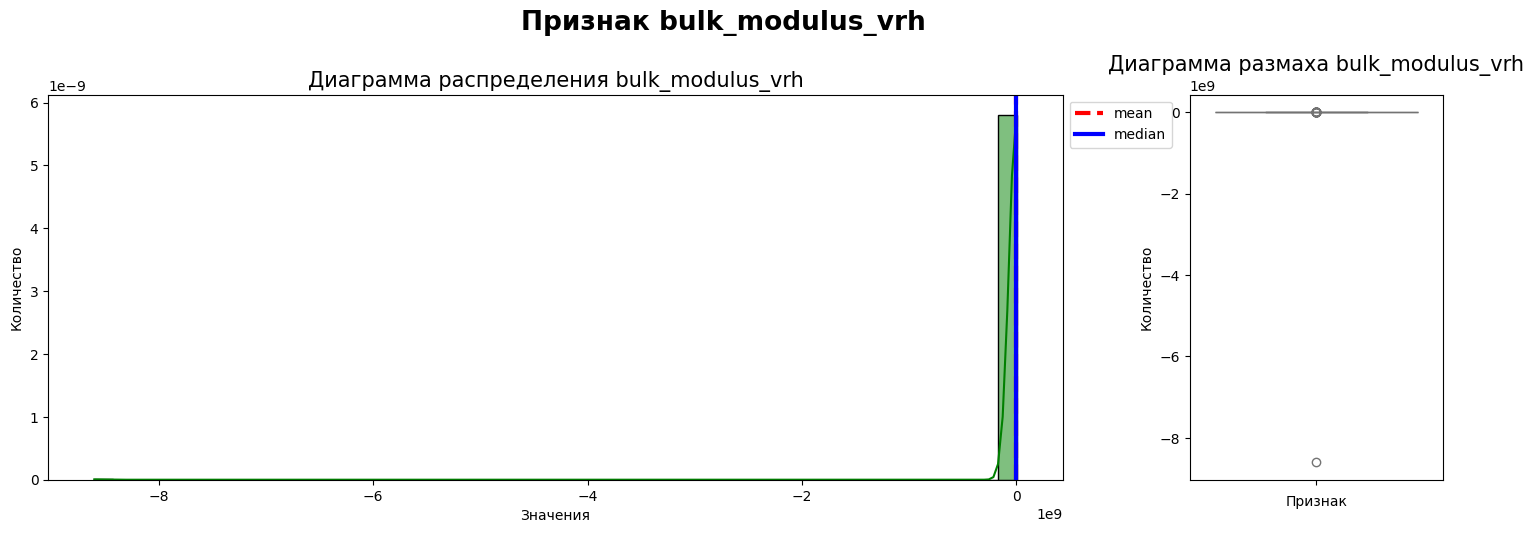

In [446]:
# двойная диаграмма по данным bulk_modulus_vrh
title ='bulk_modulus_vrh'
hist_boxplot(df_full['bulk_modulus_vrh']
            ,title)

Отрицательные значения для bulk_modulus_vrh (средневзвешенного объемного модуля с использованием правила Voigt-Reuss-Hill) являются необычными и физически неинтерпретируемыми, поскольку объемный модуль должен быть положительным. Принято решение удалить примеры с отрицательным значением и с нулевым значением bulk_modulus_vrh

In [447]:
# оставляем только положительные значения bulk_modulus_vrh
df_full = df_full.loc[df_full['bulk_modulus_vrh'] >= 0]

In [448]:
len(df_full)

993

C:\Users\lazarevnv\AppData\Local\Temp\ipykernel_37016\2961438756.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, palette={'lightgreen'})\


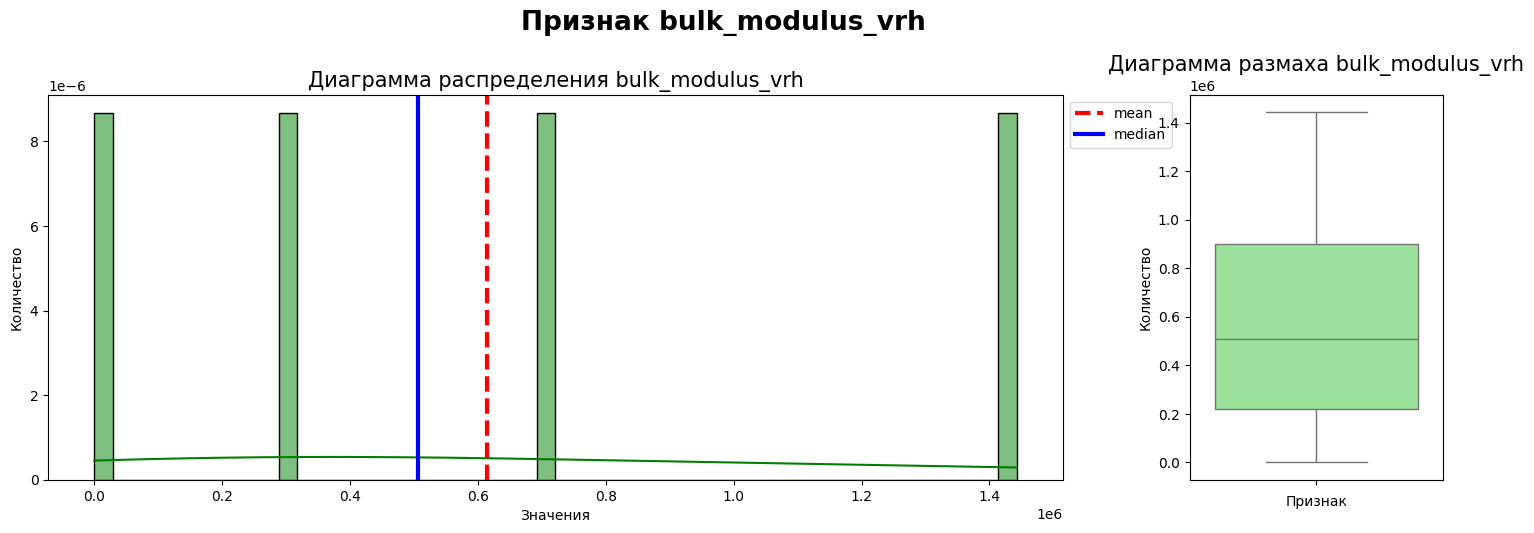

In [449]:
# двойная диаграмма по данным bulk_modulus_vrh >(400)
title ='bulk_modulus_vrh'
hist_boxplot(df_full.loc[df_full['bulk_modulus_vrh']>(400), 'bulk_modulus_vrh']
            ,title)

In [450]:
# смотрим значения выбросов
df_full.loc[df_full['bulk_modulus_vrh']>(400), 'bulk_modulus_vrh']

422    1442373.510
695        444.605
722     291378.268
953     720887.837
Name: bulk_modulus_vrh, dtype: float64

C:\Users\lazarevnv\AppData\Local\Temp\ipykernel_37016\2961438756.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, palette={'lightgreen'})\


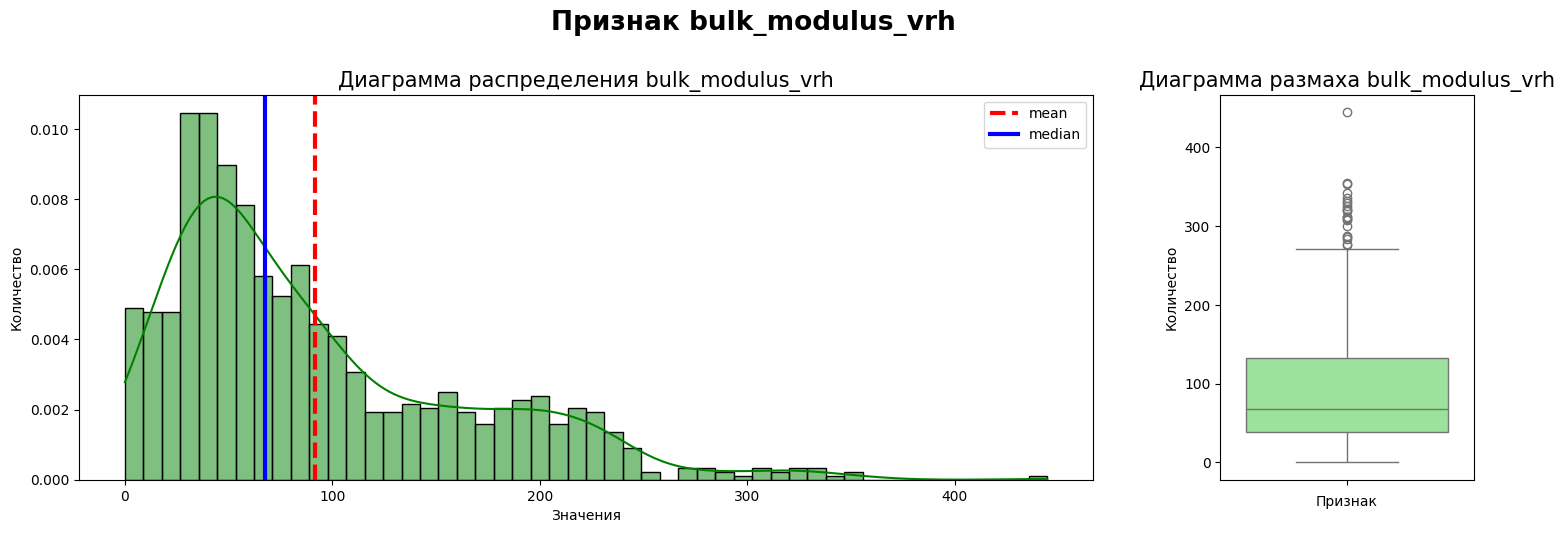

In [451]:
# двойная диаграмма по данным bulk_modulus_vrh
title ='bulk_modulus_vrh'
hist_boxplot(df_full.loc[df_full['bulk_modulus_vrh']<(2000), 'bulk_modulus_vrh']
            ,title)

Убираем примеры с выбросами более чем 500 ГПа.
Физические ограничения:
Максимальные известные значения объемного модуля упругости для материалов на сегодняшний день не превышают 462 ГПа.
Алмаз и осмий, одни из самых жестких и несжимаемых материалов, имеют объемный модуль упругости около 442 ГПа и 462 ГПа соответственно.
Кубический нитрид бора (c-BN) и лонсдейлит (гексагональный алмаз) также имеют значения около 400–450 ГПа.

In [452]:
df_full.loc[df_full['bulk_modulus_vrh'] >= 500, 'bulk_modulus_vrh']

422    1442373.510
722     291378.268
953     720887.837
Name: bulk_modulus_vrh, dtype: float64

In [453]:
# убираем выбросы
df_full = df_full.loc[df_full['bulk_modulus_vrh']< 500]

In [454]:
df_full

,e_above_hull,density,cell_volume,count_atoms,sum_atomic_mass,norm_atomic_mass,lattice_a,lattice_b,lattice_c,angle_alpha,angle_beta,angle_gamma,pbc_a,pbc_b,pbc_c,atom_coord_cart_mean_x,atom_coord_cart_mean_y,atom_coord_cart_mean_z,atom_coord_cart_std_x,atom_coord_cart_std_y,atom_coord_cart_std_z,atom_coord_cart_min_x,atom_coord_cart_min_y,atom_coord_cart_min_z,atom_coord_cart_max_x,atom_coord_cart_max_y,atom_coord_cart_max_z,interatomic_distance_avg,interatomic_distance_std,interatomic_distance_min,interatomic_distance_max,atom_coord_relative_mean_x,atom_coord_relative_mean_y,atom_coord_relative_mean_z,atom_coord_relative_std_x,atom_coord_relative_std_y,atom_coord_relative_std_z,atom_coord_relative_min_x,atom_coord_relative_min_y,atom_coord_relative_min_z,atom_coord_relative_max_x,atom_coord_relative_max_y,atom_coord_relative_max_z,atom_coord_frac_mean_x,atom_coord_frac_mean_y,atom_coord_frac_mean_z,atom_coord_frac_std_x,atom_coord_frac_std_y,atom_coord_frac_std_z,atom_coord_frac_min_x,atom_coord_frac_min_y,atom_coord_frac_min_z,atom_coord_frac_max_x,atom_coord_frac_max_y,atom_coord_frac_max_z,coord_numb_mean,coord_numb_std,coord_numb_min,coord_numb_max,El_1,El_2,El_3,El_4,El_5,El_6,El_7,El_8,El_9,El_10,El_11,El_12,El_13,El_14,El_15,El_16,El_17,El_18,El_19,El_20,El_21,El_22,El_23,El_24,El_25,El_26,El_27,El_28,El_29,El_30,El_31,El_32,El_33,El_34,El_35,El_36,El_37,El_38,El_39,El_40,El_41,El_42,El_43,El_44,El_45,El_46,El_47,El_48,El_49,El_50,El_51,El_52,El_53,El_54,El_55,El_56,El_57,El_58,El_59,El_60,El_61,El_62,El_63,El_64,El_65,El_66,El_67,El_68,El_69,El_70,El_71,El_72,El_73,El_74,El_75,El_76,El_77,El_78,El_79,El_80,El_81,El_82,El_83,El_84,El_85,El_86,El_87,El_88,El_89,El_90,El_91,El_92,El_93,El_94,El_95,El_96,El_97,El_98,El_99,El_100,El_101,El_102,El_103,El_104,El_105,El_106,El_107,El_108,El_109,El_110,El_111,El_112,El_113,El_114,El_115,El_116,El_117,El_118,El_119,bulk_modulus_vrh
0,0.0,8.170182,184.545401,4,908.000000,227.000000,4.046041,4.046041,13.017036,90.000000,90.000000,120.000008,True,True,True,0.505755,0.875994,4.881389,0.875994,0.968449,3.638372,-3.500007e-07,0.000000e+00,0.000000,2.023022,2.335987,9.762777,5.913255,2.209399,4.005873,10.038359,1.110223e-16,0.000000e+00,2.220446e-16,0.875994,0.968449,3.638372,-0.505756,-0.875994,-4.881389,1.517267,1.459993,4.881389,0.250000,0.250000,0.3750,0.276386,0.276386,0.279508,-0.00,-0.00,0.00,0.666667,0.666668,0.750000,12.0,0.000000,12,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24.648
1,0.0,11.367264,110.157369,4,754.085200,188.521300,5.380750,5.380750,5.380750,60.000000,60.000000,60.000000,True,True,True,2.853578,2.853578,2.853578,2.126930,2.126930,2.126930,0.000000e+00,0.000000e+00,0.000000,5.707155,5.707155,5.707155,5.491710,2.455967,3.295010,9.885083,3.330669e-16,3.330669e-16,3.330669e-16,2.126930,2.126930,2.126930,-2.853578,-2.853578,-2.853578,2.853578,2.853578,2.853578,0.375000,0.375000,0.3750,0.279509,0.279509,0.279509,-0.00,-0.00,-0.00,0.750001,0.750001,0.750001,8.0,0.000000,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,67.493
2,0.0,8.370293,135.917612,4,685.121000,171.280250,5.771166,5.771166,5.771166,60.000000,60.000000,60.000000,True,True,True,3.060621,3.060621,3.060621,2.281251,2.281251,2.281251,0.000000e+00,0.000000e+00,0.000000,6.121238,6.121238,6.121238,5.890165,2.634162,3.534089,10.602295,-2.220446e-16,-2.220446e-16,-2.220446e-16,2.281251,2.281251,2.281251,-3.060621,-3.060621,-3.060621,3.060617,3.060617,3.060617,0.375000,0.375000,0.3750,0.279508,0.279508,0.279508,-0.00,0.00,-0.00,0.749999,0.749999,0.749999,8.0,0.000000,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

#### Анализ пропусков (Missing values)

Пропуски в данных могут возникать из-за отсутствия определенных свойств для некоторых материалов, ошибок при выгрузке данных из базы или особенностей расчета определенных параметров. Наличие пропусков может нарушить работу модели или снизить точность предсказаний.

In [455]:
# посмотрим пропуски в каждом поле
for column, missing_value in zip(list(df_full.columns), df_full.isnull().sum()):
    print(f'В поле {column} найдено {missing_value} пропусков')

В поле e_above_hull найдено 0 пропусков
В поле density найдено 0 пропусков
В поле cell_volume найдено 0 пропусков
В поле count_atoms найдено 0 пропусков
В поле sum_atomic_mass найдено 0 пропусков
В поле norm_atomic_mass найдено 0 пропусков
В поле lattice_a найдено 0 пропусков
В поле lattice_b найдено 0 пропусков
В поле lattice_c найдено 0 пропусков
В поле angle_alpha найдено 0 пропусков
В поле angle_beta найдено 0 пропусков
В поле angle_gamma найдено 0 пропусков
В поле pbc_a найдено 0 пропусков
В поле pbc_b найдено 0 пропусков
В поле pbc_c найдено 0 пропусков
В поле atom_coord_cart_mean_x найдено 0 пропусков
В поле atom_coord_cart_mean_y найдено 0 пропусков
В поле atom_coord_cart_mean_z найдено 0 пропусков
В поле atom_coord_cart_std_x найдено 0 пропусков
В поле atom_coord_cart_std_y найдено 0 пропусков
В поле atom_coord_cart_std_z найдено 0 пропусков
В поле atom_coord_cart_min_x найдено 0 пропусков
В поле atom_coord_cart_min_y найдено 0 пропусков
В поле atom_coord_cart_min_z найдено 0 

Пропуски не обнаружены

#### Анализ дубликатов (Duplicates) на всякий случай))

Дубликаты в данных могут возникать из-за повторной выгрузки или дублирования записей в базе данных. Такие записи могут исказить распределение данных и повлиять на результаты модели.

In [456]:
duplicates = df_full[df_full.duplicated()]
print(f"Number of duplicate rows: {len(duplicates)}")

Number of duplicate rows: 0


Дубликаты не обнаружены

#### Проверяем типы данных

In [457]:
# смотрим типы данных
print(df_full.info(verbose=True, show_counts=True))

<class 'pandas.core.frame.DataFrame'>
Index: 990 entries, 0 to 999
Data columns (total 179 columns):
 #    Column                      Non-Null Count  Dtype  
---   ------                      --------------  -----  
 0    e_above_hull                990 non-null    float64
 1    density                     990 non-null    float64
 2    cell_volume                 990 non-null    float64
 3    count_atoms                 990 non-null    int64  
 4    sum_atomic_mass             990 non-null    float64
 5    norm_atomic_mass            990 non-null    float64
 6    lattice_a                   990 non-null    float64
 7    lattice_b                   990 non-null    float64
 8    lattice_c                   990 non-null    float64
 9    angle_alpha                 990 non-null    float64
 10   angle_beta                  990 non-null    float64
 11   angle_gamma                 990 non-null    float64
 12   pbc_a                       990 non-null    bool   
 13   pbc_b                  

### Лишний признак

In [458]:
# смотрим основные описательные характеристики признаков
df_full.describe()

,e_above_hull,density,cell_volume,count_atoms,sum_atomic_mass,norm_atomic_mass,lattice_a,lattice_b,lattice_c,angle_alpha,angle_beta,angle_gamma,atom_coord_cart_mean_x,atom_coord_cart_mean_y,atom_coord_cart_mean_z,atom_coord_cart_std_x,atom_coord_cart_std_y,atom_coord_cart_std_z,atom_coord_cart_min_x,atom_coord_cart_min_y,atom_coord_cart_min_z,atom_coord_cart_max_x,atom_coord_cart_max_y,atom_coord_cart_max_z,interatomic_distance_avg,interatomic_distance_std,interatomic_distance_min,interatomic_distance_max,atom_coord_relative_mean_x,atom_coord_relative_mean_y,atom_coord_relative_mean_z,atom_coord_relative_std_x,atom_coord_relative_std_y,atom_coord_relative_std_z,atom_coord_relative_min_x,atom_coord_relative_min_y,atom_coord_relative_min_z,atom_coord_relative_max_x,atom_coord_relative_max_y,atom_coord_relative_max_z,atom_coord_frac_mean_x,atom_coord_frac_mean_y,atom_coord_frac_mean_z,atom_coord_frac_std_x,atom_coord_frac_std_y,atom_coord_frac_std_z,atom_coord_frac_min_x,atom_coord_frac_min_y,atom_coord_frac_min_z,atom_coord_frac_max_x,atom_coord_frac_max_y,atom_coord_frac_max_z,coord_numb_mean,coord_numb_std,coord_numb_min,coord_numb_max,El_1,El_2,El_3,El_4,El_5,El_6,El_7,El_8,El_9,El_10,El_11,El_12,El_13,El_14,El_15,El_16,El_17,El_18,El_19,El_20,El_21,El_22,El_23,El_24,El_25,El_26,El_27,El_28,El_29,El_30,El_31,El_32,El_33,El_34,El_35,El_36,El_37,El_38,El_39,El_40,El_41,El_42,El_43,El_44,El_45,El_46,El_47,El_48,El_49,El_50,El_51,El_52,El_53,El_54,El_55,El_56,El_57,El_58,El_59,El_60,El_61,El_62,El_63,El_64,El_65,El_66,El_67,El_68,El_69,El_70,El_71,El_72,El_73,El_74,El_75,El_76,El_77,El_78,El_79,El_80,El_81,El_82,El_83,El_84,El_85,El_86,El_87,El_88,El_89,El_90,El_91,El_92,El_93,El_94,El_95,El_96,El_97,El_98,El_99,El_100,El_101,El_102,El_103,El_104,El_105,El_106,El_107,El_108,El_109,El_110,El_111,El_112,El_113,El_114,El_115,El_116,El_117,El_118,El_119,bulk_modulus_vrh
count,990.0,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,9.900000e+02,9.900000e+02,9.900000e+02,990.000000,990.000000,990.000000,9.900000e+02,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.0,990.000000,990.0,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.0,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.0,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.0,990.0,990.0,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.0,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.0,990.0,990.0,990.0,990.000000,990.0,990.000000,990.0,990.0,990.0,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.0,990.0,990.0,990.0,990.0,990.000000,990.0,990.000000,990.000000,990.000000,990.000000,990.0,990.0,990.0,990.0,990.0,990.0,990.0,990.0,990.0,990.0,990.0,990.0,990.0,990.0,990.0,990.0,990.0,990.0,990.0,990.0,990.0,990.0,990.0,990.0,990.000000
mean,0.0,6.642921,170.320562,8.665657,605.342336,79.925330,5.083226,5.448399,6.612410,85.424644,85.162791,87.116032,1.859484,2.060920,2.824476,1.471892,1.446717,2.047819,-0.149563,0.023015,-0.076168,3.965774,4.121746,5.796856,4.376261,1.532316,2.560992,7.848912,-9.179952e-18,-7.662278e-18,2.369099e-18,1.471892,1.446717,2.047819,-2.009047e+00,-2.037905,-2.900645,2.106289,2.060826,2.97238

Обратил внимание, что признак e_above_hull содержит только 0 значения. Можно выгрузить другие примеры материалов с заполнеными значениями признака. Но по рекомендации от куратора в данном признаке нет необходимости. Т.к. при реальном прогнозе для нового материала его расчёт белее трудоемкий чем расчёт модуля упругости. Поэтому удаляем лишнее поле.

In [459]:
df_full['e_above_hull'].unique()

array([0.])

<!-- Обнаружено, что поле e_above_hull имеет только нулевое значение. Поскольку выборка ограничена 1000 строк, вероятно подобранные материалы с таким показателем. Поэтому в данном случае поле e_above_hull следует удалить. -->

In [460]:
# удаляем столбец
df_full.drop(columns=['e_above_hull'], inplace=True)

In [461]:
df_full.head()

,density,cell_volume,count_atoms,sum_atomic_mass,norm_atomic_mass,lattice_a,lattice_b,lattice_c,angle_alpha,angle_beta,angle_gamma,pbc_a,pbc_b,pbc_c,atom_coord_cart_mean_x,atom_coord_cart_mean_y,atom_coord_cart_mean_z,atom_coord_cart_std_x,atom_coord_cart_std_y,atom_coord_cart_std_z,atom_coord_cart_min_x,atom_coord_cart_min_y,atom_coord_cart_min_z,atom_coord_cart_max_x,atom_coord_cart_max_y,atom_coord_cart_max_z,interatomic_distance_avg,interatomic_distance_std,interatomic_distance_min,interatomic_distance_max,atom_coord_relative_mean_x,atom_coord_relative_mean_y,atom_coord_relative_mean_z,atom_coord_relative_std_x,atom_coord_relative_std_y,atom_coord_relative_std_z,atom_coord_relative_min_x,atom_coord_relative_min_y,atom_coord_relative_min_z,atom_coord_relative_max_x,atom_coord_relative_max_y,atom_coord_relative_max_z,atom_coord_frac_mean_x,atom_coord_frac_mean_y,atom_coord_frac_mean_z,atom_coord_frac_std_x,atom_coord_frac_std_y,atom_coord_frac_std_z,atom_coord_frac_min_x,atom_coord_frac_min_y,atom_coord_frac_min_z,atom_coord_frac_max_x,atom_coord_frac_max_y,atom_coord_frac_max_z,coord_numb_mean,coord_numb_std,coord_numb_min,coord_numb_max,El_1,El_2,El_3,El_4,El_5,El_6,El_7,El_8,El_9,El_10,El_11,El_12,El_13,El_14,El_15,El_16,El_17,El_18,El_19,El_20,El_21,El_22,El_23,El_24,El_25,El_26,El_27,El_28,El_29,El_30,El_31,El_32,El_33,El_34,El_35,El_36,El_37,El_38,El_39,El_40,El_41,El_42,El_43,El_44,El_45,El_46,El_47,El_48,El_49,El_50,El_51,El_52,El_53,El_54,El_55,El_56,El_57,El_58,El_59,El_60,El_61,El_62,El_63,El_64,El_65,El_66,El_67,El_68,El_69,El_70,El_71,El_72,El_73,El_74,El_75,El_76,El_77,El_78,El_79,El_80,El_81,El_82,El_83,El_84,El_85,El_86,El_87,El_88,El_89,El_90,El_91,El_92,El_93,El_94,El_95,El_96,El_97,El_98,El_99,El_100,El_101,El_102,El_103,El_104,El_105,El_106,El_107,El_108,El_109,El_110,El_111,El_112,El_113,El_114,El_115,El_116,El_117,El_118,El_119,bulk_modulus_vrh
0,8.170182,184.545401,4,908.0000,227.00000,4.046041,4.046041,13.017036,90.0,90.0,120.000008,True,True,True,0.505755,0.875994,4.881389,0.875994,0.968449,3.638372,-3.500007e-07,0.0,0.0,2.023022,2.335987,9.762777,5.913255,2.209399,4.005873,10.038359,1.110223e-16,0.000000e+00,2.220446e-16,0.875994,0.968449,3.638372,-0.505756,-0.875994,-4.881389,1.517267,1.459993,4.881389,0.250,0.250,0.375,0.276386,0.276386,0.279508,-0.0,-0.0,0.0,0.666667,0.666668,0.750000,12.0,0.0,12,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24.648
1,11.367264,110.157369,4,754.0852,188.52130,5.380750,5.380750,5.380750,60.0,60.0,60.000000,True,True,True,2.853578,2.853578,2.853578,2.126930,2.126930,2.126930,0.000000e+00,0.0,0.0,5.707155,5.707155,5.707155,5.491710,2.455967,3.295010,9.885083,3.330669e-16,3.330669e-16,3.330669e-16,2.126930,2.126930,2.126930,-2.853578,-2.853578,-2.853578,2.853578,2.853578,2.853578,0.375,0.375,0.375,0.279509,0.279509,0.279509,-0.0,-0.0,-0.0,0.750001,0.750001,0.750001,8.0,0.0,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,67.493
2,8.370293,135.917612,4,685.1210,171.28025,5.771166,5.771166,5.771166,60.0,60.0,60.000000,True,True,True,3.060621,3.060621,3.060621,2.281251,2.281251,2.281251,0.000000e+00,0.0,0.0,6.121238,6.121238,6.121238,5.890165,2.634162,3.534089,10.602295,-2.220446e-16,-2.220446e-16,-2.220446e-16,2.281251,2.281251,2.281251,-3.060621,-3.060621,-3.060621,3.060617,3.060617,3.060617,0.375,0.375,0.375,0.279508,0.279508,0.279508,-0.0,0.0,-0.0,0.749999,0.749999,0.749999,8.0,0.0,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,

### Анализ зависимости таргета от фичей

In [462]:
corr_matrix = df_full.corr()

In [463]:
corr_matrix.tail(2)

,density,cell_volume,count_atoms,sum_atomic_mass,norm_atomic_mass,lattice_a,lattice_b,lattice_c,angle_alpha,angle_beta,angle_gamma,pbc_a,pbc_b,pbc_c,atom_coord_cart_mean_x,atom_coord_cart_mean_y,atom_coord_cart_mean_z,atom_coord_cart_std_x,atom_coord_cart_std_y,atom_coord_cart_std_z,atom_coord_cart_min_x,atom_coord_cart_min_y,atom_coord_cart_min_z,atom_coord_cart_max_x,atom_coord_cart_max_y,atom_coord_cart_max_z,interatomic_distance_avg,interatomic_distance_std,interatomic_distance_min,interatomic_distance_max,atom_coord_relative_mean_x,atom_coord_relative_mean_y,atom_coord_relative_mean_z,atom_coord_relative_std_x,atom_coord_relative_std_y,atom_coord_relative_std_z,atom_coord_relative_min_x,atom_coord_relative_min_y,atom_coord_relative_min_z,atom_coord_relative_max_x,atom_coord_relative_max_y,atom_coord_relative_max_z,atom_coord_frac_mean_x,atom_coord_frac_mean_y,atom_coord_frac_mean_z,atom_coord_frac_std_x,atom_coord_frac_std_y,atom_coord_frac_std_z,atom_coord_frac_min_x,atom_coord_frac_min_y,atom_coord_frac_min_z,atom_coord_frac_max_x,atom_coord_frac_max_y,atom_coord_frac_max_z,coord_numb_mean,coord_numb_std,coord_numb_min,coord_numb_max,El_1,El_2,El_3,El_4,El_5,El_6,El_7,El_8,El_9,El_10,El_11,El_12,El_13,El_14,El_15,El_16,El_17,El_18,El_19,El_20,El_21,El_22,El_23,El_24,El_25,El_26,El_27,El_28,El_29,El_30,El_31,El_32,El_33,El_34,El_35,El_36,El_37,El_38,El_39,El_40,El_41,El_42,El_43,El_44,El_45,El_46,El_47,El_48,El_49,El_50,El_51,El_52,El_53,El_54,El_55,El_56,El_57,El_58,El_59,El_60,El_61,El_62,El_63,El_64,El_65,El_66,El_67,El_68,El_69,El_70,El_71,El_72,El_73,El_74,El_75,El_76,El_77,El_78,El_79,El_80,El_81,El_82,El_83,El_84,El_85,El_86,El_87,El_88,El_89,El_90,El_91,El_92,El_93,El_94,El_95,El_96,El_97,El_98,El_99,El_100,El_101,El_102,El_103,El_104,El_105,El_106,El_107,El_108,El_109,El_110,El_111,El_112,El_113,El_114,El_115,El_116,El_117,El_118,El_119,bulk_modulus_vrh
El_119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bulk_modulus_vrh,0.508299,-0.361679,-0.043228,-0.151258,-0.164559,-0.379317,-0.362939,-0.331491,-0.100196,-0.101172,-0.079441,NaN,NaN,NaN,-0.151216,-0.176161,-0.163146,-0.215552,-0.230178,-0.23549,0.014389,0.003543,0.004035,-0.194091,-0.20122,-0.190267,-0.332898,-0.150558,-0.281336,-0.234061,0.055198,-0.008194,0.017334,-0.215552,-0.230178,-0.23549,0.179469,0.204441,0.199704,-0.198108,-0.196508,-0.190236,-0.087777,-0.077983,-0.064737,-0.076684,-0.062534,-0.046129,0.008912,-0.01449,-0.037393,-0.116149,-0.090226,-0.051414,0.290728,-0.116752,0.299081,0.141468,NaN,-0.067107,NaN,-0.055421,0.170442,0.127975,0.078391,-0.015634,0.001757,-0.137195,NaN,-0.058515,-0.120575,0.101424,0.061063,-0.00831,-0.091437,-0.162844,-0.040383,NaN,-0.176723,0.030227,-0.010758,0.127839,0.169276,-0.053547,0.14073,0.224759,0.041646,-0.009803,-0.075915,-0.026828,-0.042442,-0.035738,-0.108074,-0.126377,NaN,NaN,NaN,-0.005695,-0.006502,0.069964,0.127586,0.107344,0.222237,0.159997,0.046806,-0.07035,-0.112066,-0.05522,-0.096761,-0.08898,-0.135002,-0.132128,NaN,-0.241083,-0.219554,-0.050822,0.08848,-0.036481,-0.030337,-0.033639,NaN,NaN,NaN,NaN,-0.017942,NaN,-0.002772,NaN,NaN,NaN,0.005546,-0.01884,0.248419,0.142342,0.154948,0.210847,0.166284,-0.034133,-0.121888,-0.076603,-0.077742,-0.137443,NaN,NaN,NaN,NaN,NaN,-0.107812,NaN,0.007763,-0.024801,-0.025331,-0.024271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [464]:
print(list(df_full.columns))

['density', 'cell_volume', 'count_atoms', 'sum_atomic_mass', 'norm_atomic_mass', 'lattice_a', 'lattice_b', 'lattice_c', 'angle_alpha', 'angle_beta', 'angle_gamma', 'pbc_a', 'pbc_b', 'pbc_c', 'atom_coord_cart_mean_x', 'atom_coord_cart_mean_y', 'atom_coord_cart_mean_z', 'atom_coord_cart_std_x', 'atom_coord_cart_std_y', 'atom_coord_cart_std_z', 'atom_coord_cart_min_x', 'atom_coord_cart_min_y', 'atom_coord_cart_min_z', 'atom_coord_cart_max_x', 'atom_coord_cart_max_y', 'atom_coord_cart_max_z', 'interatomic_distance_avg', 'interatomic_distance_std', 'interatomic_distance_min', 'interatomic_distance_max', 'atom_coord_relative_mean_x', 'atom_coord_relative_mean_y', 'atom_coord_relative_mean_z', 'atom_coord_relative_std_x', 'atom_coord_relative_std_y', 'atom_coord_relative_std_z', 'atom_coord_relative_min_x', 'atom_coord_relative_min_y', 'atom_coord_relative_min_z', 'atom_coord_relative_max_x', 'atom_coord_relative_max_y', 'atom_coord_relative_max_z', 'atom_coord_frac_mean_x', 'atom_coord_frac_

In [465]:
corr_matrix_final = np.round(corr_matrix, 4)

In [466]:
corr_matrix_final[np.abs(corr_matrix_final)<0.01] = 0

### Удаляем лишние фичи

In [467]:
corr_matrix_final.tail(2)

,density,cell_volume,count_atoms,sum_atomic_mass,norm_atomic_mass,lattice_a,lattice_b,lattice_c,angle_alpha,angle_beta,angle_gamma,pbc_a,pbc_b,pbc_c,atom_coord_cart_mean_x,atom_coord_cart_mean_y,atom_coord_cart_mean_z,atom_coord_cart_std_x,atom_coord_cart_std_y,atom_coord_cart_std_z,atom_coord_cart_min_x,atom_coord_cart_min_y,atom_coord_cart_min_z,atom_coord_cart_max_x,atom_coord_cart_max_y,atom_coord_cart_max_z,interatomic_distance_avg,interatomic_distance_std,interatomic_distance_min,interatomic_distance_max,atom_coord_relative_mean_x,atom_coord_relative_mean_y,atom_coord_relative_mean_z,atom_coord_relative_std_x,atom_coord_relative_std_y,atom_coord_relative_std_z,atom_coord_relative_min_x,atom_coord_relative_min_y,atom_coord_relative_min_z,atom_coord_relative_max_x,atom_coord_relative_max_y,atom_coord_relative_max_z,atom_coord_frac_mean_x,atom_coord_frac_mean_y,atom_coord_frac_mean_z,atom_coord_frac_std_x,atom_coord_frac_std_y,atom_coord_frac_std_z,atom_coord_frac_min_x,atom_coord_frac_min_y,atom_coord_frac_min_z,atom_coord_frac_max_x,atom_coord_frac_max_y,atom_coord_frac_max_z,coord_numb_mean,coord_numb_std,coord_numb_min,coord_numb_max,El_1,El_2,El_3,El_4,El_5,El_6,El_7,El_8,El_9,El_10,El_11,El_12,El_13,El_14,El_15,El_16,El_17,El_18,El_19,El_20,El_21,El_22,El_23,El_24,El_25,El_26,El_27,El_28,El_29,El_30,El_31,El_32,El_33,El_34,El_35,El_36,El_37,El_38,El_39,El_40,El_41,El_42,El_43,El_44,El_45,El_46,El_47,El_48,El_49,El_50,El_51,El_52,El_53,El_54,El_55,El_56,El_57,El_58,El_59,El_60,El_61,El_62,El_63,El_64,El_65,El_66,El_67,El_68,El_69,El_70,El_71,El_72,El_73,El_74,El_75,El_76,El_77,El_78,El_79,El_80,El_81,El_82,El_83,El_84,El_85,El_86,El_87,El_88,El_89,El_90,El_91,El_92,El_93,El_94,El_95,El_96,El_97,El_98,El_99,El_100,El_101,El_102,El_103,El_104,El_105,El_106,El_107,El_108,El_109,El_110,El_111,El_112,El_113,El_114,El_115,El_116,El_117,El_118,El_119,bulk_modulus_vrh
El_119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bulk_modulus_vrh,0.5083,-0.3617,-0.0432,-0.1513,-0.1646,-0.3793,-0.3629,-0.3315,-0.1002,-0.1012,-0.0794,NaN,NaN,NaN,-0.1512,-0.1762,-0.1631,-0.2156,-0.2302,-0.2355,0.0144,0.0,0.0,-0.1941,-0.2012,-0.1903,-0.3329,-0.1506,-0.2813,-0.2341,0.0552,0.0,0.0173,-0.2156,-0.2302,-0.2355,0.1795,0.2044,0.1997,-0.1981,-0.1965,-0.1902,-0.0878,-0.078,-0.0647,-0.0767,-0.0625,-0.0461,0.0,-0.0145,-0.0374,-0.1161,-0.0902,-0.0514,0.2907,-0.1168,0.2991,0.1415,NaN,-0.0671,NaN,-0.0554,0.1704,0.128,0.0784,-0.0156,0.0,-0.1372,NaN,-0.0585,-0.1206,0.1014,0.0611,0.0,-0.0914,-0.1628,-0.0404,NaN,-0.1767,0.0302,-0.0108,0.1278,0.1693,-0.0535,0.1407,0.2248,0.0416,0.0,-0.0759,-0.0268,-0.0424,-0.0357,-0.1081,-0.1264,NaN,NaN,NaN,0.0,0.0,0.07,0.1276,0.1073,0.2222,0.16,0.0468,-0.0704,-0.1121,-0.0552,-0.0968,-0.089,-0.135,-0.1321,NaN,-0.2411,-0.2196,-0.0508,0.0885,-0.0365,-0.0303,-0.0336,NaN,NaN,NaN,NaN,-0.0179,NaN,0.0,NaN,NaN,NaN,0.0,-0.0188,0.2484,0.1423,0.1549,0.2108,0.1663,-0.0341,-0.1219,-0.0766,-0.0777,-0.1374,NaN,NaN,NaN,NaN,NaN,-0.1078,NaN,0.0,-0.0248,-0.0253,-0.0243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [468]:
df_full.tail(2)

,density,cell_volume,count_atoms,sum_atomic_mass,norm_atomic_mass,lattice_a,lattice_b,lattice_c,angle_alpha,angle_beta,angle_gamma,pbc_a,pbc_b,pbc_c,atom_coord_cart_mean_x,atom_coord_cart_mean_y,atom_coord_cart_mean_z,atom_coord_cart_std_x,atom_coord_cart_std_y,atom_coord_cart_std_z,atom_coord_cart_min_x,atom_coord_cart_min_y,atom_coord_cart_min_z,atom_coord_cart_max_x,atom_coord_cart_max_y,atom_coord_cart_max_z,interatomic_distance_avg,interatomic_distance_std,interatomic_distance_min,interatomic_distance_max,atom_coord_relative_mean_x,atom_coord_relative_mean_y,atom_coord_relative_mean_z,atom_coord_relative_std_x,atom_coord_relative_std_y,atom_coord_relative_std_z,atom_coord_relative_min_x,atom_coord_relative_min_y,atom_coord_relative_min_z,atom_coord_relative_max_x,atom_coord_relative_max_y,atom_coord_relative_max_z,atom_coord_frac_mean_x,atom_coord_frac_mean_y,atom_coord_frac_mean_z,atom_coord_frac_std_x,atom_coord_frac_std_y,atom_coord_frac_std_z,atom_coord_frac_min_x,atom_coord_frac_min_y,atom_coord_frac_min_z,atom_coord_frac_max_x,atom_coord_frac_max_y,atom_coord_frac_max_z,coord_numb_mean,coord_numb_std,coord_numb_min,coord_numb_max,El_1,El_2,El_3,El_4,El_5,El_6,El_7,El_8,El_9,El_10,El_11,El_12,El_13,El_14,El_15,El_16,El_17,El_18,El_19,El_20,El_21,El_22,El_23,El_24,El_25,El_26,El_27,El_28,El_29,El_30,El_31,El_32,El_33,El_34,El_35,El_36,El_37,El_38,El_39,El_40,El_41,El_42,El_43,El_44,El_45,El_46,El_47,El_48,El_49,El_50,El_51,El_52,El_53,El_54,El_55,El_56,El_57,El_58,El_59,El_60,El_61,El_62,El_63,El_64,El_65,El_66,El_67,El_68,El_69,El_70,El_71,El_72,El_73,El_74,El_75,El_76,El_77,El_78,El_79,El_80,El_81,El_82,El_83,El_84,El_85,El_86,El_87,El_88,El_89,El_90,El_91,El_92,El_93,El_94,El_95,El_96,El_97,El_98,El_99,El_100,El_101,El_102,El_103,El_104,El_105,El_106,El_107,El_108,El_109,El_110,El_111,El_112,El_113,El_114,El_115,El_116,El_117,El_118,El_119,bulk_modulus_vrh
998,15.447910,109.158723,6,1015.498000,169.249667,5.355657,5.355658,4.394427,90.000000,90.000000,120.000005,True,True,True,0.892609,1.546045,1.098607,1.480226,1.180812,1.098607,-1.338915,-5.000000e-09,0.0,2.677831,3.092092,2.197214,3.312982,0.725071,2.677828,4.643228,-7.401487e-17,-1.110223e-16,0.000000e+00,1.480226,1.180812,1.098607,-2.231524,-1.546045,-1.098607,1.785222,1.546047,1.098607,0.333333,0.333333,0.2500,0.254588,0.254588,0.250000,-0.0,0.0,0.0,0.666667,0.666667,0.50000,10.0,5.385165,3,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,167.886
999,4.999452,115.968968,8,349.152419,43.644052,5.802000,5.802000,5.802001,53.157309,53.157301,53.157306,True,True,True,2.824612,1.913718,5.556137,1.555027,1.339734,2.392409,0.000000,0.000000e+00,0.0,4.745834,4.036407,8.283494,4.260466,2.135579,2.269672,8.974016,-3.330669e-16,1.110223e-16,-3.330669e-16,1.555027,1.339734,2.392409,-2.824612,-1.913718,-5.556137,1.921222,2.122688,2.727357,0.437500,0.437500,0.4375,0.309778,0.309778,0.309778,-0.0,0.0,0.0,0.928620,0.928620,0.92862,3.0,1.732051,2,6,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.548


Принято решение удалить признаки количества элементов El_01, El_02 и т.д., которые не содержат положительных значений. Да, теоретически, формула при новом запросе на прогноз может быть любой. Но конкретно для нашей учебной задачи, где датафрейм не привышает 1000 строк, решение удалить поля не содержащие данных - правильное. Это поможет оптимизировать модель, улучшить ее производительность и интерпретируемость.

In [469]:
# в новом датафрейме оставим только нужные поля
df_work = df_full[['density', 'cell_volume', 'count_atoms', 
 'sum_atomic_mass', 'norm_atomic_mass', 
 'lattice_a', 'lattice_b', 'lattice_c', 
 'angle_alpha', 'angle_beta', 'angle_gamma',  
 'atom_coord_cart_std_x', 'atom_coord_cart_std_y', 'atom_coord_cart_std_z', 
 'interatomic_distance_avg',
 'atom_coord_relative_max_x', 'atom_coord_relative_max_y', 'atom_coord_relative_max_z', 
 'coord_numb_mean',   'coord_numb_min', 'coord_numb_max', 
 'El_13', 'El_21', 'El_29', 'El_57', 'El_59', 
 'bulk_modulus_vrh'
 ]]

In [470]:
# подготовим коррекляционную матрицу
corr_matrix_work = df_work.corr()
corr_matrix_work = np.round(corr_matrix_work, 2)
corr_matrix_work[np.abs(corr_matrix_work) < 0.01] = 0

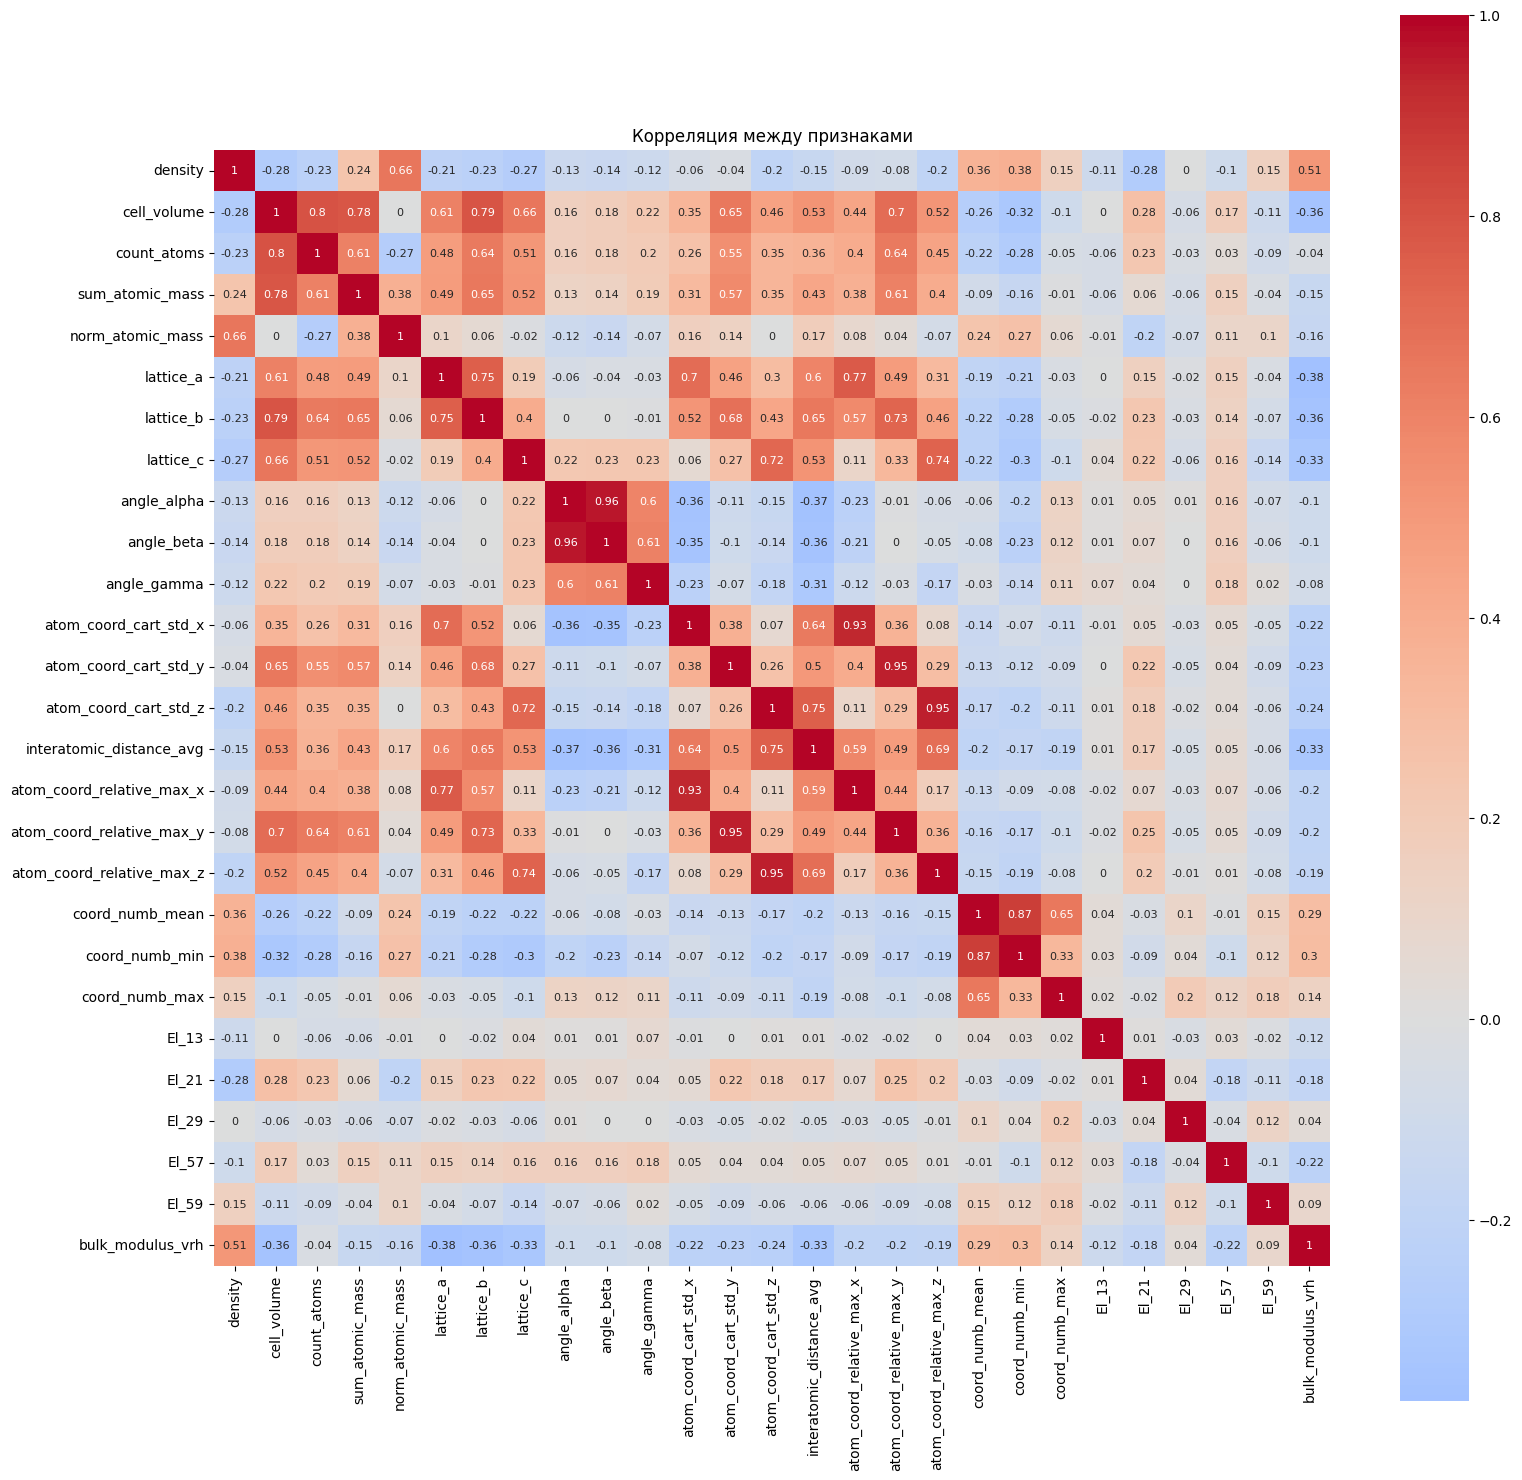

In [471]:
# визуализируем матрицу
plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix_work, 
            vmax=1,
            square=True,
            annot=True,
            cmap='coolwarm',
            center=0,
            # annot=True,
            annot_kws={"size":8})
plt.title('Корреляция между признаками')
plt.show()

В рамках проверки на мультиколлиниарность удалён один из признаков в каждой паре, с взаимной зависимостью более 0.9.
 Поскольку и atom_coord_cart_std и atom_coord_relative являются производными от картезианских декартовых координат, то отчасти они дублируют друг друга. В итоге принято решение удалить признаки 'atom_coord_cart_std_x', 'atom_coord_cart_std_y', 'atom_coord_cart_std_z'.


Признаки angle_alpha и angle_beta также показывают высокую корреляцию. Но всё же принято решение сохранить оба признака, поскольку они являются взаимодополняемыми, и характеризуют углы между векторами решетки.

In [472]:
# удаляем лишние поля
df_work = df_work.drop(columns=['atom_coord_cart_std_x', 'atom_coord_cart_std_y', 'atom_coord_cart_std_z'])

### Выводы по анализу данных

В рамках анализа выбросов найдены отрицательные значения для bulk_modulus_vrh (средневзвешенного объемного модуля с использованием правила Voigt-Reuss-Hill) которые являются необычными и физически неинтерпретируемыми, поскольку объемный модуль должен быть положительным. Принято решение удалить примеры с отрицательным значением и с нулевым значением bulk_modulus_vrh


Также удалены примеры с выбросами bulk_modulus_vrh более чем 500 ГПа.
Физические ограничения:
Максимальные известные значения объемного модуля упругости для материалов на сегодняшний день не превышают 462 ГПа.
Алмаз и осмий, одни из самых жестких и несжимаемых материалов, имеют объемный модуль упругости около 442 ГПа и 462 ГПа соответственно.
Кубический нитрид бора (c-BN) и лонсдейлит (гексагональный алмаз) также имеют значения около 400–450 ГПа.

Проведен анализ дубликатов и пропусков.

Обнаружено, что признак e_above_hull содержит только 0 значения. Можно выгрузить другие примеры материалов с заполнеными значениями признака. Но по рекомендации от куратора в данном признаке нет необходимости. Т.к. при реальном прогнозе для нового материала его расчёт белее трудоемкий, чем расчёт модуля упругости. Поэтому удаляем лишнее поле.


Принято решение удалить признаки количества элементов El_01, El_02 и т.д., которые не содержат положительных значений. Да, теоретически, формула при новом запросе на прогноз может быть любой. Но конкретно для нашей учебной задачи, где датафрейм не привышает 1000 строк, решение удалить поля не содержащие данных - правильное. Это поможет оптимизировать модель, улучшить ее производительность и интерпретируемость.

В рамках проверки на мультиколлиниарность удалён один из признаков в каждой паре, с взаимной зависимостью более 0.9.
Поскольку и atom_coord_cart_std и atom_coord_relative являются производными от картезианских декартовых координат, то отчасти они дублируют друг друга. В итоге принято решение удалить признаки 'atom_coord_cart_std_x', 'atom_coord_cart_std_y', 'atom_coord_cart_std_z'.

В итоге получен окончательно сформированный датафрейм, который готов к разбивке на train и test.

## Разбивка данных на тренировочные и тестовые

In [473]:
df_work.tail(2)

,density,cell_volume,count_atoms,sum_atomic_mass,norm_atomic_mass,lattice_a,lattice_b,lattice_c,angle_alpha,angle_beta,angle_gamma,interatomic_distance_avg,atom_coord_relative_max_x,atom_coord_relative_max_y,atom_coord_relative_max_z,coord_numb_mean,coord_numb_min,coord_numb_max,El_13,El_21,El_29,El_57,El_59,bulk_modulus_vrh
998,15.447910,109.158723,6,1015.498000,169.249667,5.355657,5.355658,4.394427,90.000000,90.000000,120.000005,3.312982,1.785222,1.546047,1.098607,10.0,3,18,0,1,0,0,0,167.886
999,4.999452,115.968968,8,349.152419,43.644052,5.802000,5.802000,5.802001,53.157309,53.157301,53.157306,4.260466,1.921222,2.122688,2.727357,3.0,2,6,0,1,0,0,0,19.548


In [474]:
df_work.columns

Index(['density', 'cell_volume', 'count_atoms', 'sum_atomic_mass',
       'norm_atomic_mass', 'lattice_a', 'lattice_b', 'lattice_c',
       'angle_alpha', 'angle_beta', 'angle_gamma', 'interatomic_distance_avg',
       'atom_coord_relative_max_x', 'atom_coord_relative_max_y',
       'atom_coord_relative_max_z', 'coord_numb_mean', 'coord_numb_min',
       'coord_numb_max', 'El_13', 'El_21', 'El_29', 'El_57', 'El_59',
       'bulk_modulus_vrh'],
      dtype='object')

In [475]:
def t_t_s(df):
    # Зададим целевой признак
    target = df['bulk_modulus_vrh']
    # подготовим данные 
    features = df.drop(['bulk_modulus_vrh'], axis = 1)

    # разобъём данные по соотношению 4:1
    features_train, features_test, target_train, target_test = \
        train_test_split(features, target, test_size=0.20, random_state=270223)
    return features_train, features_test, target_train, target_test

In [476]:
# разбивка данных на train, test, features, target
data_features_train, data_features_test, data_target_train, data_target_test = t_t_s(df_work)

In [477]:
data_features_test.columns

Index(['density', 'cell_volume', 'count_atoms', 'sum_atomic_mass',
       'norm_atomic_mass', 'lattice_a', 'lattice_b', 'lattice_c',
       'angle_alpha', 'angle_beta', 'angle_gamma', 'interatomic_distance_avg',
       'atom_coord_relative_max_x', 'atom_coord_relative_max_y',
       'atom_coord_relative_max_z', 'coord_numb_mean', 'coord_numb_min',
       'coord_numb_max', 'El_13', 'El_21', 'El_29', 'El_57', 'El_59'],
      dtype='object')

Сформированный датафрейм разбит данных на train и test в соотношении 4:1.
Получены датафреймы:  
data_features_train, data_features_test, 
data_target_train, data_target_test

Целевой признак bulk_modulus_vrh - объемный модуль упругости.

## Модели машинного обучения

### Модель CatBoost


CatBoost  — это алгоритм градиентного бустинга на решающих деревьях, разработанный компанией Яндекс. В нашем случае, используем его для решения задачи регрессии.

In [478]:
# смотрим
df_work.tail(2)

,density,cell_volume,count_atoms,sum_atomic_mass,norm_atomic_mass,lattice_a,lattice_b,lattice_c,angle_alpha,angle_beta,angle_gamma,interatomic_distance_avg,atom_coord_relative_max_x,atom_coord_relative_max_y,atom_coord_relative_max_z,coord_numb_mean,coord_numb_min,coord_numb_max,El_13,El_21,El_29,El_57,El_59,bulk_modulus_vrh
998,15.447910,109.158723,6,1015.498000,169.249667,5.355657,5.355658,4.394427,90.000000,90.000000,120.000005,3.312982,1.785222,1.546047,1.098607,10.0,3,18,0,1,0,0,0,167.886
999,4.999452,115.968968,8,349.152419,43.644052,5.802000,5.802000,5.802001,53.157309,53.157301,53.157306,4.260466,1.921222,2.122688,2.727357,3.0,2,6,0,1,0,0,0,19.548


In [479]:
# смотрим список полей
df_work.columns

Index(['density', 'cell_volume', 'count_atoms', 'sum_atomic_mass',
       'norm_atomic_mass', 'lattice_a', 'lattice_b', 'lattice_c',
       'angle_alpha', 'angle_beta', 'angle_gamma', 'interatomic_distance_avg',
       'atom_coord_relative_max_x', 'atom_coord_relative_max_y',
       'atom_coord_relative_max_z', 'coord_numb_mean', 'coord_numb_min',
       'coord_numb_max', 'El_13', 'El_21', 'El_29', 'El_57', 'El_59',
       'bulk_modulus_vrh'],
      dtype='object')

In [480]:
# список категориальных и числовых полей
category_columns = []
numerical_columns = data_features_train.columns.to_list()

In [481]:
# инициируем модель
catboost_model = CatBoostRegressor(
            loss_function='MAE',
            n_estimators=125,
            verbose=25,
)

#### Оценка модели через кросс-валидацию

In [482]:
# оценка модели через кросс-валидацию
cv_score = cross_val_score(catboost_model, 
                data_features_train, 
                data_target_train,
                scoring = 'neg_mean_absolute_error',
                cv=5)

0:	learn: 54.5878692	total: 2.22ms	remaining: 276ms
25:	learn: 39.0056114	total: 53ms	remaining: 202ms
50:	learn: 30.5054457	total: 109ms	remaining: 159ms
75:	learn: 25.3155934	total: 172ms	remaining: 111ms
100:	learn: 22.1439680	total: 235ms	remaining: 55.9ms
124:	learn: 20.0581189	total: 294ms	remaining: 0us
0:	learn: 53.5666650	total: 2.72ms	remaining: 338ms
25:	learn: 38.0336363	total: 66.2ms	remaining: 252ms
50:	learn: 29.9154057	total: 124ms	remaining: 180ms
75:	learn: 25.0749192	total: 184ms	remaining: 118ms
100:	learn: 21.9938758	total: 238ms	remaining: 56.5ms
124:	learn: 20.0414101	total: 293ms	remaining: 0us
0:	learn: 54.3654977	total: 2.85ms	remaining: 353ms
25:	learn: 38.8323099	total: 59.8ms	remaining: 228ms
50:	learn: 30.4287031	total: 115ms	remaining: 167ms
75:	learn: 25.7612256	total: 177ms	remaining: 114ms
100:	learn: 22.6916882	total: 246ms	remaining: 58.5ms
124:	learn: 20.7140830	total: 312ms	remaining: 0us
0:	learn: 51.6203159	total: 2.56ms	remaining: 318ms
25:	lear

In [483]:
# оценка модели через кросс-валидацию
final_cv_score = round(np.mean(-cv_score), 1)
print('MAE модели через кросс-валидацию', final_cv_score)

MAE модели через кросс-валидацию 25.9


In [484]:
# оценка модели через кросс-валидацию
cv_score_r2 = cross_val_score(catboost_model, 
                data_features_train, 
                data_target_train,
                scoring = 'r2',
                cv=5)

0:	learn: 54.5878692	total: 2.16ms	remaining: 268ms
25:	learn: 39.0056114	total: 68.5ms	remaining: 261ms
50:	learn: 30.5054457	total: 132ms	remaining: 192ms
75:	learn: 25.3155934	total: 196ms	remaining: 126ms
100:	learn: 22.1439680	total: 254ms	remaining: 60.4ms
124:	learn: 20.0581189	total: 316ms	remaining: 0us
0:	learn: 53.5666650	total: 3.97ms	remaining: 492ms
25:	learn: 38.0336363	total: 75.6ms	remaining: 288ms
50:	learn: 29.9154057	total: 138ms	remaining: 200ms
75:	learn: 25.0749192	total: 199ms	remaining: 128ms
100:	learn: 21.9938758	total: 253ms	remaining: 60.1ms
124:	learn: 20.0414101	total: 312ms	remaining: 0us
0:	learn: 54.3654977	total: 2.23ms	remaining: 276ms
25:	learn: 38.8323099	total: 60ms	remaining: 228ms
50:	learn: 30.4287031	total: 116ms	remaining: 168ms
75:	learn: 25.7612256	total: 177ms	remaining: 114ms
100:	learn: 22.6916882	total: 249ms	remaining: 59.3ms
124:	learn: 20.7140830	total: 314ms	remaining: 0us
0:	learn: 51.6203159	total: 2.28ms	remaining: 283ms
25:	lear

In [485]:
cv_score_r2

array([0.6773508 , 0.64358042, 0.75643186, 0.61996706, 0.70161727])

In [486]:
# оценка модели через кросс-валидацию
final_cv_score_r2 = round(np.mean(cv_score_r2), 4)
print('R2 модели через кросс-валидацию', final_cv_score_r2)

R2 модели через кросс-валидацию 0.6798


#### GridSearchCV для CatBoost

In [487]:
# поиск лучших гиперпараметров через GridSearchCV
parameters =[{
    "n_estimators": [100, 300, 500],
    'depth': [4, 6, 10]
}]

model_GSCV = GridSearchCV(
        estimator = CatBoostRegressor(
            loss_function='MAE',
            verbose=250,
            cat_features=category_columns),   
            param_grid = parameters,
)

In [488]:
# обучение модели
model_GSCV.fit(data_features_train, data_target_train)

0:	learn: 54.7214704	total: 1.08ms	remaining: 107ms
99:	learn: 26.5293133	total: 104ms	remaining: 0us
0:	learn: 53.7217704	total: 1.29ms	remaining: 128ms
99:	learn: 26.4317472	total: 115ms	remaining: 0us
0:	learn: 54.4117434	total: 2.27ms	remaining: 224ms
99:	learn: 27.5493085	total: 376ms	remaining: 0us
0:	learn: 51.7199711	total: 1.5ms	remaining: 148ms
99:	learn: 25.5268161	total: 171ms	remaining: 0us
0:	learn: 54.3928666	total: 1.07ms	remaining: 106ms
99:	learn: 26.8716140	total: 95.8ms	remaining: 0us
0:	learn: 54.7214704	total: 2.7ms	remaining: 806ms
250:	learn: 18.7869368	total: 270ms	remaining: 52.7ms
299:	learn: 17.1554129	total: 318ms	remaining: 0us
0:	learn: 53.7217704	total: 1.08ms	remaining: 323ms
250:	learn: 18.6695905	total: 277ms	remaining: 54ms
299:	learn: 17.1937126	total: 328ms	remaining: 0us
0:	learn: 54.4117434	total: 1.26ms	remaining: 378ms
250:	learn: 19.5289876	total: 261ms	remaining: 50.9ms
299:	learn: 18.0251589	total: 317ms	remaining: 0us
0:	learn: 51.7199711	t

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x0000025EF4A1E420>,
             param_grid=[{'depth': [4, 6, 10],
                          'n_estimators': [100, 300, 500]}])

In [489]:
# смотрим наилучшие параметры
model_GSCV.best_params_

{'depth': 6, 'n_estimators': 500}

In [490]:
# таблица результатов
pd.DataFrame(model_GSCV.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.220020,0.110258,0.003126,0.006252,4,100,"{'depth': 4, 'n_estimators': 100}",0.610095,0.541205,0.678370,0.543153,0.631523,0.600869,0.052768,9
1,0.383864,0.000567,0.000000,0.000000,4,300,"{'depth': 4, 'n_estimators': 300}",0.746596,0.680918,0.807352,0.728180,0.745093,0.741628,0.040553,5
2,0.690450,0.074699,0.006869,0.008122,4,500,"{'depth': 4, 'n_estimators': 500}",0.772593,0.710411,0.836235,0.764681,0.766414,0.770067,0.039964,2
3,0.320349,0.012424,0.000000,0.000000,6,100,"{'depth': 6, 'n_estimators': 100}",0.649693,0.613616,0.728749,0.582142,0.676442,0.650128,0.050654,8
4,0.972244,0.078317,0.000400,0.000800,6,300,"{'depth': 6, 'n_estimators': 300}",0.741324,0.724086,0.819720,0.733923,0.764519,0.756714,0.034210,3
5,1.676067,0.169893,0.004151,0.006315,6,500,"{'depth': 6, 'n_estimators': 500}",0.758517,0.752280,0.838812,0.765244,0.774469,0.777865,0.031351,1
6,4.054385,0.138654,0.006694,0.007797,10,100,"{'depth': 10, 'n_estimators': 100}",0.651084,0.630996,0.705525,0.608831,0.713845,0.662056,0.041206,7
7,12.052856,0.289803,0.003503,0.007006,10,300,"{'depth': 10, 'n_estimators': 300}",0.725198,0.713237,0.780449,0.704835,0.758171,0.736378,0.028540,6
8,20.177221,0.346227,0.007670,0.007555,10,500,"{'depth': 10, 'n_estimators': 500}",0.734489,0.727418,0.786257,0.714207,0.764336,0.745341,0.026242,4


####  Mодель с наилучшими параметрами

In [491]:
# реализуем модель с наилучшими параметрами
catboost_model_best_mae = CatBoostRegressor(
            loss_function='MAE',
            n_estimators=500,
            depth=4,
            verbose=100,
            cat_features = category_columns)

In [492]:
%%time
# обучим модель с наилучшими параметрами
catboost_model_best_mae.fit(data_features_train, data_target_train)

0:	learn: 53.8097277	total: 1.51ms	remaining: 753ms
100:	learn: 26.7976872	total: 141ms	remaining: 558ms
200:	learn: 21.0511492	total: 296ms	remaining: 440ms
300:	learn: 17.9218581	total: 491ms	remaining: 324ms
400:	learn: 15.9837345	total: 639ms	remaining: 158ms
499:	learn: 14.6878833	total: 778ms	remaining: 0us
CPU times: total: 516 ms
Wall time: 882 ms


#### Важность признаков

In [493]:
# Получение важности признаков
feature_importances = catboost_model_best_mae.feature_importances_
feature_names = data_features_train.columns

In [494]:
# Создание DataFrame для удобства отображения
fi_df = pd.DataFrame({'Признак': feature_names, 'Важность': feature_importances})

In [495]:
# Сортировка по важности
fi_df.sort_values(by='Важность', ascending=False, inplace=True)

# Вывод важности признаков
print(fi_df)

                      Признак   Важность
0                     density  26.737710
4            norm_atomic_mass  12.816021
1                 cell_volume  10.751164
5                   lattice_a   9.379769
7                   lattice_c   9.268671
2                 count_atoms   8.625040
6                   lattice_b   4.628909
15            coord_numb_mean   4.517230
11   interatomic_distance_avg   4.388377
12  atom_coord_relative_max_x   1.348501
16             coord_numb_min   1.318198
14  atom_coord_relative_max_z   1.182822
21                      El_57   0.957563
13  atom_coord_relative_max_y   0.782190
17             coord_numb_max   0.717709
8                 angle_alpha   0.591061
19                      El_21   0.550875
3             sum_atomic_mass   0.547770
10                angle_gamma   0.287854
22                      El_59   0.237085
9                  angle_beta   0.227456
18                      El_13   0.095442
20                      El_29   0.042585


#### Оценка модели

In [496]:
def evaluate_preds(true_values, pred_values):
    '''График реальных и спрогнозированных значений'''
    print("R2:\t" + str(round(r2_score(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mean_squared_error(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mean_squared_error(true_values, pred_values), 3))
         )
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    max_value = max(max(true_values), max(pred_values))
    plt.plot([0, max_value], [0, max_value], linestyle='--', color='black')
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [497]:
data_target_test

192    194.408
468    151.947
916     19.942
822      7.650
365     26.527
        ...   
336     44.581
393     27.210
894     79.323
787     15.217
869     38.669
Name: bulk_modulus_vrh, Length: 198, dtype: float64

In [498]:
%%time
# получаем прогноз для данных train
pred_target_train = catboost_model_best_mae.predict(data_features_train)

CPU times: total: 0 ns
Wall time: 2.97 ms


In [499]:
# показатель R2 для train
r2_train = r2_score(data_target_train, pred_target_train)
print('r2_train', r2_train)

r2_train 0.8688847316999082


In [500]:
# описание целевых данных
data_target_train.describe()

count    792.000000
mean      91.866645
std       71.813621
min       -0.000000
25%       38.179250
50%       68.260000
75%      132.772250
max      444.605000
Name: bulk_modulus_vrh, dtype: float64

In [501]:
# показатель MAE для train
mae_train = mean_absolute_error(data_target_train, pred_target_train)
print('mae_train', mae_train)

mae_train 14.687884237644345


In [502]:
# показатель MSE для train
mse_train = mean_squared_error(data_target_train, pred_target_train)
print('mse_train', mse_train)

mse_train 675.3333824969815


In [503]:
# показатель RMSE для train
print('RMSE train:', mse_train**0.5)

RMSE train: 25.987177270665267


In [504]:
%%time
# получаем прогноз для данных test
pred_target_test = catboost_model_best_mae.predict(data_features_test)

CPU times: total: 0 ns
Wall time: 2.25 ms


In [505]:
# показатель R2
r2_test = r2_score(data_target_test, pred_target_test)
print('r2_test', r2_test)

r2_test 0.7909529289230621


In [506]:
# описание целевых данных
data_target_test.describe()

count    198.000000
mean      91.284833
std       73.929162
min        1.319000
25%       38.154250
50%       66.466500
75%      127.234750
max      354.637000
Name: bulk_modulus_vrh, dtype: float64

In [507]:
# показатель MAE для test
mae_test = mean_absolute_error(data_target_test, pred_target_test)
print('mae_test', mae_test)

mae_test 20.522144600739978


In [508]:
# показатель MSE для test
mse_test = mean_squared_error(data_target_test, pred_target_test)
print('mse_test', mse_test)

mse_test 1136.7806962345423


In [509]:
# показатель RMSE для test
print('RMSE test:', mse_test**0.5)

RMSE test: 33.716178553248625


R2:	0.791
RMSE:	33.716
MSE:	1136.781


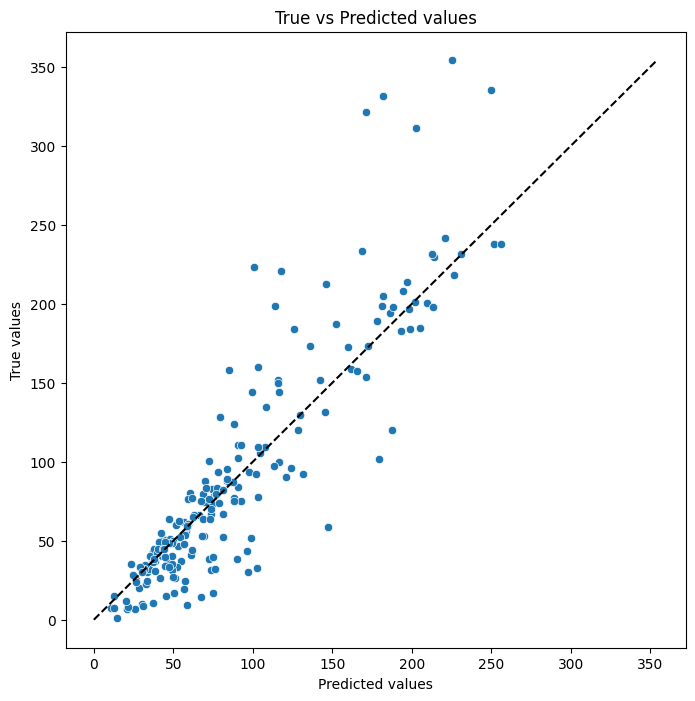

In [510]:
# построим график
evaluate_preds(data_target_test, pred_target_test)

#### Вывод по модели CatBoost

R² модели через кросс-валидацию 0.6798

Методом GridSearchCV подобраны наилучшие параметры модели по характеристике MAE.
Для наилучших параметров модели (n_estimators=500, depth=4) удалось достичь наилучшего результата  
R² на выборке test: 0.79

MAE test: 20.522144600739978

RMSE test: 33.716178553248625

### Модель LightGBM

Модель LightGBM от компании Microsoft подходит для нашего проекта, и может быть эффективно использована для прогнозирования свойств материалов. LightGBM (Light Gradient Boosting Machine) — это высокопроизводительный фреймворк градиентного бустинга, который особенно хорошо работает с табличными данными, и способен обрабатывать большие объемы данных с высокой скоростью и точностью.

LightGBM может быть настроен для работы с данными, содержащими выбросы и несбалансированные распределения, что актуально в нашем случае.

In [511]:
import lightgbm
print("LightGBM version:", lightgbm.__version__)

LightGBM version: 4.5.0


In [512]:
import lightgbm as lgb

In [513]:
# Подготовим датасет требуемого вида
train_dataset = lgb.Dataset(
    data_features_train, data_target_train,\
    free_raw_data=False
    )

In [514]:
# Подготовим датасет требуемого вида
valid_dataset = lgb.Dataset(
    data_features_test, data_target_test,\
    free_raw_data=False
    )

In [515]:
type(valid_dataset)

lightgbm.basic.Dataset

#### Первый пристрелочный вариант параметров

In [516]:
# задачим параметры модели
params = {
    'boosting_type':'gbdt', # 'gbdt' (Gradient Boosting Decision Tree): Классический градиентный бустинг на решающих деревьях.
    'objective': 'regression', # Определяет функцию потерь, которую модель будет оптимизировать во время обучения.
                                # Определяет функцию потерь, которую модель будет оптимизировать во время обучения.
    'metric': 'mae',
    'n_estimators': 10, # количество деревьев
    'max_depth': 5, # максимальная глубина каждого дерева
    'free_raw_data':False, # False заставляет LightGBM сохранить исходные данные в памяти. Это может быть полезно, если необходимо выполнить дополнительные операции с данными после обучения модели
    'verbose': 10 # Указание 10 означает, что LightGBM будет выводить сообщения каждые 10 итераций, информируя о прогрессе обучения и значениях метрик
}

In [517]:
%%time
# Создание экземпляра модели LightGBM с заданными параметрами
# Обучение модели на train_dataset
evals_result = {}
model_lgbm = lgb.train(params=params,
                    train_set=train_dataset,
                    num_boost_round=100,
                    valid_sets=[valid_dataset],
                    callbacks=[lgb.record_evaluation(evals_result)],
                    )

[LightGBM] [Warning] Unknown parameter: free_raw_data
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Unknown parameter: free_raw_data
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.884596
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.193511
[LightGBM] [Debug] init for col-wise cost 0.004604 seconds, init for row-wise cost 0.000476 seconds
[LightGBM] [Info] Auto-choosing c

c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [518]:
def plot_mae(evals_result_):
    '''Визуализация метрик'''
    mae_valid = evals_result_['valid_0']['l1']
    plt.figure(figsize=(10, 5))
    # plt.plot(mae_train, label='Training MAE')
    plt.plot(mae_valid, label='Validation MAE')
    plt.xlabel('Iteration')
    plt.ylabel('MAE')
    plt.title('Validation MAE over Iterations')
    plt.legend()
    plt.show()

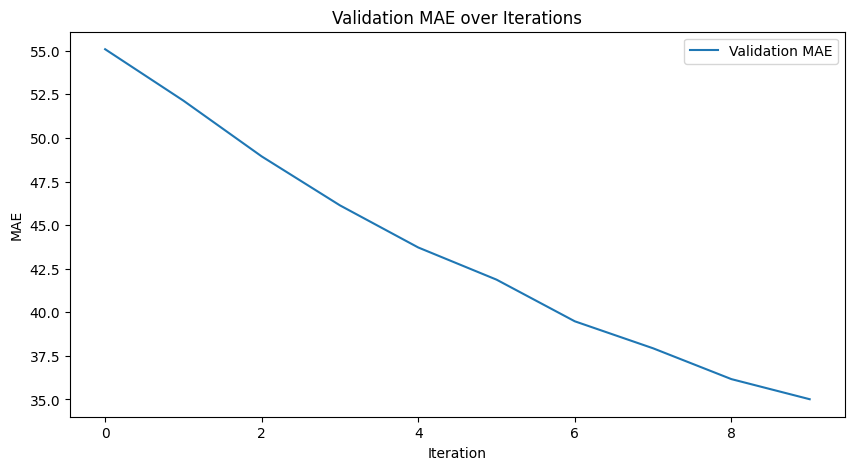

In [519]:
# Визуализация метрик
plot_mae(evals_result)

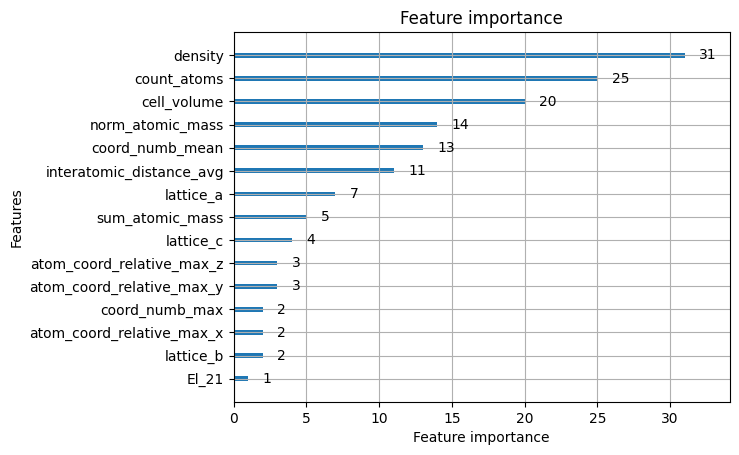

In [520]:
# смотрим важность признаков
_ = lgb.plot_importance(model_lgbm)

#### Второй вариант параметров

In [521]:
# Второй вариант параметров
params_2 = {
    'boosting_type':'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'n_estimators': 75,
    'max_depth': 10,
    'free_raw_data':False,
    'verbose': 10
}

In [522]:
%%time

evals_result_2 = {}
model_lgbm_2 = lgb.train(params_2,
                    train_set=train_dataset, 
                    valid_sets=(valid_dataset,),
                    callbacks=[lgb.record_evaluation(evals_result_2)],
                    num_boost_round=10)

[LightGBM] [Warning] Unknown parameter: free_raw_data
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Unknown parameter: free_raw_data
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=10) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1024) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Unknown parameter: free_raw_data
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max

c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


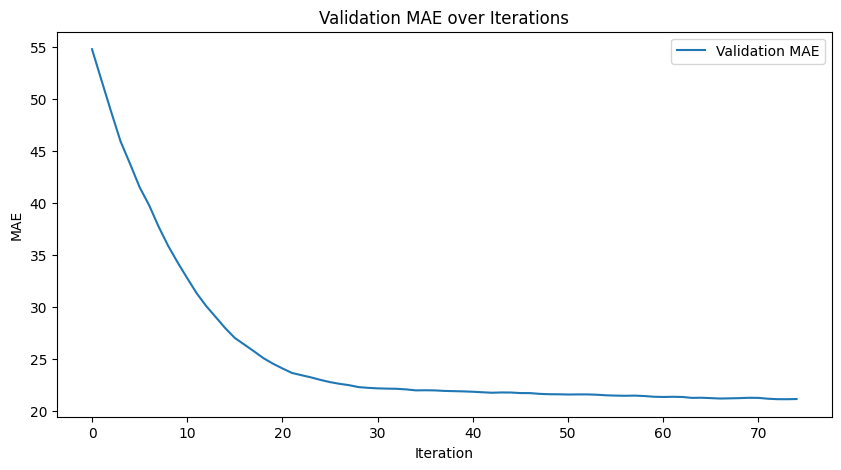

In [523]:
# Визуализация метрик
plot_mae(evals_result_2)

Использование обученной модели для предсказаний

In [524]:
# Предсказание на данных train
y_pred_train = model_lgbm_2.predict(data_features_train)

In [525]:
# Вычисление R² train
r2 = r2_score(data_target_train, y_pred_train)
print(f"R² на выборке train: {r2:.4f}")

R² на выборке train: 0.9576


In [526]:
# Предсказание на данных test
y_pred_test = model_lgbm_2.predict(data_features_test)

In [527]:
# Вычисление R² test
r2 = r2_score(data_target_test, y_pred_test)
print(f"R² на выборке test: {r2:.4f}")

R² на выборке test: 0.8048


In [528]:
# Вычисление MAE test
mae_test = mean_absolute_error(data_target_test, y_pred_test)
print(f"MAE на выборке test: {mae_test:.4f}")

MAE на выборке test: 21.1190


In [529]:
# Вычисление RMSE test
rmse_test = mean_squared_error(data_target_test, y_pred_test)
print(f"RMSE на выборке test: {rmse_test**0.5:.4f}")

RMSE на выборке test: 32.5765


#### Подбор параметров GridSearchCV для LightGBM

In [530]:
# Создание экземпляра модели LightGBM
model_lgb_for_gs = lgb.LGBMRegressor(random_state=270223)

In [531]:
# поиск лучших гиперпараметров через GridSearchCV
parameters =[{
    'boosting_type':['gbdt'],
    'objective': ['regression'],
    'metric': ['mae'],
    'n_estimators': [50, 75, 100, 300], #  количество деревьев (итераций).
    'max_depth': [4, 6, 10], #  максимальная глубина дерева.
    # 'free_raw_data':False,
    # 'verbose': 10
    }]

In [532]:
model_GSCV_Light_GBM = GridSearchCV(
            estimator = model_lgb_for_gs, # модель для настройки
                # loss_function='MAE',
                # verbose=250,
                # cat_features=category_columns
                # ),   
            param_grid = parameters, # сетка гиперпараметров
            scoring='neg_mean_absolute_error', # метрика оценки (neg_mean_absolute_error для MAE)
            cv=5, #  количество фолдов кросс-валидации
            n_jobs=-1, # количество потоков (-1 использует все доступные процессоры)
            verbose=1 # уровень подробности вывода.
            )

In [533]:
%%time
# Обучение модели
model_GSCV_Light_GBM.fit(data_features_train, data_target_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.884596
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.193511
[LightGBM] [Debug] init for col-wise cost 0.000855 seconds, init for row-wise cost 0.000743 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 792, number of used features: 23
[LightGBM] [Info] Start training from score 91.866645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 10
[LightGBM] [Warning] No further splits with positive gain, b

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=270223), n_jobs=-1,
             param_grid=[{'boosting_type': ['gbdt'], 'max_depth': [4, 6, 10],
                          'metric': ['mae'], 'n_estimators': [50, 75, 100, 300],
                          'objective': ['regression']}],
             scoring='neg_mean_absolute_error', verbose=1)

In [534]:
# смотрим наилучшие параметры
model_GSCV_Light_GBM.best_params_

{'boosting_type': 'gbdt',
 'max_depth': 10,
 'metric': 'mae',
 'n_estimators': 100,
 'objective': 'regression'}

In [535]:
# Лучшая оценка
print("Лучшее значение MAE: ", -model_GSCV_Light_GBM.best_score_)

Лучшее значение MAE:  21.145402997992996


#### Оценка модели через кросс-валидацию

In [536]:
# Создание экземпляра модели LightGBM
model_lgb_for_cv = lgb.LGBMRegressor(random_state=270223)

In [537]:
# оценка модели через кросс-валидацию
cv_score_lgb = cross_val_score(model_lgb_for_cv, 
                data_features_train, 
                data_target_train,
                scoring = 'neg_mean_absolute_error',
                cv=5)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.885624
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.193763
[LightGBM] [Debug] init for col-wise cost 0.000293 seconds, init for row-wise cost 0.000249 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3103
[LightGBM] [Info] Number of data points in the train set: 633, number of used features: 23
[LightGBM] [Info] Start training from score 92.415791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves =

In [538]:
# оценка модели через кросс-валидацию
final_cv_score_lgb = round(np.mean(-cv_score_lgb), 1)
print('MAE модели через кросс-валидацию', final_cv_score_lgb)

MAE модели через кросс-валидацию 21.4


In [539]:
# оценка модели через кросс-валидацию
cv_score_lgb_r2 = cross_val_score(model_lgb_for_cv, 
                data_features_train, 
                data_target_train,
                scoring = 'r2',
                cv=5)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.885624
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.193763
[LightGBM] [Debug] init for col-wise cost 0.000508 seconds, init for row-wise cost 0.000417 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3103
[LightGBM] [Info] Number of data points in the train set: 633, number of used features: 23
[LightGBM] [Info] Start training from score 92.415791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves =

In [540]:
cv_score_lgb_r2

array([0.76933758, 0.73499014, 0.83253861, 0.81180375, 0.73069631])

In [541]:
# оценка модели через кросс-валидацию
final_cv_score_lgb_r2 = round(np.mean(cv_score_lgb_r2), 4)
print('R2 модели через кросс-валидацию', final_cv_score_lgb_r2)

R2 модели через кросс-валидацию 0.7759


#### Нилучший вариант параметров

In [569]:
# Лучший вариант параметров
params_best = {
    'boosting_type':'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'n_estimators': 100,
    'max_depth': 10,
    'free_raw_data':False,
    'verbose': 10
}

In [570]:
%%time
evals_result_best = {}
model_lgbm_best = lgb.train(params_best,
                    train_set=train_dataset, 
                    valid_sets=(valid_dataset,),
                    callbacks=[lgb.record_evaluation(evals_result_best)],
                    num_boost_round=10)

[LightGBM] [Warning] Unknown parameter: free_raw_data
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Unknown parameter: free_raw_data
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=10) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1024) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Unknown parameter: free_raw_data
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max

c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


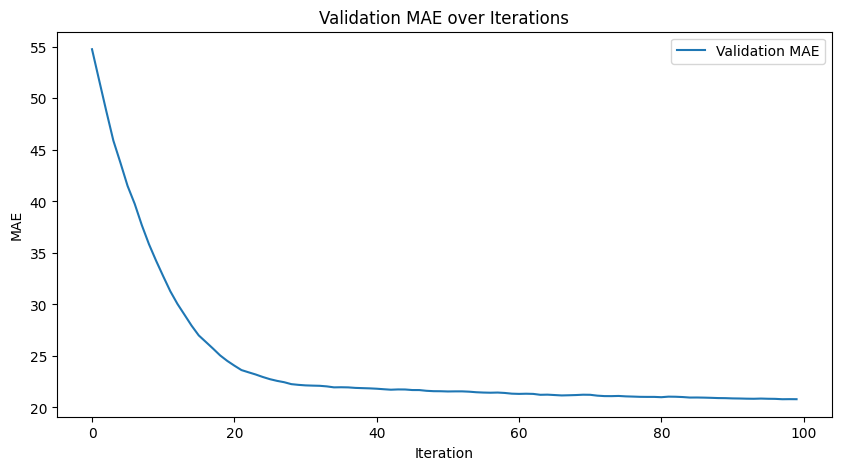

In [571]:
# Визуализация метрик
plot_mae(evals_result_best)

In [572]:
# Предсказание на данных test
y_pred_test_best = model_lgbm_best.predict(data_features_test)

In [573]:
# Вычисление R² test
r2 = r2_score(data_target_test, y_pred_test_best)
print(f"R² на выборке test: {r2:.4f}")

R² на выборке test: 0.8077


In [574]:
# Вычисление MAE test
mae_test = mean_absolute_error(data_target_test, y_pred_test_best)
print(f"MAE на выборке test: {mae_test:.4f}")

MAE на выборке test: 20.8032


In [575]:
# Вычисление RMSE test
rmse_test = mean_squared_error(data_target_test, y_pred_test_best)
print(f"RMSE на выборке test: {rmse_test**0.5:.4f}")

RMSE на выборке test: 32.3363


Перепроверим показатели (на всякий случай)

In [576]:
# Лучший вариант параметров
params_best = {
    'boosting_type':'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'n_estimators': 100,
    'max_depth': 10,
    'free_raw_data':False,
    'verbose': 10
}

In [577]:
# Создание экземпляра модели LightGBM
model_lgb_for_best = lgb.LGBMRegressor(**params_best, random_state=270223)
# при использовании **params_best, Python распаковывает словарь в набор именованных параметров, 
# которые передаются в конструктор

In [578]:
model_lgb_for_best

LGBMRegressor(free_raw_data=False, max_depth=10, metric='mae',
              objective='regression', random_state=270223, verbose=10)

In [579]:
%%time
# Обучение модели
model_lgb_for_best.fit(data_features_train, data_target_train)

[LightGBM] [Warning] Unknown parameter: free_raw_data
[LightGBM] [Warning] Unknown parameter: free_raw_data
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.884596
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.193511
[LightGBM] [Debug] init for col-wise cost 0.000120 seconds, init for row-wise cost 0.000212 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 792, number of used features: 23
[LightGBM] [Info] Start training from score 91.866645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 10
[LightGBM] [W

LGBMRegressor(free_raw_data=False, max_depth=10, metric='mae',
              objective='regression', random_state=270223, verbose=10)

In [580]:
# получаем прогноз
y_pred_test_for_best = model_lgb_for_best.predict(data_features_test)

[LightGBM] [Warning] Unknown parameter: free_raw_data


In [581]:
# Вычисление R² test
r2 = r2_score(data_target_test, y_pred_test_for_best)
print(f"R² на выборке test: {r2:.4f}")

R² на выборке test: 0.8077


In [582]:
# Вычисление MAE test
mae_test = mean_absolute_error(data_target_test, y_pred_test_for_best)
print(f"MAE на выборке test: {mae_test:.4f}")

MAE на выборке test: 20.8032


In [583]:
# Вычисление RMSE test
rmse_test = mean_squared_error(data_target_test, y_pred_test_for_best)
print(f"RMSE на выборке test: {rmse_test**0.5:.4f}")

RMSE на выборке test: 32.3363


#### Вывод по модели LightGBM

R2 модели через кросс-валидацию 0.7759

Методом GridSearchCV подобраны наилучшие параметры модели по характеристике MAE.
Для наилучших параметров модели ('max_depth': 10, 'metric': 'mae', 'n_estimators': 100,)
удалось достичь наилучшего результата R² на выборке test: 0.8

MAE на выборке test: 20.8032

RMSE на выборке test: 32.3363

### Модель GradientBoostingRegressor Градиентный бустинг

GradientBoostingRegressor — это алгоритм градиентного бустинга для решения задач регрессии, реализованный в библиотеке scikit-learn. Он объединяет множество слабых моделей (обычно решающих деревьев) в мощный ансамбль, который последовательно улучшает свои предсказания, минимизируя заданную функцию потерь.

#### Подбор параметров GridSearchCV для GradientBoosting

In [557]:
gb_model_for_gscv = GradientBoostingRegressor(random_state=270223)

In [558]:
# поиск лучших гиперпараметров через GridSearchCV
parameters = {
    'n_estimators': [50, 75, 100, 250, 500],  #  количество деревьев (итераций).
    'max_depth': [4, 6, 10, 15], #  максимальная глубина дерева.
    'learning_rate': [0.01, 0.05, 0.1], # Скорость обучения или шаг градиентного спуска
    # насколько сильно каждое последующее дерево корректирует ошибки предыдущих деревьев
    'subsample': [0.8, 1.0], # Доля выборки, используемых для обучения каждого отдельного дерева.
    'max_features': ['auto', 'sqrt', 'log2'] # Количество признаков, используемых при поиске лучшего разбиения в дереве.
    # 'auto': все признаки
    }

In [559]:
# поиск лучших гиперпараметров через GridSearchCV
model_GSCV_gb = GridSearchCV(
            estimator = gb_model_for_gscv, # модель для настройки
                # loss_function='MAE',
                # verbose=250,
                # cat_features=category_columns
                # ),   
            param_grid = parameters, # сетка гиперпараметров
            scoring='neg_mean_absolute_error', # метрика оценки (neg_mean_absolute_error для MAE)
            cv=5, #  количество фолдов кросс-валидации
            n_jobs=-1, # количество потоков (-1 использует все доступные процессоры)
            verbose=1 # уровень подробности вывода.
            )

In [560]:
model_GSCV_gb

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=270223),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [4, 6, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 75, 100, 250, 500],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_absolute_error', verbose=1)

In [561]:
%%time
# Обучение модели
model_GSCV_gb.fit(data_features_train, data_target_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
600 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
202 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lazarevnv\Desktop\materials_science\Code_example\venv_materials_5\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\lazarevnv\Deskt

CPU times: total: 4.48 s
Wall time: 2min 32s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=270223),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [4, 6, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 75, 100, 250, 500],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_absolute_error', verbose=1)

In [562]:
# Вывод лучших параметров
print("Лучшие параметры: ", model_GSCV_gb.best_params_)

Лучшие параметры:  {'learning_rate': 0.05, 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 500, 'subsample': 0.8}


In [563]:
# Лучшая оценка
print("Лучшее значение MAE: ", -model_GSCV_gb.best_score_)

Лучшее значение MAE:  21.20351261800565


In [564]:
# зафиксируем лучшую модель
model_GSCV_gb_best = model_GSCV_gb.best_estimator_ 
model_GSCV_gb_best

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, max_features='sqrt',
                          n_estimators=500, random_state=270223, subsample=0.8)

In [565]:
# Предсказание на данных test
y_pred_gb_test_best = model_GSCV_gb_best.predict(data_features_test)

In [566]:
# Вычисление R² test
r2 = r2_score(data_target_test, y_pred_gb_test_best)
print(f"R² на выборке test: {r2:.4f}")

R² на выборке test: 0.8289


In [567]:
# Вычисление MAE test
mae_test = mean_absolute_error(data_target_test, y_pred_gb_test_best)
print(f"MAE на выборке test: {mae_test:.4f}")

MAE на выборке test: 20.1131


In [568]:
# Вычисление RMSE test
rmse_test = mean_squared_error(data_target_test, y_pred_gb_test_best)
print(f"RMSE на выборке test: {rmse_test**0.5:.4f}")

RMSE на выборке test: 30.5019


#### Вывод по модели GradientBoosting

Методом GridSearchCV подобраны наилучшие параметры модели по характеристике MAE.
Для наилучших параметров модели ('learning_rate': 0.05, 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 500, 'subsample': 0.8)
удалось достичь наилучшего результата R² на выборке test: 0.8289

MAE на выборке test: 20.1131

RMSE на выборке test: 30.5019

## Общие выводы по проекту

**Загрузка данных.**

Из базы данных Materials Project выгружены данные для 5000 материалов.  
 Датасет содержал следующие поля: 
- `'bulk_modulus_vrh'` — средневзвешенный объемный модуль упругости по правилу Voigt-Reuss-Hill (целевой признак).
- `'composition'` — химический состав материала.
- `'formula'` — упрощенная химическая формула.
- `'e_above_hull'` — энергия выше кривой устойчивости (мера термодинамической нестабильности).
- `'structure'` — полное описание кристаллической структуры материала.
- `'density'` — плотность материала.
- `'volume'` — объем элементарной ячейки кристалла.

Для дальнейшего анализа отобраны 1000 материалов, у которых были доступны все необходимые данные, включая рассчитанный объемный модуль упругости bulk_modulus.

**Формирование новых признаков из данных по структуре.**  
Из данных по структуре удалось создать 59 новых признаков, 

- **Отдельные признаки структуры:**:  
 'lattice_a', 'lattice_b', 'lattice_c' — длины векторов решетки.  
 'angle_alpha', 'angle_beta', 'angle_gamma'  — углы между векторами решетки.  
 'cell_volume' — объем элементарной ячейки.  
 'pbc_a', 'pbc_b', 'pbc_c' — периодические граничные условия.  
 'count_atoms' — количество атомов в структуре.  

- **Картезианские координаты (абсолютные):**
  - **Статистические характеристики:**:  
'atom_coord_cart_mean_x', 'atom_coord_cart_mean_y', 'atom_coord_cart_mean_z',  
'atom_coord_cart_std_x', 'atom_coord_cart_std_y', 'atom_coord_cart_std_z',   
'atom_coord_cart_min_x', 'atom_coord_cart_min_y', 'atom_coord_cart_min_z',  
'atom_coord_cart_max_x', 'atom_coord_cart_max_y', 'atom_coord_cart_max_z',   

- **Признаки агрегации дробных координат:**
  - **Статистические характеристики:**:   
'atom_coord_frac_mean_x', 'atom_coord_frac_mean_y', 'atom_coord_frac_mean_z',  
'atom_coord_frac_std_x', 'atom_coord_frac_std_y', 'atom_coord_frac_std_z',   
'atom_coord_frac_min_x', 'atom_coord_frac_min_y', 'atom_coord_frac_min_z',  
'atom_coord_frac_max_x', 'atom_coord_frac_max_y', 'atom_coord_frac_max_z',  

- **Координаты относительно центра масс:**
  - Признаки, описывающие положение атомов относительно центра масс структуры.  
'atom_coord_relative_mean_x','atom_coord_relative_mean_y', 'atom_coord_relative_mean_z',  
'atom_coord_relative_std_x', 'atom_coord_relative_std_y', 'atom_coord_relative_std_z',   'atom_coord_relative_min_x', 'atom_coord_relative_min_y', 'atom_coord_relative_min_z',   
'atom_coord_relative_max_x', 'atom_coord_relative_max_y', 'atom_coord_relative_max_z',   

-  **Признаки межатомных расстояний:**  
'interatomic_distance_avg', 'interatomic_distance_std',   
'interatomic_distance_min', 'interatomic_distance_max',   

- **Признаки на основе координационных чисел:**
'coord_numb_mean', 'coord_numb_std',
'coord_numb_min', 'coord_numb_max'


**Обоснование создания признаков:**
Эти признаки были сформированы для более полного описания геометрии и топологии кристаллической структуры, что может существенно влиять на механические свойства материалов, включая объемный модуль упругости. Использование статистических характеристик координат и межатомных расстояний позволяет моделировать структурные особенности материалов.

Поскольку данный проект носит исследовательский характер, первоначальная задача заключалась в получении максимального числа признаков, в качестве ознакомления.

На текущем этапе пока не ясно, какие из признаков оставим, а какие придётся отсеять. Это будем определять позже, при анализе влияния фич на целевой параметр.


**Формирование признаков на основе данных composition**  
Подготовлен вспомогательный датафрейм df_atomic_mass с указанием атомной массы для каждого элемента таблицы Менделеева.  
Созданы вспомогательные признаки:  
    sum_atomic_mass- суммарная атомная массы для каждой структуры   
    norm_atomic_mass - нормированная суммарная атомная массы для каждой структуры (например, средняя атомная масса на атом)
Каждый из них позволяет отражать химсостав одним числом.  

Кроме того, применено  OneHot кодирование для создания 119 новых признаков, отражающих количество атомов каждого элемента в материале.
Для каждого элемента был создан количественный признак `'El_{Z}'`, где `{Z}` — атомный номер элемента (от 1 до 119).

Количество атомов химэлементов в структуре:  
'El_1', 'El_2', 'El_3', 'El_4', 'El_5', 'El_6', 'El_7', 'El_8', 'El_9', 'El_10', 'El_11', 'El_12', 'El_13', 'El_14', 'El_15', 'El_16', 'El_17', 'El_18', 'El_19', 'El_20', 'El_21', 'El_22', 'El_23', 'El_24', 'El_25', 'El_26', 'El_27', 'El_28', 'El_29', 'El_30', 'El_31', 'El_32', 'El_33', 'El_34', 'El_35', 'El_36', 'El_37', 'El_38', 'El_39', 'El_40', 'El_41', 'El_42', 'El_43', 'El_44', 'El_45', 'El_46', 'El_47', 'El_48', 'El_49', 'El_50', 'El_51', 'El_52', 'El_53', 'El_54', 'El_55', 'El_56', 'El_57', 'El_58', 'El_59', 'El_60', 'El_61', 'El_62', 'El_63', 'El_64', 'El_65', 'El_66', 'El_67', 'El_68', 'El_69', 'El_70', 'El_71', 'El_72', 'El_73', 'El_74', 'El_75', 'El_76', 'El_77', 'El_78', 'El_79', 'El_80', 'El_81', 'El_82', 'El_83', 'El_84', 'El_85', 'El_86', 'El_87', 'El_88', 'El_89', 'El_90', 'El_91', 'El_92', 'El_93', 'El_94', 'El_95', 'El_96', 'El_97', 'El_98', 'El_99', 'El_100', 'El_101', 'El_102', 'El_103', 'El_104', 'El_105', 'El_106', 'El_107', 'El_108', 'El_109', 'El_110', 'El_111', 'El_112', 'El_113', 'El_114', 'El_115', 'El_116', 'El_117', 'El_118', 'El_119', 

'bulk_modulus_vrh' - целевой признак, объемный модуль упругости.

**Обоснование создания признаков:**  
Химический состав существенно влияет на физико-механические свойства материалов. Включение признаков, отражающих атомные массы и наличие конкретных элементов, позволяет модели учитывать влияние химического состава на объемный модуль упругости.

**Проведен анализ сформированных данных.**  
В рамках анализа выбросов найдены отрицательные значения для bulk_modulus_vrh (средневзвешенного объемного модуля с использованием правила Voigt-Reuss-Hill) которые являются необычными и физически неинтерпретируемыми, поскольку объемный модуль должен быть положительным. Принято решение удалить примеры с отрицательным значением и с нулевым значением bulk_modulus_vrh

Также удалены примеры с выбросами bulk_modulus_vrh более чем 500 ГПа.
Физические ограничения:
Максимальные известные значения объемного модуля упругости для материалов на сегодняшний день не превышают 462 ГПа.
Алмаз и осмий, одни из самых жестких и несжимаемых материалов, имеют объемный модуль упругости около 442 ГПа и 462 ГПа соответственно.
Кубический нитрид бора (c-BN) и лонсдейлит (гексагональный алмаз) также имеют значения около 400–450 ГПа.

Проведен анализ дубликатов и пропусков.

Обнаружено, что признак e_above_hull содержит только 0 значения. Можно выгрузить другие примеры материалов с заполнеными значениями признака. Но по рекомендации от куратора в данном признаке нет необходимости. Т.к. при реальном прогнозе для нового материала его расчёт белее трудоемкий, чем расчёт модуля упругости. Поэтому удаляем лишнее поле.

Принято решение удалить признаки количества элементов El_01, El_02 и т.д., которые не содержат положительных значений. Да, теоретически, формула при новом запросе на прогноз может быть любой. Но конкретно для нашей учебной задачи, где датафрейм не привышает 1000 строк, решение удалить поля не содержащие данных - правильное. Это поможет оптимизировать модель, улучшить ее производительность и интерпретируемость.

В рамках проверки на мультиколлиниарность удалён один из признаков в каждой паре, с взаимной зависимостью более 0.9.
Поскольку и atom_coord_cart_std и atom_coord_relative являются производными от картезианских декартовых координат, то отчасти они дублируют друг друга. В итоге принято решение удалить признаки 'atom_coord_cart_std_x', 'atom_coord_cart_std_y', 'atom_coord_cart_std_z'.

В итоге получен окончательно сформированный датафрейм, который готов к разбивке на train и test.

Сформированный датафрейм разбит данных на train и test в соотношении 4:1.
Получены датафреймы:  
data_features_train, data_features_test, 
data_target_train, data_target_test

Целевой признак bulk_modulus_vrh - объемный модуль упругости.

**Модели машинного обучения**  
В рамках проекта, сформированные данные обработаны моделями CatBoost, LightGBM и GradientBoosting.

**CatBoost**  — это алгоритм градиентного бустинга на решающих деревьях, разработанный компанией Яндекс. В нашем случае, используем его для решения задачи регрессии.

Проведена кросс-валидация с 5 фолдами для оценки стабильности модели.
Начальное значение R²: **0.6798**

Методом GridSearchCV подобраны наилучшие параметры модели по характеристике MAE.
Для наилучших параметров модели (n_estimators=500, depth=4) удалось достичь наилучшего результата  
R² на выборке test: **0.79**

MAE на выборке test: **20.52 ГПа**

RMSE на выборке test: **33.71 ГПа**

Модель CatBoost показала хорошие результаты, но уступила другим моделям по метрикам.


**Модель LightGBM** от компании Microsoft подходит для нашего проекта, и может быть эффективно использована для прогнозирования свойств материалов. LightGBM (Light Gradient Boosting Machine) — это высокопроизводительный фреймворк градиентного бустинга, который особенно хорошо работает с табличными данными, и способен обрабатывать большие объемы данных с высокой скоростью и точностью.

R2 модели через кросс-валидацию **0.7759**

Методом GridSearchCV подобраны наилучшие параметры модели по характеристике MAE.
Для наилучших параметров модели ('max_depth': 10, 'metric': 'mae', 'n_estimators': 100)
удалось достичь наилучшего результата R² на выборке test: **0.80**

MAE на выборке test: **20.8032 ГПа**

RMSE на выборке test: **32.3363 ГПа**

LightGBM показал немного лучшие результаты, чем CatBoost, с небольшим улучшением по метрикам MAE и RMSE.

**GradientBoostingRegressor** — это алгоритм градиентного бустинга для решения задач регрессии, реализованный в библиотеке scikit-learn. Он объединяет множество слабых моделей (обычно решающих деревьев) в мощный ансамбль, который последовательно улучшает свои предсказания, минимизируя заданную функцию потерь.

Методом GridSearchCV подобраны наилучшие параметры модели по характеристике MAE.
Для наилучших параметров модели ('learning_rate': 0.05, 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 500, 'subsample': 0.8)
удалось достичь наилучшего результата R² на выборке test: **0.8289**

MAE на выборке test: **20.1131 ГПа**

RMSE на выборке test: **30.5019 ГПа**

Градиентный бустинг GradientBoostingRegressor показал лучшие результаты среди всех моделей, обеспечив наибольшее значение R² и наименьшие значения MAE и RMSE.


**Сравнение моделей**

| Модель                      | R²     | MAE (ГПа) | RMSE (ГПа) |
|-----------------------------|--------|-----------|------------|
| CatBoost                    | 0.79   | 20.52     | 33.72      |
| LightGBM                    | 0.80   | 20.80     | 32.34      |
| GradientBoostingRegressor   | **0.83** | **20.11**   | **30.50**    |


- **GradientBoostingRegressor** из scikit-learn показал наилучшие результаты на тестовой выборке.
- Различия между моделями незначительны, но могут быть важны в контексте практического применения.
- Возможные причины лучшей производительности GradientBoostingRegressor:
  - Более точная настройка гиперпараметров.
  - Особенности реализации алгоритма в scikit-learn.


**Общие выводы и планы по улучшению проекта**

В ходе проекта была разработана модель для прогнозирования объемного модуля упругости материалов на основе их структурных и химических характеристик. Были созданы и проанализированы различные признаки, проведена тщательная обработка данных и применены современные алгоритмы машинного обучения.

**Ключевые результаты:**

- Лучшие результаты показала модель GradientBoostingRegressor с R² = 0.83.
- Созданные признаки на основе структуры и состава материалов оказались информативными для модели.
- Удаление выбросов и коррелирующих признаков улучшило качество моделей.

**Планы для дальнейших улучшений проекта:**

- **Расширение датасета:**
  - Собрать больше данных для повышения обобщающей способности модели.

- **Дополнительные признаки:**
  - Возможно не все важные признаки были сформированы. Можно подумать в этом направлении.
  - Использовать методы снижения размерности (например, PCA) для сокращения количества признаков.

- **Улучшение моделей:**
  - Протестировать другие алгоритмы, такие как XGBoost.
  - Применить ансамблирование моделей для улучшения точности.

- **Валидация модели:**
  - Провести более детальную кросс-валидацию с использованием других стратегий разбиения.
  - Оценить модель на независимом наборе данных.


Проект продемонстрировал эффективность использования моделей градиентного бустинга для прогнозирования свойств материалов. Полученные результаты могут быть полезны для разработки новых материалов с заданными механическими свойствами и дальнейшего развития методов машинного обучения в материаловедении.